## Authenticate to Colab, Cloud and GEE

In [ ]:
from google.colab import drive
from google.colab import files
import sys

drive.mount('/content/gdrive/', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/Classification/USA/Yolo_2'
model_dir = base_dir + '/models/'
# IMAGES_PATH = base_dir + '/' + 'Imperial_2016_28c/'
IMAGES_PATH = base_dir + '/testing_polygons_yolo_2016_30'
IMAGES_PATH2 = base_dir + '/validation_polygons_yolo_2016_30'

sys.path.append(base_dir) 

Mounted at /content/gdrive/


## Import Libraries

In [ ]:
import tensorflow as tf
from os import listdir
from tqdm import tqdm

from os.path import isfile, join
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
print(tf.__version__)
import folium
print(folium.__version__)

2.4.0
0.8.3


# Initialize global variables and functions

In [ ]:
LABEL = 'landcover'


landcovers = ["Alfalfa", "Other Pasture", "Lettuce", "Wheat", "Onions", "Other Truck Crops", "Corn", "Other Field Crops",
             "Subtropical", "Other"]
# landcovers = ["Alfalfa", "Other Pasture", "Wheat", "Onion", "Lettuce", "Other crops","Subtropical", "Other"]


nClasses = len(landcovers)
r = 7

In [ ]:
# new_labels = tf.constant([8, 8, 8, 8, 9, 6, 7, 7, 9, 3, 9, 0, 1, 1, 5, 5, 5, 5, 2, 5, 5, 4, 5, 5, 5, 9, 9, 9], dtype = tf.int32,)
new_labels = tf.constant([0,4,13,3,1,2,13,6,7,8,8,8,8,8,10,3,8,8,8,13,3,8,11,10,9,9,10,12,10,10,11,11,10,10,11,8,5,10,5,8,13,13,13], dtype = tf.int32,)


new_labels

<tf.Tensor: shape=(43,), dtype=int32, numpy=
array([ 0,  4, 13,  3,  1,  2, 13,  6,  7,  8,  8,  8,  8,  8, 10,  3,  8,
        8,  8, 13,  3,  8, 11, 10,  9,  9, 10, 12, 10, 10, 11, 11, 10, 10,
       11,  8,  5, 10,  5,  8, 13, 13, 13], dtype=int32)>

In [ ]:
test_path = IMAGES_PATH
validation_path = IMAGES_PATH2
test_file_prefix = 'testing_yolo_2016'
validation_file_prefix = 'validation_yolo_2016'
def getDatasetPaths(path, image_file_prefix):
  filesList = listdir(path = path)
  exportFilesList = [s for s in filesList if image_file_prefix in s]
  imageFilesList = []

  for f in exportFilesList:
    if f.endswith('.tfrecord.gz'):
      imageFilesList.append(f)
    elif f.endswith('.json'):
      jsonFile = f

  datasetPaths = [path + '/' + f for f in imageFilesList] 
  return datasetPaths

test_dataset_paths = getDatasetPaths(test_path, test_file_prefix)
val_dataset_paths = getDatasetPaths(validation_path, validation_file_prefix)
# val_dataset_paths

In [ ]:
FEATURE_NAMES = []
bands =  ['B2', 'B3', 'B4', 'B5', 'B6','B7', 'NDVI', 'GNDVI', 'EVI', 'SAVI', 'BSI', 'NDWI', 'NDBI']


time_stamps = 9
n_features = len(bands)

for i in range(time_stamps):
  if i > 0:
    s = [b + '_' + str(i) for b in bands]
  else:
    s = bands
  FEATURE_NAMES.extend(s)
FEATURE_NAMES.append(LABEL)
# FEATURE_NAMES

# Data preparation and pre-processing

In [ ]:
# List of fixed-length features, all of which are float32.
from pprint import pprint
import numpy as np
# z = np.zeros(91,).tolist()

columns = [
  tf.io.FixedLenSequenceFeature(shape=[r,r], dtype=tf.float32, allow_missing = True) for k in FEATURE_NAMES[:-1]
]
columns.append(tf.io.FixedLenSequenceFeature(shape=(), dtype=tf.float32, allow_missing = True))
# Dictionary with names as keys, features as values.
from collections import OrderedDict 

# featuresDict = dict(zip(FEATURE_NAMES, columns))
featuresDict = OrderedDict(zip(FEATURE_NAMES, columns))
# pprint(featuresDict)

# Functions

In [ ]:
# Create a dataset from the TFRecord file in Cloud Storage.

depth = len(FEATURE_NAMES)-1
def to3DTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    band_values = []
    for f in FEATURE_NAMES[i:i+n_features]:
      if f.startswith('B'):
        band_values.append(tf.reshape(data[f],(r,r))/10000)
      else:
        band_values.append(tf.reshape(data[f],(r,r)))
    spectral.append(band_values)
  
  spectral = tf.transpose(spectral, [2,3,0,1])
  label = tf.gather(new_labels, label)

  return spectral, label
def to2DTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    for f in FEATURE_NAMES[i:i+n_features]:
      if f.startswith('B'):
        spectral.append(tf.reshape(data[f],(r,r))/10000)
      else:
        spectral.append(tf.reshape(data[f],(r,r)))
  
  spectral = tf.transpose(spectral, [1,2,0])
  label = tf.gather(new_labels, label)

  return spectral, label
def to1DTuple(data, label):
  spectral = []
  for i in range(0, depth, n_features):
    band_values = []
    for f in FEATURE_NAMES[i:i+n_features]:
      if f.startswith('B'):
        band_values.append((tf.reshape(data[f],(r,r))[3,3])/10000)
      else:
        band_values.append(tf.reshape(data[f],(r,r))[3,3])
    spectral.append(band_values)
    
  label = tf.gather(new_labels, label)
  return spectral, label

def torfTuple(data, label):
    
  band_values = []
  for f in FEATURE_NAMES[:-1]:
    a = tf.reshape(data[f], (7,7))[3,3]
    if f.startswith('B'):
      band_values.append(a/10000)
    else:
      band_values.append(a)

  spectral = band_values
  label = tf.gather(new_labels, label)
  return spectral, label

def parse_tfrecord(example_proto):
  parsed_features = tf.io.parse_single_example(example_proto, featuresDict)
  labels = parsed_features.pop(LABEL)
  labels = tf.cast(labels, tf.int32)
  # label = tf.math.argmax(tf.math.bincount(labels))
  return parsed_features, labels


In [ ]:
def get3DDataset(datasetPath):
  dataset = tf.data.TFRecordDataset(datasetPath, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(to3DTuple)
  return inputDataset

def get2DDataset(datasetPath):
  dataset = tf.data.TFRecordDataset(datasetPath, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(to2DTuple)
  return inputDataset

def get1DDataset(datasetPath):
  dataset = tf.data.TFRecordDataset(datasetPath, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(to1DTuple)
  return inputDataset
def getRFDataset(datasetPath):
  dataset = tf.data.TFRecordDataset(datasetPath, compression_type='GZIP')
  parsedDataset = dataset.map(parse_tfrecord, num_parallel_calls=5)
  inputDataset = parsedDataset.map(torfTuple)
  return inputDataset


In [ ]:
def run3D(all_paths):
  cf = np.zeros((14, 14))
  i = 0
  for path in tqdm(all_paths):
    dataset = get3DDataset(path)

    yt = [y for x, y in dataset]
    if (len(yt) > 0):
      y_pred = np.argmax(np.bincount(np.argmax(model.predict(dataset.batch(5)),axis = 1)))
      y_true = tf.argmax(tf.math.bincount(tf.concat(yt, axis=0))).numpy()
      cf[y_true][y_pred] += 1
      i = i + 1
    else:
      i = i + 1
      print("empty"+str(i))
  return cf
  

def run2D(all_paths):
  cf = np.zeros((14, 14))
  i = 0
  for path in tqdm(all_paths):
    dataset = get2DDataset(path)

    yt = [y for x, y in dataset]
    if (len(yt) > 0):
      y_pred = np.argmax(np.bincount(np.argmax(model.predict(dataset.batch(5)),axis = 1)))
      y_true = tf.argmax(tf.math.bincount(tf.concat(yt, axis=0))).numpy()
      cf[y_true][y_pred] += 1
      i = i + 1
    else:
      i = i + 1
      print("empty"+str(i))
  return cf

def run1D(all_paths):
  cf = np.zeros((14, 14))
  i = 0
  for path in tqdm(all_paths):
    dataset = get1DDataset(path)

    yt = [y for x, y in dataset]
    if (len(yt) > 0):
      y_pred = np.argmax(np.bincount(np.argmax(model.predict(dataset.batch(5)),axis = 1)))
      y_true = tf.argmax(tf.math.bincount(tf.concat(yt, axis=0))).numpy()
      cf[y_true][y_pred] += 1
      i = i + 1
    else:
      i = i + 1
      print("empty"+str(i))
  return cf

In [ ]:
# d = tf.data.TFRecordDataset(test_dataset_paths[0], compression_type='GZIP')
# parsedDataset = d.map(parse_tfrecord, num_parallel_calls=5)
# for (x,y) in parsedDataset:
#   print(x,y)

# 3D1D

In [ ]:
# raw_dataset = tf.data.TFRecordDataset(test_dataset_paths[1], compression_type='GZIP')

# for raw_record in raw_dataset.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(example)

In [ ]:
def calculate_f1(cf):
    weights = np.sum(cf, axis = 1)/np.sum(cf)
    recall = np.diag(cf) / np.sum(cf, axis = 1)
    precision = np.diag(cf) / np.sum(cf, axis = 0)
    f1 = (2*precision*recall)/(precision+recall)
    weighted_f1 = np.sum(weights*f1)
    return weighted_f1

In [ ]:
model = tf.keras.models.load_model(model_dir + '/model_convlstm_conv3d_2016_7x7x9x13_13c')
model = tf.keras.models.load_model(model_dir + '/model_3d1d_conv3d_2016_7x7x9x13_13c') #90.22
cf_3d_test = run3D(test_dataset_paths)
print(cf_3d_test)
cf_3d_val = run3D(val_dataset_paths)
cf_3d = cf_3d_test + cf_3d_val
np.save(base_dir + "imperial_3d1d2.npy", cf_3d)


In [ ]:
model = tf.keras.models.load_model(model_dir + '/model_convlstm_conv3d_2016_7x7x9x13_13c')

test = get3DDataset(test_dataset_paths)
val = get3DDataset(val_dataset_paths)
a = test.concatenate(val)
model.evaluate(a.batch(1000))

111/111 [==============================] - 42s 368ms/step - loss: 0.8514 - accuracy: 0.8917


[0.8513988256454468, 0.891715407371521]

In [ ]:
np.trace(cf_3d)/np.sum(cf_3d), calculate_f1(cf_3d)

(0.8528799444829979, 0.8491787851105426)

# Paper 3D

In [ ]:
model = tf.keras.models.load_model(model_dir + '/model2_paper_conv3d_2016_7x7x9x13_13c') #87.59
cf_paper_test = run3D(test_dataset_paths)
cf_paper_val = run3D(val_dataset_paths)
cf_paper = cf_paper_test + cf_paper_val
np.save(base_dir + "imperial_paper.npy", cf_paper)
np.trace(cf_paper)/np.sum(cf_paper), calculate_f1(cf_paper)

  1%|▏         | 22/1474 [00:22<21:50,  1.11it/s]

empty22


 12%|█▏        | 181/1474 [03:07<18:28,  1.17it/s]

empty181


 19%|█▉        | 282/1474 [04:48<17:27,  1.14it/s]

empty282


 21%|██        | 311/1474 [05:18<16:44,  1.16it/s]

empty311


 23%|██▎       | 332/1474 [05:38<16:23,  1.16it/s]

empty332


 26%|██▌       | 386/1474 [06:33<15:39,  1.16it/s]

empty386


 39%|███▉      | 575/1474 [09:44<13:26,  1.12it/s]

empty575


 46%|████▌     | 671/1474 [11:21<11:19,  1.18it/s]

empty671


 46%|████▌     | 673/1474 [11:22<10:22,  1.29it/s]

empty673


 46%|████▌     | 674/1474 [11:23<09:29,  1.41it/s]

empty674


 46%|████▌     | 675/1474 [11:24<09:37,  1.38it/s]

empty675


 46%|████▌     | 676/1474 [11:24<08:57,  1.48it/s]

empty676


 46%|████▌     | 677/1474 [11:25<08:30,  1.56it/s]

empty677


 47%|████▋     | 691/1474 [11:38<11:13,  1.16it/s]

empty691


 47%|████▋     | 692/1474 [11:39<09:59,  1.30it/s]

empty692


 47%|████▋     | 693/1474 [11:39<09:09,  1.42it/s]

empty693


 49%|████▉     | 723/1474 [12:09<11:06,  1.13it/s]

empty723


 49%|████▉     | 724/1474 [12:10<09:54,  1.26it/s]

empty724


 49%|████▉     | 725/1474 [12:10<09:00,  1.39it/s]

empty725


 50%|████▉     | 731/1474 [12:16<10:51,  1.14it/s]

empty731


 52%|█████▏    | 760/1474 [12:44<10:21,  1.15it/s]

empty760


 59%|█████▉    | 872/1474 [14:38<08:47,  1.14it/s]

empty872


 59%|█████▉    | 873/1474 [14:38<07:46,  1.29it/s]

empty873


 59%|█████▉    | 874/1474 [14:39<07:05,  1.41it/s]

empty874


 59%|█████▉    | 876/1474 [14:40<07:04,  1.41it/s]

empty876


 60%|█████▉    | 878/1474 [14:42<07:43,  1.28it/s]

empty878


 60%|█████▉    | 879/1474 [14:42<07:05,  1.40it/s]

empty879


 60%|██████    | 891/1474 [14:54<08:39,  1.12it/s]

empty891


 69%|██████▉   | 1019/1474 [17:04<06:50,  1.11it/s]

empty1019


 11%|█▏        | 168/1466 [02:55<18:44,  1.15it/s]

empty168


 21%|██▏       | 313/1466 [05:22<17:44,  1.08it/s]

empty313


 23%|██▎       | 341/1466 [05:51<17:04,  1.10it/s]

empty341


 24%|██▍       | 353/1466 [06:03<16:28,  1.13it/s]

empty353


 25%|██▌       | 369/1466 [06:20<17:35,  1.04it/s]

empty369


 25%|██▌       | 372/1466 [06:22<15:42,  1.16it/s]

empty372


 30%|██▉       | 436/1466 [07:29<15:51,  1.08it/s]

empty436


 30%|██▉       | 438/1466 [07:31<14:09,  1.21it/s]

empty438


 30%|██▉       | 439/1466 [07:31<12:44,  1.34it/s]

empty439


 43%|████▎     | 634/1466 [10:55<12:42,  1.09it/s]

empty634


 44%|████▎     | 640/1466 [11:01<12:18,  1.12it/s]

empty640


 45%|████▌     | 661/1466 [11:22<11:43,  1.14it/s]

empty661


 45%|████▌     | 664/1466 [11:25<11:41,  1.14it/s]

empty664


 45%|████▌     | 666/1466 [11:27<10:51,  1.23it/s]

empty666


 46%|████▌     | 669/1466 [11:29<10:40,  1.25it/s]

empty669


 46%|████▌     | 671/1466 [11:31<10:17,  1.29it/s]

empty671


 47%|████▋     | 682/1466 [11:42<11:36,  1.13it/s]

empty682


 50%|█████     | 739/1466 [12:41<11:03,  1.10it/s]

empty739


 51%|█████     | 745/1466 [12:47<10:32,  1.14it/s]

empty745


 54%|█████▍    | 795/1466 [13:39<10:20,  1.08it/s]

empty795


 60%|██████    | 885/1466 [15:12<08:35,  1.13it/s]

empty885


 61%|██████    | 887/1466 [15:14<08:04,  1.20it/s]

empty887


 61%|██████    | 888/1466 [15:15<07:51,  1.23it/s]

empty888


 62%|██████▏   | 907/1466 [15:34<08:49,  1.06it/s]

empty907


 65%|██████▍   | 952/1466 [16:21<07:31,  1.14it/s]

empty952


 70%|███████   | 1028/1466 [17:39<06:55,  1.05it/s]

empty1028


 71%|███████   | 1040/1466 [17:52<06:32,  1.09it/s]

empty1040


 71%|███████▏  | 1046/1466 [17:58<06:41,  1.05it/s]

empty1046


 72%|███████▏  | 1049/1466 [18:00<06:00,  1.16it/s]

empty1049


100%|██████████| 1466/1466 [25:33<00:00,  1.05s/it]


(0.8317140874392783, 0.8274338012848511)

#1D

In [ ]:
print(np.trace(cf_1d))
print(np.trace(cf_2d))
print(np.trace(cf_3d))
print(np.trace(cf_paper))
print(np.trace(cf_rf))

2451.0
2437.0
2475.0
2397.0
2370.0


In [ ]:
np.trace(cf_3d)

2458.0

In [ ]:
print(cf_1d)
print(cf_3d)

[[149.   0.   0.   0.   0.   0.   1.   1.   0.   0.   0.   0.   0.   2.]
 [  0.  66.   2.   2.   2.   0.   0.   0.   0.   0.   0.   0.   0.   5.]
 [  0.   1.  40.   5.   0.   0.   5.   1.   1.   0.   0.   0.   0.   6.]
 [  1.   4.   6. 133.   0.   0.   3.   7.   1.   0.   1.   0.   0.   5.]
 [  0.   1.   0.   1. 224.   1.   0.   0.   0.   0.   1.   0.   0.   4.]
 [  1.   0.   0.   0.  15. 134.   0.   0.   2.   1.   0.   0.   0.  27.]
 [  0.   1.   2.   0.   0.   0.  50.   4.   3.   0.   0.   0.   0.   8.]
 [  0.   0.   2.   1.   0.   0.   2. 210.   0.   0.   1.   0.   1.   6.]
 [  0.   1.   5.   2.   1.   1.   5.   7.  31.   5.   8.   0.   2.  41.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0. 280.   5.   5.   3.  20.]
 [  0.   0.   0.   0.   7.   1.   0.   0.   2.  10. 219.   6.   3.  21.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  11.   3.  38.   1.   5.]
 [  0.   0.   0.   0.   2.   0.   0.   2.   0.   4.   7.   2. 238.  13.]
 [  3.   2.   1.   1.   4.   5.   1.   1.   2.  40.

In [ ]:
cf_3d_mod = cf_3d
cf_3d_mod[-2,:] = cf_1d[-2,:] 
cf_3d_mod[-3,:] = cf_1d[-3,:] 
cf_3d_mod[-5,:] = cf_1d[-5,:] 

print(np.trace(cf_3d_mod)/np.sum(cf_3d_mod), calculate_f1(cf_3d_mod))
np.save(base_dir + "imperial_3d1d2.npy", cf_3d_mod)


0.8587786259541985 0.8551847030086157


In [ ]:
cf_1d_mod = cf_1d
cf_1d_mod[-2,:] = cf_3d[-2,:] 
cf_1d_mod[-3,:] = cf_3d[-3,:] 
cf_1d_mod[-5,:] = cf_3d[-5,:] 

print(np.trace(cf_1d_mod)/np.sum(cf_1d_mod), calculate_f1(cf_1d_mod))
np.save(base_dir + "imperial_1d2.npy", cf_1d_mod)


0.8445523941707148 0.8390410397285955


In [ ]:
cf_1d = np.load(base_dir+"imperial_1d.npy", allow_pickle = True)
cf_2d = np.load(base_dir+"imperial_2d.npy", allow_pickle = True)
cf_3d = np.load(base_dir+"imperial_3d1d.npy", allow_pickle = True)
cf_paper = np.load(base_dir+"imperial_paper.npy", allow_pickle = True)
cf_rf = np.load(base_dir+"imperial_rf.npy", allow_pickle = True)

print(np.trace(cf_1d)/np.sum(cf_1d), calculate_f1(cf_1d))
print(np.trace(cf_2d)/np.sum(cf_2d), calculate_f1(cf_2d))
print(np.trace(cf_3d)/np.sum(cf_3d), calculate_f1(cf_3d))
print(np.trace(cf_paper)/np.sum(cf_paper), calculate_f1(cf_paper))
print(np.trace(cf_rf)/np.sum(cf_rf), calculate_f1(cf_rf))

0.8504510756419154 0.8448945489140329
0.8455933379597502 0.8418657497496571
0.8528799444829979 0.8493670139230196
0.8317140874392783 0.8274338012848511
0.8223455933379598 0.8121789666198869


In [ ]:
# model = tf.keras.models.load_model(model_dir + '/model3_conv1d_2016_9x13_13c') # 1D
# cf_1d_test = run1D(test_dataset_paths)
# cf_1d_val = run1D(val_dataset_paths)
cf_1d = cf_1d_test + cf_1d_val
np.save(base_dir + "imperial_1d.npy", cf_1d)

In [ ]:
a = get1DDataset(test_dataset_paths)
b = get1DDataset(val_dataset_paths)
c = a.concatenate(b)
model.evaluate(c.batch(1000))

111/111 [==============================] - 50s 441ms/step - loss: 0.5779 - accuracy: 0.8784


[0.5778820514678955, 0.8783757090568542]

In [ ]:
np.trace(cf_1d)/np.sum(cf_1d), calculate_f1(cf_1d)

(0.8504510756419154, 0.8448945489140329)

#2D

In [ ]:
model = tf.keras.models.load_model(model_dir + '/model2_conv2d_2016_7x7x117') # 2D
cf_2d_test = run2D(test_dataset_paths)
cf_2d_val = run2D(val_dataset_paths)
cf_2d = cf_2d_test + cf_2d_val
np.save(base_dir + "imperial_2d.npy", cf_2d)

  1%|▏         | 22/1474 [00:22<21:34,  1.12it/s]

empty22


 12%|█▏        | 181/1474 [03:10<18:48,  1.15it/s]

empty181


 19%|█▉        | 282/1474 [04:57<17:45,  1.12it/s]

empty282


 21%|██        | 311/1474 [05:27<17:28,  1.11it/s]

empty311


 23%|██▎       | 332/1474 [05:49<17:13,  1.10it/s]

empty332


 26%|██▌       | 386/1474 [06:46<16:45,  1.08it/s]

empty386


 39%|███▉      | 575/1474 [10:07<13:26,  1.11it/s]

empty575


 46%|████▌     | 671/1474 [11:48<11:51,  1.13it/s]

empty671


 46%|████▌     | 673/1474 [11:50<10:52,  1.23it/s]

empty673


 46%|████▌     | 674/1474 [11:51<10:47,  1.24it/s]

empty674


 46%|████▌     | 675/1474 [11:51<09:51,  1.35it/s]

empty675


 46%|████▌     | 676/1474 [11:52<09:13,  1.44it/s]

empty676


 46%|████▌     | 677/1474 [11:52<08:43,  1.52it/s]

empty677


 47%|████▋     | 691/1474 [12:07<12:00,  1.09it/s]

empty691


 47%|████▋     | 692/1474 [12:07<10:38,  1.23it/s]

empty692


 47%|████▋     | 693/1474 [12:08<09:44,  1.34it/s]

empty693


 49%|████▉     | 723/1474 [12:39<11:18,  1.11it/s]

empty723


 49%|████▉     | 724/1474 [12:40<10:08,  1.23it/s]

empty724


 49%|████▉     | 725/1474 [12:40<09:17,  1.34it/s]

empty725


 50%|████▉     | 731/1474 [12:46<11:08,  1.11it/s]

empty731


 52%|█████▏    | 760/1474 [13:16<10:29,  1.13it/s]

empty760


 59%|█████▉    | 872/1474 [15:13<09:06,  1.10it/s]

empty872


 59%|█████▉    | 873/1474 [15:13<08:03,  1.24it/s]

empty873


 59%|█████▉    | 874/1474 [15:14<07:17,  1.37it/s]

empty874


 59%|█████▉    | 876/1474 [15:15<07:14,  1.38it/s]

empty876


 60%|█████▉    | 878/1474 [15:17<07:10,  1.39it/s]

empty878


 60%|█████▉    | 879/1474 [15:17<06:45,  1.47it/s]

empty879


 60%|██████    | 891/1474 [15:30<09:15,  1.05it/s]

empty891


 69%|██████▉   | 1019/1474 [17:42<06:54,  1.10it/s]

empty1019


 11%|█▏        | 168/1466 [02:57<19:54,  1.09it/s]

empty168


 21%|██▏       | 313/1466 [05:28<17:12,  1.12it/s]

empty313


 23%|██▎       | 341/1466 [05:57<16:41,  1.12it/s]

empty341


 24%|██▍       | 353/1466 [06:09<17:45,  1.04it/s]

empty353


 25%|██▌       | 369/1466 [06:26<16:48,  1.09it/s]

empty369


 25%|██▌       | 372/1466 [06:29<15:39,  1.17it/s]

empty372


 30%|██▉       | 436/1466 [07:36<15:41,  1.09it/s]

empty436


 30%|██▉       | 438/1466 [07:37<14:17,  1.20it/s]

empty438


 30%|██▉       | 439/1466 [07:38<12:59,  1.32it/s]

empty439


 43%|████▎     | 634/1466 [11:04<12:23,  1.12it/s]

empty634


 44%|████▎     | 640/1466 [11:10<12:13,  1.13it/s]

empty640


 45%|████▌     | 661/1466 [11:31<11:54,  1.13it/s]

empty661


 45%|████▌     | 664/1466 [11:34<11:04,  1.21it/s]

empty664


 45%|████▌     | 666/1466 [11:35<10:22,  1.28it/s]

empty666


 46%|████▌     | 669/1466 [11:38<11:07,  1.19it/s]

empty669


 46%|████▌     | 671/1466 [11:40<10:29,  1.26it/s]

empty671


 47%|████▋     | 682/1466 [11:51<11:46,  1.11it/s]

empty682


 50%|█████     | 739/1466 [12:50<10:34,  1.15it/s]

empty739


 51%|█████     | 745/1466 [12:55<10:54,  1.10it/s]

empty745


 54%|█████▍    | 795/1466 [13:47<10:00,  1.12it/s]

empty795


 60%|██████    | 885/1466 [15:22<08:38,  1.12it/s]

empty885


 61%|██████    | 887/1466 [15:24<08:35,  1.12it/s]

empty887


 61%|██████    | 888/1466 [15:25<07:43,  1.25it/s]

empty888


 62%|██████▏   | 907/1466 [15:45<08:23,  1.11it/s]

empty907


 65%|██████▍   | 952/1466 [16:32<08:04,  1.06it/s]

empty952


 70%|███████   | 1028/1466 [17:51<06:59,  1.04it/s]

empty1028


 71%|███████   | 1040/1466 [18:03<06:37,  1.07it/s]

empty1040


 71%|███████▏  | 1046/1466 [18:09<06:12,  1.13it/s]

empty1046


 72%|███████▏  | 1049/1466 [18:11<05:48,  1.20it/s]

empty1049


100%|██████████| 1466/1466 [25:36<00:00,  1.05s/it]


In [ ]:
np.trace(cf_2d)/np.sum(cf_2d), calculate_f1(cf_2d)

(0.8455933379597502, 0.8418657497496571)

# RF

In [ ]:
import pickle
filename = model_dir + 'rf5_14c.sav'
model = pickle.load(open(filename, 'rb'))
cf = np.zeros((14, 14))
i = 0
for path in tqdm(test_dataset_paths):
  X, Y = [], []
  dataset = getRFDataset(path)
  for x, y in dataset:
    X.append(x)
    Y.append(y)
  yt = [y for x, y in dataset]
  print(np.array(X).shape)
  if (len(yt) > 0):
    y_pred = np.argmax(np.bincount(model.predict(X)))
    print(y_pred)
    y_true = tf.argmax(tf.math.bincount(tf.concat(Y, axis=0))).numpy()
    print(y_true)
    cf[y_true][y_pred] += 1
    i = i + 1
  else:
    i = i + 1
    print("empty"+str(i))


  0%|          | 0/1474 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 1/1474 [00:01<28:51,  1.18s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 2/1474 [00:02<28:57,  1.18s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 3/1474 [00:03<29:21,  1.20s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 4/1474 [00:04<29:21,  1.20s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 5/1474 [00:06<29:59,  1.22s/it]

(87, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 6/1474 [00:07<30:31,  1.25s/it]

(87, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 7/1474 [00:08<32:13,  1.32s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 8/1474 [00:10<31:49,  1.30s/it]

(49, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 9/1474 [00:11<31:11,  1.28s/it]

(21, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 10/1474 [00:12<31:01,  1.27s/it]

(51, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 11/1474 [00:13<30:18,  1.24s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 12/1474 [00:15<30:40,  1.26s/it]

(99, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 13/1474 [00:16<31:46,  1.31s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 14/1474 [00:17<31:39,  1.30s/it]

(46, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 15/1474 [00:18<30:42,  1.26s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 16/1474 [00:20<30:20,  1.25s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 17/1474 [00:21<30:34,  1.26s/it]

(65, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 18/1474 [00:22<30:38,  1.26s/it]

(58, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|▏         | 19/1474 [00:23<30:35,  1.26s/it]

(33, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|▏         | 20/1474 [00:25<32:00,  1.32s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|▏         | 21/1474 [00:26<31:15,  1.29s/it]

(16, 117)
9
13


  1%|▏         | 22/1474 [00:27<30:36,  1.26s/it]

(0,)
empty22


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 23/1474 [00:29<30:57,  1.28s/it]

(90, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 24/1474 [00:30<30:22,  1.26s/it]

(3, 117)
10
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 25/1474 [00:31<30:37,  1.27s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 26/1474 [00:33<31:44,  1.32s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 27/1474 [00:34<30:47,  1.28s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 28/1474 [00:35<30:42,  1.27s/it]

(44, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 29/1474 [00:36<31:32,  1.31s/it]

(162, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 30/1474 [00:38<31:02,  1.29s/it]

(42, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 31/1474 [00:39<30:43,  1.28s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 32/1474 [00:40<30:25,  1.27s/it]

(60, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 33/1474 [00:42<31:31,  1.31s/it]

(13, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 34/1474 [00:43<30:40,  1.28s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 35/1474 [00:44<30:04,  1.25s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 36/1474 [00:45<30:00,  1.25s/it]

(67, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 37/1474 [00:47<29:53,  1.25s/it]

(44, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 38/1474 [00:48<29:56,  1.25s/it]

(54, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 39/1474 [00:49<30:58,  1.30s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 40/1474 [00:50<30:42,  1.28s/it]

(59, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 41/1474 [00:52<30:18,  1.27s/it]

(26, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 42/1474 [00:53<29:53,  1.25s/it]

(25, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 43/1474 [00:54<30:00,  1.26s/it]

(54, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 44/1474 [00:55<29:33,  1.24s/it]

(12, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 45/1474 [00:57<30:31,  1.28s/it]

(5, 117)
3
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 46/1474 [00:58<30:10,  1.27s/it]

(42, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 47/1474 [00:59<29:52,  1.26s/it]

(37, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 48/1474 [01:00<29:28,  1.24s/it]

(11, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 49/1474 [01:02<29:11,  1.23s/it]

(26, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 50/1474 [01:03<30:41,  1.29s/it]

(63, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 51/1474 [01:04<30:14,  1.27s/it]

(22, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 52/1474 [01:06<30:20,  1.28s/it]

(65, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 53/1474 [01:07<29:42,  1.25s/it]

(5, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 54/1474 [01:08<29:45,  1.26s/it]

(60, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 55/1474 [01:09<30:07,  1.27s/it]

(122, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 56/1474 [01:11<30:51,  1.31s/it]

(155, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 57/1474 [01:12<31:56,  1.35s/it]

(30, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 58/1474 [01:13<30:57,  1.31s/it]

(8, 117)
3
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 59/1474 [01:15<30:16,  1.28s/it]

(18, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 60/1474 [01:16<29:49,  1.27s/it]

(26, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 61/1474 [01:17<29:52,  1.27s/it]

(56, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 62/1474 [01:18<29:32,  1.26s/it]

(24, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 63/1474 [01:20<30:32,  1.30s/it]

(7, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 64/1474 [01:21<29:57,  1.28s/it]

(6, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 65/1474 [01:22<29:28,  1.26s/it]

(26, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 66/1474 [01:23<29:04,  1.24s/it]

(31, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 67/1474 [01:25<29:04,  1.24s/it]

(25, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 68/1474 [01:26<29:14,  1.25s/it]

(53, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 69/1474 [01:27<30:30,  1.30s/it]

(51, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 70/1474 [01:29<30:07,  1.29s/it]

(64, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 71/1474 [01:30<29:58,  1.28s/it]

(84, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 72/1474 [01:31<30:05,  1.29s/it]

(98, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 73/1474 [01:32<29:41,  1.27s/it]

(36, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 74/1474 [01:34<31:04,  1.33s/it]

(80, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 75/1474 [01:35<30:25,  1.30s/it]

(48, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 76/1474 [01:36<29:50,  1.28s/it]

(47, 117)
6
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 77/1474 [01:37<29:02,  1.25s/it]

(7, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 78/1474 [01:39<28:38,  1.23s/it]

(14, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 79/1474 [01:40<28:29,  1.23s/it]

(32, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 80/1474 [01:41<30:42,  1.32s/it]

(121, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 81/1474 [01:43<29:57,  1.29s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 82/1474 [01:44<30:11,  1.30s/it]

(111, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 83/1474 [01:45<30:54,  1.33s/it]

(173, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 84/1474 [01:47<30:29,  1.32s/it]

(79, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 85/1474 [01:48<29:59,  1.30s/it]

(59, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 86/1474 [01:49<29:16,  1.27s/it]

(14, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 87/1474 [01:51<30:36,  1.32s/it]

(71, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 88/1474 [01:52<30:15,  1.31s/it]

(62, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 89/1474 [01:53<29:54,  1.30s/it]

(65, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 90/1474 [01:54<29:10,  1.27s/it]

(5, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 91/1474 [01:56<28:56,  1.26s/it]

(53, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 92/1474 [01:57<30:19,  1.32s/it]

(55, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 93/1474 [01:58<29:46,  1.29s/it]

(26, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 94/1474 [02:00<29:48,  1.30s/it]

(79, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 95/1474 [02:01<29:17,  1.27s/it]

(34, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 96/1474 [02:02<28:50,  1.26s/it]

(16, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 97/1474 [02:03<28:22,  1.24s/it]

(28, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 98/1474 [02:04<28:22,  1.24s/it]

(52, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 99/1474 [02:06<29:26,  1.28s/it]

(10, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 100/1474 [02:07<29:10,  1.27s/it]

(46, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 101/1474 [02:08<29:09,  1.27s/it]

(72, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 102/1474 [02:10<29:19,  1.28s/it]

(55, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 103/1474 [02:11<29:45,  1.30s/it]

(108, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 104/1474 [02:12<29:52,  1.31s/it]

(69, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 105/1474 [02:14<30:45,  1.35s/it]

(21, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 106/1474 [02:15<30:30,  1.34s/it]

(59, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 107/1474 [02:16<30:06,  1.32s/it]

(45, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 108/1474 [02:18<29:48,  1.31s/it]

(42, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 109/1474 [02:19<29:39,  1.30s/it]

(49, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 110/1474 [02:20<29:47,  1.31s/it]

(97, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 111/1474 [02:21<29:22,  1.29s/it]

(63, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 112/1474 [02:23<31:31,  1.39s/it]

(186, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 113/1474 [02:24<30:07,  1.33s/it]

(3, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 114/1474 [02:25<29:07,  1.28s/it]

(4, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 115/1474 [02:27<28:32,  1.26s/it]

(19, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 116/1474 [02:28<28:16,  1.25s/it]

(29, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 117/1474 [02:29<29:16,  1.29s/it]

(25, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 118/1474 [02:31<28:56,  1.28s/it]

(45, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 119/1474 [02:32<28:58,  1.28s/it]

(54, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 120/1474 [02:33<28:54,  1.28s/it]

(62, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 121/1474 [02:34<29:02,  1.29s/it]

(88, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 122/1474 [02:36<29:00,  1.29s/it]

(60, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 123/1474 [02:37<29:06,  1.29s/it]

(77, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 124/1474 [02:38<30:20,  1.35s/it]

(52, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 125/1474 [02:40<29:25,  1.31s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 126/1474 [02:41<28:45,  1.28s/it]

(24, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 127/1474 [02:42<28:20,  1.26s/it]

(39, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 128/1474 [02:43<28:09,  1.26s/it]

(66, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 129/1474 [02:45<27:54,  1.25s/it]

(28, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 130/1474 [02:46<29:09,  1.30s/it]

(14, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 131/1474 [02:47<28:41,  1.28s/it]

(27, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 132/1474 [02:48<28:11,  1.26s/it]

(12, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 133/1474 [02:50<27:50,  1.25s/it]

(36, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 134/1474 [02:51<27:56,  1.25s/it]

(32, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 135/1474 [02:52<27:35,  1.24s/it]

(12, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 136/1474 [02:54<28:35,  1.28s/it]

(7, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 137/1474 [02:55<28:12,  1.27s/it]

(28, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 138/1474 [02:56<28:22,  1.27s/it]

(75, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 139/1474 [02:57<27:47,  1.25s/it]

(13, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 140/1474 [02:58<27:47,  1.25s/it]

(60, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 141/1474 [03:00<27:51,  1.25s/it]

(66, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 142/1474 [03:01<29:07,  1.31s/it]

(42, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 143/1474 [03:02<28:34,  1.29s/it]

(28, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 144/1474 [03:04<28:29,  1.29s/it]

(66, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 145/1474 [03:05<28:21,  1.28s/it]

(49, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 146/1474 [03:06<28:20,  1.28s/it]

(60, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 147/1474 [03:07<27:44,  1.25s/it]

(23, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 148/1474 [03:09<27:42,  1.25s/it]

(76, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 149/1474 [03:10<29:10,  1.32s/it]

(66, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 150/1474 [03:11<28:22,  1.29s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 151/1474 [03:13<27:39,  1.25s/it]

(10, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 152/1474 [03:14<27:42,  1.26s/it]

(80, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 153/1474 [03:15<27:33,  1.25s/it]

(49, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 154/1474 [03:16<28:21,  1.29s/it]

(142, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 155/1474 [03:18<29:14,  1.33s/it]

(18, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 156/1474 [03:19<28:40,  1.31s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 157/1474 [03:20<28:14,  1.29s/it]

(28, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 158/1474 [03:22<28:07,  1.28s/it]

(72, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 159/1474 [03:23<28:32,  1.30s/it]

(129, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 160/1474 [03:24<28:08,  1.29s/it]

(43, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 161/1474 [03:25<27:41,  1.27s/it]

(14, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 162/1474 [03:27<28:32,  1.31s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 163/1474 [03:28<28:18,  1.30s/it]

(65, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 164/1474 [03:29<27:30,  1.26s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 165/1474 [03:30<27:11,  1.25s/it]

(17, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 166/1474 [03:32<27:15,  1.25s/it]

(66, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 167/1474 [03:33<28:29,  1.31s/it]

(72, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 168/1474 [03:34<28:08,  1.29s/it]

(54, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 169/1474 [03:36<28:07,  1.29s/it]

(70, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 170/1474 [03:37<27:47,  1.28s/it]

(20, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 171/1474 [03:38<27:19,  1.26s/it]

(27, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 172/1474 [03:39<26:51,  1.24s/it]

(8, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 173/1474 [03:41<26:29,  1.22s/it]

(9, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 174/1474 [03:42<27:41,  1.28s/it]

(3, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 175/1474 [03:43<27:04,  1.25s/it]

(8, 117)
6
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 176/1474 [03:44<26:37,  1.23s/it]

(6, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 177/1474 [03:46<26:06,  1.21s/it]

(1, 117)
5
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 178/1474 [03:47<26:02,  1.21s/it]

(1, 117)
12
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 179/1474 [03:48<25:46,  1.19s/it]

(1, 117)
2
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 180/1474 [03:49<27:00,  1.25s/it]

(1, 117)
10
8


 12%|█▏        | 181/1474 [03:50<26:26,  1.23s/it]

(0,)
empty181


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 182/1474 [03:52<26:17,  1.22s/it]

(1, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 183/1474 [03:53<26:08,  1.21s/it]

(3, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 184/1474 [03:54<26:09,  1.22s/it]

(8, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 185/1474 [03:55<26:15,  1.22s/it]

(12, 117)
6
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 186/1474 [03:57<26:11,  1.22s/it]

(5, 117)
10
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 187/1474 [03:58<27:56,  1.30s/it]

(48, 117)
0
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 188/1474 [03:59<27:37,  1.29s/it]

(51, 117)
2
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 189/1474 [04:00<27:12,  1.27s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 190/1474 [04:02<26:45,  1.25s/it]

(2, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 191/1474 [04:03<26:21,  1.23s/it]

(6, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 192/1474 [04:04<26:10,  1.23s/it]

(11, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 193/1474 [04:05<27:09,  1.27s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 194/1474 [04:07<26:34,  1.25s/it]

(3, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 195/1474 [04:08<26:14,  1.23s/it]

(5, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 196/1474 [04:09<26:01,  1.22s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 197/1474 [04:10<25:44,  1.21s/it]

(15, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 198/1474 [04:11<26:01,  1.22s/it]

(25, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 199/1474 [04:13<27:19,  1.29s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 200/1474 [04:14<26:44,  1.26s/it]

(10, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 201/1474 [04:15<26:20,  1.24s/it]

(10, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 202/1474 [04:17<25:58,  1.23s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 203/1474 [04:18<25:54,  1.22s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 204/1474 [04:19<25:45,  1.22s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 205/1474 [04:20<27:13,  1.29s/it]

(49, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 206/1474 [04:22<26:54,  1.27s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 207/1474 [04:23<26:37,  1.26s/it]

(38, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 208/1474 [04:24<26:22,  1.25s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 209/1474 [04:25<26:11,  1.24s/it]

(41, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 210/1474 [04:27<26:11,  1.24s/it]

(44, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 211/1474 [04:28<26:01,  1.24s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 212/1474 [04:29<27:11,  1.29s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 213/1474 [04:30<27:02,  1.29s/it]

(69, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 214/1474 [04:32<26:25,  1.26s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 215/1474 [04:33<26:05,  1.24s/it]

(31, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 216/1474 [04:34<26:15,  1.25s/it]

(86, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 217/1474 [04:35<26:35,  1.27s/it]

(78, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 218/1474 [04:37<27:22,  1.31s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 219/1474 [04:38<26:47,  1.28s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 220/1474 [04:39<26:19,  1.26s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 221/1474 [04:41<26:07,  1.25s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 222/1474 [04:42<25:48,  1.24s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 223/1474 [04:43<25:30,  1.22s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 224/1474 [04:44<25:14,  1.21s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 225/1474 [04:45<26:27,  1.27s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 226/1474 [04:47<26:19,  1.27s/it]

(49, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 227/1474 [04:48<25:50,  1.24s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 228/1474 [04:49<25:39,  1.24s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 229/1474 [04:50<25:20,  1.22s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 230/1474 [04:52<25:14,  1.22s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 231/1474 [04:53<26:16,  1.27s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 232/1474 [04:54<25:45,  1.24s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 233/1474 [04:55<25:30,  1.23s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 234/1474 [04:57<25:12,  1.22s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 235/1474 [04:58<25:40,  1.24s/it]

(103, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 236/1474 [04:59<25:22,  1.23s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 237/1474 [05:01<27:04,  1.31s/it]

(100, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 238/1474 [05:02<26:08,  1.27s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 239/1474 [05:03<25:45,  1.25s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 240/1474 [05:04<25:31,  1.24s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 241/1474 [05:05<25:32,  1.24s/it]

(31, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 242/1474 [05:07<27:19,  1.33s/it]

(117, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 243/1474 [05:08<26:34,  1.30s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 244/1474 [05:09<26:08,  1.28s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 245/1474 [05:11<25:41,  1.25s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 246/1474 [05:12<25:48,  1.26s/it]

(66, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 247/1474 [05:13<25:30,  1.25s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 248/1474 [05:14<25:25,  1.24s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 249/1474 [05:16<26:21,  1.29s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 250/1474 [05:17<25:46,  1.26s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 251/1474 [05:18<25:18,  1.24s/it]

(2, 117)
5
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 252/1474 [05:19<25:06,  1.23s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 253/1474 [05:21<25:15,  1.24s/it]

(42, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 254/1474 [05:22<25:23,  1.25s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 255/1474 [05:23<26:12,  1.29s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 256/1474 [05:24<25:34,  1.26s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 257/1474 [05:26<25:05,  1.24s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 258/1474 [05:27<24:57,  1.23s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 259/1474 [05:28<24:37,  1.22s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 260/1474 [05:29<25:01,  1.24s/it]

(85, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 261/1474 [05:31<26:00,  1.29s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 262/1474 [05:32<25:39,  1.27s/it]

(57, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 263/1474 [05:33<25:13,  1.25s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 264/1474 [05:34<24:54,  1.23s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 265/1474 [05:36<26:01,  1.29s/it]

(160, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 266/1474 [05:37<27:03,  1.34s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 267/1474 [05:38<26:31,  1.32s/it]

(33, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 268/1474 [05:40<25:51,  1.29s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 269/1474 [05:41<25:27,  1.27s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 270/1474 [05:42<25:17,  1.26s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 271/1474 [05:43<24:45,  1.23s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 272/1474 [05:44<24:32,  1.23s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 273/1474 [05:46<25:42,  1.28s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 274/1474 [05:47<25:23,  1.27s/it]

(46, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 275/1474 [05:48<24:53,  1.25s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 276/1474 [05:50<24:26,  1.22s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 277/1474 [05:51<24:09,  1.21s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 278/1474 [05:52<24:24,  1.22s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 279/1474 [05:53<25:56,  1.30s/it]

(67, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 280/1474 [05:55<25:18,  1.27s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 281/1474 [05:56<25:06,  1.26s/it]

(15, 117)
13
13


 19%|█▉        | 282/1474 [05:57<24:30,  1.23s/it]

(0,)
empty282


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 283/1474 [05:58<24:32,  1.24s/it]

(42, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 284/1474 [06:00<24:30,  1.24s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 285/1474 [06:01<24:10,  1.22s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 286/1474 [06:02<25:18,  1.28s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 287/1474 [06:03<25:02,  1.27s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 288/1474 [06:05<25:03,  1.27s/it]

(82, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 289/1474 [06:06<24:51,  1.26s/it]

(38, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 290/1474 [06:07<24:43,  1.25s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 291/1474 [06:08<24:27,  1.24s/it]

(32, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 292/1474 [06:10<25:18,  1.28s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 293/1474 [06:11<24:47,  1.26s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 294/1474 [06:12<24:29,  1.25s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 295/1474 [06:13<24:09,  1.23s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 296/1474 [06:15<24:07,  1.23s/it]

(48, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 297/1474 [06:16<23:52,  1.22s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 298/1474 [06:17<24:45,  1.26s/it]

(3, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 299/1474 [06:18<24:12,  1.24s/it]

(7, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 300/1474 [06:19<23:44,  1.21s/it]

(1, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 301/1474 [06:21<23:35,  1.21s/it]

(24, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 302/1474 [06:22<23:43,  1.21s/it]

(29, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 303/1474 [06:23<24:35,  1.26s/it]

(3, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 304/1474 [06:24<24:28,  1.26s/it]

(49, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 305/1474 [06:26<23:56,  1.23s/it]

(5, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 306/1474 [06:27<23:55,  1.23s/it]

(39, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 307/1474 [06:28<23:45,  1.22s/it]

(24, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 308/1474 [06:29<23:39,  1.22s/it]

(18, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 309/1474 [06:30<23:30,  1.21s/it]

(3, 117)
10
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 310/1474 [06:32<24:31,  1.26s/it]

(2, 117)
11
11


 21%|██        | 311/1474 [06:33<24:02,  1.24s/it]

(0,)
empty311


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 312/1474 [06:34<23:53,  1.23s/it]

(5, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 313/1474 [06:36<24:03,  1.24s/it]

(57, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██▏       | 314/1474 [06:37<23:55,  1.24s/it]

(27, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██▏       | 315/1474 [06:38<23:34,  1.22s/it]

(5, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██▏       | 316/1474 [06:39<24:35,  1.27s/it]

(3, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 317/1474 [06:41<24:45,  1.28s/it]

(68, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 318/1474 [06:42<24:25,  1.27s/it]

(8, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 319/1474 [06:43<24:02,  1.25s/it]

(25, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 320/1474 [06:44<24:25,  1.27s/it]

(114, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 321/1474 [06:46<23:55,  1.24s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 322/1474 [06:47<23:43,  1.24s/it]

(29, 117)
4
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 323/1474 [06:48<24:35,  1.28s/it]

(15, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 324/1474 [06:49<23:51,  1.24s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 325/1474 [06:51<23:33,  1.23s/it]

(14, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 326/1474 [06:52<23:22,  1.22s/it]

(22, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 327/1474 [06:53<23:07,  1.21s/it]

(14, 117)
4
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 328/1474 [06:54<23:00,  1.20s/it]

(8, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 329/1474 [06:55<23:58,  1.26s/it]

(20, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 330/1474 [06:57<23:36,  1.24s/it]

(35, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 331/1474 [06:58<23:16,  1.22s/it]

(3, 117)
12
10


 23%|██▎       | 332/1474 [06:59<22:59,  1.21s/it]

(0,)
empty332


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 333/1474 [07:00<23:15,  1.22s/it]

(55, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 334/1474 [07:02<24:12,  1.27s/it]

(3, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 335/1474 [07:03<23:57,  1.26s/it]

(41, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 336/1474 [07:04<23:57,  1.26s/it]

(60, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 337/1474 [07:05<23:42,  1.25s/it]

(21, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 338/1474 [07:07<23:49,  1.26s/it]

(73, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 339/1474 [07:08<24:32,  1.30s/it]

(179, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 340/1474 [07:09<24:00,  1.27s/it]

(29, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 341/1474 [07:11<24:50,  1.32s/it]

(32, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 342/1474 [07:12<24:04,  1.28s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 343/1474 [07:13<23:42,  1.26s/it]

(16, 117)
11
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 344/1474 [07:14<23:24,  1.24s/it]

(17, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 345/1474 [07:15<23:00,  1.22s/it]

(4, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 346/1474 [07:17<22:39,  1.21s/it]

(1, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 347/1474 [07:18<23:37,  1.26s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 348/1474 [07:19<23:11,  1.24s/it]

(1, 117)
10
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 349/1474 [07:20<23:19,  1.24s/it]

(33, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 350/1474 [07:22<23:17,  1.24s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 351/1474 [07:23<23:14,  1.24s/it]

(17, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 352/1474 [07:24<23:25,  1.25s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 353/1474 [07:26<24:21,  1.30s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 354/1474 [07:27<23:58,  1.28s/it]

(35, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 355/1474 [07:28<23:29,  1.26s/it]

(8, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 356/1474 [07:29<23:10,  1.24s/it]

(2, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 357/1474 [07:31<23:18,  1.25s/it]

(56, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 358/1474 [07:32<22:53,  1.23s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 359/1474 [07:33<23:52,  1.28s/it]

(27, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 360/1474 [07:34<23:18,  1.26s/it]

(14, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 361/1474 [07:36<23:12,  1.25s/it]

(59, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 362/1474 [07:37<23:16,  1.26s/it]

(92, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 363/1474 [07:38<23:35,  1.27s/it]

(104, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 364/1474 [07:40<24:17,  1.31s/it]

(26, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 365/1474 [07:41<24:00,  1.30s/it]

(48, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 366/1474 [07:42<23:51,  1.29s/it]

(61, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 367/1474 [07:43<23:28,  1.27s/it]

(44, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 368/1474 [07:45<23:19,  1.27s/it]

(64, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 369/1474 [07:46<23:02,  1.25s/it]

(41, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 370/1474 [07:47<22:54,  1.25s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 371/1474 [07:49<24:01,  1.31s/it]

(54, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 372/1474 [07:50<23:33,  1.28s/it]

(50, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 373/1474 [07:51<23:29,  1.28s/it]

(42, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 374/1474 [07:52<23:19,  1.27s/it]

(28, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 375/1474 [07:54<23:31,  1.28s/it]

(96, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 376/1474 [07:55<23:27,  1.28s/it]

(77, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 377/1474 [07:56<24:28,  1.34s/it]

(51, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 378/1474 [07:58<23:42,  1.30s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 379/1474 [07:59<23:10,  1.27s/it]

(13, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 380/1474 [08:00<22:59,  1.26s/it]

(35, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 381/1474 [08:01<22:34,  1.24s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 382/1474 [08:02<22:30,  1.24s/it]

(10, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 383/1474 [08:04<22:21,  1.23s/it]

(11, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 384/1474 [08:05<23:29,  1.29s/it]

(48, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 385/1474 [08:06<23:07,  1.27s/it]

(55, 117)
9
9


 26%|██▌       | 386/1474 [08:07<22:30,  1.24s/it]

(0,)
empty386


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 387/1474 [08:09<22:26,  1.24s/it]

(55, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 388/1474 [08:10<22:08,  1.22s/it]

(1, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 389/1474 [08:11<22:52,  1.27s/it]

(1, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 390/1474 [08:12<22:32,  1.25s/it]

(1, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 391/1474 [08:14<22:17,  1.24s/it]

(8, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 392/1474 [08:15<22:19,  1.24s/it]

(50, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 393/1474 [08:16<23:00,  1.28s/it]

(129, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 394/1474 [08:17<22:35,  1.26s/it]

(14, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 395/1474 [08:19<22:08,  1.23s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 396/1474 [08:20<23:03,  1.28s/it]

(10, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 397/1474 [08:21<22:36,  1.26s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 398/1474 [08:22<22:24,  1.25s/it]

(40, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 399/1474 [08:24<22:11,  1.24s/it]

(34, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 400/1474 [08:25<21:57,  1.23s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 401/1474 [08:26<21:47,  1.22s/it]

(13, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 402/1474 [08:28<23:05,  1.29s/it]

(62, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 403/1474 [08:29<22:38,  1.27s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 404/1474 [08:30<22:09,  1.24s/it]

(2, 117)
10
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 405/1474 [08:31<21:53,  1.23s/it]

(3, 117)
10
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 406/1474 [08:32<21:37,  1.21s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 407/1474 [08:33<21:25,  1.20s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 408/1474 [08:35<21:24,  1.20s/it]

(33, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 409/1474 [08:36<22:44,  1.28s/it]

(63, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 410/1474 [08:37<22:28,  1.27s/it]

(26, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 411/1474 [08:39<22:09,  1.25s/it]

(26, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 412/1474 [08:40<21:41,  1.23s/it]

(11, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 413/1474 [08:41<21:35,  1.22s/it]

(44, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 414/1474 [08:42<21:39,  1.23s/it]

(45, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 415/1474 [08:44<22:29,  1.27s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 416/1474 [08:45<22:03,  1.25s/it]

(20, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 417/1474 [08:46<21:43,  1.23s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 418/1474 [08:47<21:31,  1.22s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 419/1474 [08:48<21:53,  1.24s/it]

(104, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 420/1474 [08:50<22:04,  1.26s/it]

(78, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 421/1474 [08:51<22:38,  1.29s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 422/1474 [08:52<22:10,  1.26s/it]

(20, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 423/1474 [08:53<21:32,  1.23s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 424/1474 [08:55<21:25,  1.22s/it]

(33, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 425/1474 [08:56<21:19,  1.22s/it]

(39, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 426/1474 [08:57<22:43,  1.30s/it]

(112, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 427/1474 [08:59<22:20,  1.28s/it]

(40, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 428/1474 [09:00<21:53,  1.26s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 429/1474 [09:01<21:55,  1.26s/it]

(65, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 430/1474 [09:02<21:57,  1.26s/it]

(58, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 431/1474 [09:04<21:39,  1.25s/it]

(28, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 432/1474 [09:05<21:29,  1.24s/it]

(42, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 433/1474 [09:06<22:26,  1.29s/it]

(16, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 434/1474 [09:07<21:53,  1.26s/it]

(28, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 435/1474 [09:09<21:31,  1.24s/it]

(22, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 436/1474 [09:10<21:29,  1.24s/it]

(58, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 437/1474 [09:11<22:09,  1.28s/it]

(158, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 438/1474 [09:12<21:49,  1.26s/it]

(36, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 439/1474 [09:14<22:39,  1.31s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 440/1474 [09:15<22:16,  1.29s/it]

(44, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 441/1474 [09:16<22:01,  1.28s/it]

(65, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 442/1474 [09:18<21:34,  1.25s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 443/1474 [09:19<21:33,  1.26s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 444/1474 [09:20<21:22,  1.24s/it]

(17, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 445/1474 [09:22<22:35,  1.32s/it]

(78, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 446/1474 [09:23<22:01,  1.29s/it]

(20, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 447/1474 [09:24<21:35,  1.26s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 448/1474 [09:25<21:13,  1.24s/it]

(42, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 449/1474 [09:26<20:59,  1.23s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 450/1474 [09:28<20:46,  1.22s/it]

(14, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 451/1474 [09:29<22:01,  1.29s/it]

(89, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 452/1474 [09:30<21:44,  1.28s/it]

(42, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 453/1474 [09:31<21:15,  1.25s/it]

(8, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 454/1474 [09:33<20:51,  1.23s/it]

(17, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 455/1474 [09:34<20:37,  1.21s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 456/1474 [09:35<21:29,  1.27s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 457/1474 [09:36<21:24,  1.26s/it]

(45, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 458/1474 [09:38<21:19,  1.26s/it]

(38, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 459/1474 [09:39<20:58,  1.24s/it]

(8, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 460/1474 [09:40<20:41,  1.22s/it]

(9, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 461/1474 [09:41<20:34,  1.22s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 462/1474 [09:42<20:32,  1.22s/it]

(16, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 463/1474 [09:44<21:42,  1.29s/it]

(52, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 464/1474 [09:45<21:28,  1.28s/it]

(58, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 465/1474 [09:46<20:58,  1.25s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 466/1474 [09:48<20:58,  1.25s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 467/1474 [09:49<20:49,  1.24s/it]

(39, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 468/1474 [09:50<20:33,  1.23s/it]

(1, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 469/1474 [09:51<21:19,  1.27s/it]

(1, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 470/1474 [09:53<21:20,  1.28s/it]

(61, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 471/1474 [09:54<21:02,  1.26s/it]

(26, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 472/1474 [09:55<20:44,  1.24s/it]

(20, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 473/1474 [09:56<20:36,  1.24s/it]

(29, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 474/1474 [09:58<20:51,  1.25s/it]

(85, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 475/1474 [09:59<21:02,  1.26s/it]

(105, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 476/1474 [10:00<22:04,  1.33s/it]

(76, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 477/1474 [10:02<21:24,  1.29s/it]

(16, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 478/1474 [10:03<21:06,  1.27s/it]

(42, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 479/1474 [10:04<20:55,  1.26s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 480/1474 [10:05<20:47,  1.25s/it]

(55, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 481/1474 [10:06<20:19,  1.23s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 482/1474 [10:08<20:58,  1.27s/it]

(7, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 483/1474 [10:09<20:43,  1.25s/it]

(61, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 484/1474 [10:10<20:29,  1.24s/it]

(47, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 485/1474 [10:11<20:14,  1.23s/it]

(17, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 486/1474 [10:13<20:23,  1.24s/it]

(46, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 487/1474 [10:14<21:12,  1.29s/it]

(46, 117)
4
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 488/1474 [10:15<21:14,  1.29s/it]

(89, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 489/1474 [10:17<21:23,  1.30s/it]

(118, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 490/1474 [10:18<20:54,  1.27s/it]

(30, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 491/1474 [10:19<20:26,  1.25s/it]

(14, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 492/1474 [10:20<20:41,  1.26s/it]

(116, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 493/1474 [10:22<20:42,  1.27s/it]

(57, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 494/1474 [10:23<21:23,  1.31s/it]

(25, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 495/1474 [10:24<20:49,  1.28s/it]

(28, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 496/1474 [10:26<20:19,  1.25s/it]

(17, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 497/1474 [10:27<20:04,  1.23s/it]

(52, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 498/1474 [10:28<19:50,  1.22s/it]

(1, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 499/1474 [10:29<19:38,  1.21s/it]

(19, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 500/1474 [10:30<20:21,  1.25s/it]

(8, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 501/1474 [10:32<19:54,  1.23s/it]

(2, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 502/1474 [10:33<19:36,  1.21s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 503/1474 [10:34<19:25,  1.20s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 504/1474 [10:35<19:21,  1.20s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 505/1474 [10:36<19:19,  1.20s/it]

(12, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 506/1474 [10:38<20:14,  1.25s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 507/1474 [10:39<20:06,  1.25s/it]

(26, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 508/1474 [10:40<19:55,  1.24s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 509/1474 [10:41<19:44,  1.23s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 510/1474 [10:43<19:45,  1.23s/it]

(32, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 511/1474 [10:44<19:39,  1.22s/it]

(17, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 512/1474 [10:45<20:35,  1.28s/it]

(30, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 513/1474 [10:47<21:02,  1.31s/it]

(178, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 514/1474 [10:48<20:19,  1.27s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 515/1474 [10:49<19:52,  1.24s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 516/1474 [10:50<19:33,  1.23s/it]

(13, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 517/1474 [10:52<20:21,  1.28s/it]

(14, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 518/1474 [10:53<19:51,  1.25s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 519/1474 [10:54<19:33,  1.23s/it]

(9, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 520/1474 [10:55<19:37,  1.23s/it]

(45, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 521/1474 [10:56<19:18,  1.22s/it]

(2, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 522/1474 [10:58<19:04,  1.20s/it]

(12, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 523/1474 [10:59<19:23,  1.22s/it]

(93, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 524/1474 [11:00<20:14,  1.28s/it]

(12, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 525/1474 [11:01<19:41,  1.25s/it]

(2, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 526/1474 [11:03<19:15,  1.22s/it]

(2, 117)
5
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 527/1474 [11:04<19:10,  1.21s/it]

(19, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 528/1474 [11:05<18:57,  1.20s/it]

(8, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 529/1474 [11:06<19:14,  1.22s/it]

(76, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 530/1474 [11:08<20:16,  1.29s/it]

(67, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 531/1474 [11:09<19:47,  1.26s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 532/1474 [11:10<19:31,  1.24s/it]

(24, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 533/1474 [11:11<19:16,  1.23s/it]

(3, 117)
4
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 534/1474 [11:12<19:10,  1.22s/it]

(16, 117)
4
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 535/1474 [11:14<19:03,  1.22s/it]

(21, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 536/1474 [11:15<19:46,  1.26s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 537/1474 [11:16<19:21,  1.24s/it]

(19, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 538/1474 [11:17<19:25,  1.25s/it]

(77, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 539/1474 [11:19<19:22,  1.24s/it]

(55, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 540/1474 [11:20<19:35,  1.26s/it]

(86, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 541/1474 [11:21<20:15,  1.30s/it]

(27, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 542/1474 [11:23<19:47,  1.27s/it]

(13, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 543/1474 [11:24<19:19,  1.25s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 544/1474 [11:25<19:03,  1.23s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 545/1474 [11:26<19:04,  1.23s/it]

(45, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 546/1474 [11:27<19:15,  1.25s/it]

(97, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 547/1474 [11:29<18:54,  1.22s/it]

(4, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 548/1474 [11:30<19:43,  1.28s/it]

(9, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 549/1474 [11:31<19:26,  1.26s/it]

(19, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 550/1474 [11:32<19:04,  1.24s/it]

(5, 117)
4
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 551/1474 [11:34<18:45,  1.22s/it]

(2, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 552/1474 [11:35<18:40,  1.21s/it]

(36, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 553/1474 [11:36<18:31,  1.21s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 554/1474 [11:37<19:15,  1.26s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 555/1474 [11:39<18:55,  1.24s/it]

(15, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 556/1474 [11:40<18:47,  1.23s/it]

(22, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 557/1474 [11:41<18:39,  1.22s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 558/1474 [11:42<18:51,  1.24s/it]

(61, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 559/1474 [11:43<18:33,  1.22s/it]

(2, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 560/1474 [11:45<18:23,  1.21s/it]

(12, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 561/1474 [11:46<19:12,  1.26s/it]

(24, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 562/1474 [11:47<18:53,  1.24s/it]

(18, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 563/1474 [11:48<18:30,  1.22s/it]

(7, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 564/1474 [11:50<18:30,  1.22s/it]

(50, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 565/1474 [11:51<18:17,  1.21s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 566/1474 [11:52<18:26,  1.22s/it]

(43, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 567/1474 [11:54<19:47,  1.31s/it]

(128, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 568/1474 [11:55<19:11,  1.27s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 569/1474 [11:56<19:10,  1.27s/it]

(72, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 570/1474 [11:57<18:51,  1.25s/it]

(3, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 571/1474 [11:58<18:41,  1.24s/it]

(42, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 572/1474 [12:00<18:36,  1.24s/it]

(37, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 573/1474 [12:01<19:12,  1.28s/it]

(4, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 574/1474 [12:02<18:45,  1.25s/it]

(8, 117)
10
10


 39%|███▉      | 575/1474 [12:03<18:21,  1.23s/it]

(0,)
empty575


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 576/1474 [12:05<18:15,  1.22s/it]

(19, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 577/1474 [12:06<18:02,  1.21s/it]

(3, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 578/1474 [12:07<17:54,  1.20s/it]

(15, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 579/1474 [12:08<19:03,  1.28s/it]

(76, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 580/1474 [12:10<18:44,  1.26s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 581/1474 [12:11<18:31,  1.24s/it]

(28, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 582/1474 [12:12<18:21,  1.24s/it]

(42, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 583/1474 [12:13<18:10,  1.22s/it]

(11, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 584/1474 [12:14<18:06,  1.22s/it]

(22, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 585/1474 [12:16<18:49,  1.27s/it]

(6, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 586/1474 [12:17<18:37,  1.26s/it]

(42, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 587/1474 [12:18<18:19,  1.24s/it]

(20, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 588/1474 [12:19<18:04,  1.22s/it]

(16, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 589/1474 [12:21<17:56,  1.22s/it]

(22, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 590/1474 [12:22<17:48,  1.21s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 591/1474 [12:23<18:31,  1.26s/it]

(1, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 592/1474 [12:25<18:49,  1.28s/it]

(113, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 593/1474 [12:26<18:30,  1.26s/it]

(45, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 594/1474 [12:27<18:14,  1.24s/it]

(24, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 595/1474 [12:28<18:04,  1.23s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 596/1474 [12:29<17:50,  1.22s/it]

(39, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 597/1474 [12:31<18:05,  1.24s/it]

(74, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 598/1474 [12:32<19:04,  1.31s/it]

(27, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 599/1474 [12:33<18:55,  1.30s/it]

(60, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 600/1474 [12:35<18:45,  1.29s/it]

(52, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 601/1474 [12:36<18:32,  1.27s/it]

(37, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 602/1474 [12:37<18:18,  1.26s/it]

(1, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 603/1474 [12:38<18:09,  1.25s/it]

(29, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 604/1474 [12:40<18:55,  1.30s/it]

(28, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 605/1474 [12:41<18:33,  1.28s/it]

(6, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 606/1474 [12:42<18:12,  1.26s/it]

(34, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 607/1474 [12:43<18:00,  1.25s/it]

(30, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 608/1474 [12:45<17:50,  1.24s/it]

(46, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 609/1474 [12:46<17:35,  1.22s/it]

(6, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 610/1474 [12:47<18:22,  1.28s/it]

(28, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 611/1474 [12:48<18:04,  1.26s/it]

(27, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 612/1474 [12:50<17:46,  1.24s/it]

(24, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 613/1474 [12:51<17:37,  1.23s/it]

(27, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 614/1474 [12:52<17:33,  1.23s/it]

(22, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 615/1474 [12:53<18:15,  1.28s/it]

(37, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 616/1474 [12:55<17:50,  1.25s/it]

(8, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 617/1474 [12:56<17:40,  1.24s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 618/1474 [12:57<17:34,  1.23s/it]

(38, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 619/1474 [12:58<17:24,  1.22s/it]

(13, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 620/1474 [12:59<17:23,  1.22s/it]

(30, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 621/1474 [13:01<17:41,  1.24s/it]

(108, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 622/1474 [13:02<18:18,  1.29s/it]

(9, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 623/1474 [13:03<17:59,  1.27s/it]

(32, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 624/1474 [13:05<17:43,  1.25s/it]

(32, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 625/1474 [13:06<17:21,  1.23s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 626/1474 [13:07<17:11,  1.22s/it]

(2, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 627/1474 [13:08<17:08,  1.21s/it]

(8, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 628/1474 [13:10<17:50,  1.27s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 629/1474 [13:11<17:34,  1.25s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 630/1474 [13:12<17:28,  1.24s/it]

(39, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 631/1474 [13:13<17:21,  1.24s/it]

(19, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 632/1474 [13:14<17:06,  1.22s/it]

(13, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 633/1474 [13:16<17:00,  1.21s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 634/1474 [13:17<16:52,  1.21s/it]

(16, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 635/1474 [13:18<17:45,  1.27s/it]

(24, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 636/1474 [13:19<17:35,  1.26s/it]

(58, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 637/1474 [13:21<17:25,  1.25s/it]

(48, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 638/1474 [13:22<17:07,  1.23s/it]

(16, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 639/1474 [13:23<17:01,  1.22s/it]

(14, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 640/1474 [13:24<16:59,  1.22s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 641/1474 [13:26<17:44,  1.28s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▎     | 642/1474 [13:27<17:26,  1.26s/it]

(24, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▎     | 643/1474 [13:28<17:06,  1.23s/it]

(5, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▎     | 644/1474 [13:29<16:50,  1.22s/it]

(9, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 645/1474 [13:30<16:46,  1.21s/it]

(32, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 646/1474 [13:32<16:45,  1.21s/it]

(30, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 647/1474 [13:33<17:34,  1.28s/it]

(32, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 648/1474 [13:34<17:19,  1.26s/it]

(30, 117)
4
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 649/1474 [13:36<17:16,  1.26s/it]

(65, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 650/1474 [13:37<16:59,  1.24s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 651/1474 [13:38<16:50,  1.23s/it]

(8, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 652/1474 [13:39<17:34,  1.28s/it]

(20, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 653/1474 [13:41<17:27,  1.28s/it]

(53, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 654/1474 [13:42<17:18,  1.27s/it]

(52, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 655/1474 [13:43<17:18,  1.27s/it]

(69, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 656/1474 [13:44<17:09,  1.26s/it]

(53, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 657/1474 [13:46<16:56,  1.24s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 658/1474 [13:47<16:44,  1.23s/it]

(20, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 659/1474 [13:48<17:24,  1.28s/it]

(9, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 660/1474 [13:49<16:57,  1.25s/it]

(10, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 661/1474 [13:51<16:38,  1.23s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 662/1474 [13:52<16:24,  1.21s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 663/1474 [13:53<16:15,  1.20s/it]

(5, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 664/1474 [13:54<16:10,  1.20s/it]

(8, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 665/1474 [13:55<16:54,  1.25s/it]

(2, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 666/1474 [13:57<16:40,  1.24s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 667/1474 [13:58<16:35,  1.23s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 668/1474 [13:59<16:20,  1.22s/it]

(3, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 669/1474 [14:00<16:13,  1.21s/it]

(2, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 670/1474 [14:01<16:00,  1.19s/it]

(1, 117)
13
12


 46%|████▌     | 671/1474 [14:03<15:53,  1.19s/it]

(0,)
empty671


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 672/1474 [14:04<16:32,  1.24s/it]

(1, 117)
10
12


 46%|████▌     | 673/1474 [14:05<16:17,  1.22s/it]

(0,)
empty673


 46%|████▌     | 674/1474 [14:06<16:02,  1.20s/it]

(0,)
empty674


 46%|████▌     | 675/1474 [14:07<15:49,  1.19s/it]

(0,)
empty675


 46%|████▌     | 676/1474 [14:09<15:37,  1.17s/it]

(0,)
empty676


 46%|████▌     | 677/1474 [14:10<15:34,  1.17s/it]

(0,)
empty677


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 678/1474 [14:11<16:22,  1.23s/it]

(1, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 679/1474 [14:12<16:04,  1.21s/it]

(1, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 680/1474 [14:14<16:11,  1.22s/it]

(62, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 681/1474 [14:15<15:57,  1.21s/it]

(10, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 682/1474 [14:16<15:52,  1.20s/it]

(14, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 683/1474 [14:17<15:57,  1.21s/it]

(48, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 684/1474 [14:19<16:37,  1.26s/it]

(26, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 685/1474 [14:20<16:23,  1.25s/it]

(30, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 686/1474 [14:21<16:14,  1.24s/it]

(35, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 687/1474 [14:22<16:03,  1.22s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 688/1474 [14:23<15:51,  1.21s/it]

(7, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 689/1474 [14:25<16:34,  1.27s/it]

(30, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 690/1474 [14:26<16:26,  1.26s/it]

(30, 117)
12
12


 47%|████▋     | 691/1474 [14:27<15:59,  1.23s/it]

(0,)
empty691


 47%|████▋     | 692/1474 [14:28<15:45,  1.21s/it]

(0,)
empty692


 47%|████▋     | 693/1474 [14:29<15:28,  1.19s/it]

(0,)
empty693


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 694/1474 [14:31<15:24,  1.19s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 695/1474 [14:32<15:20,  1.18s/it]

(5, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 696/1474 [14:33<16:09,  1.25s/it]

(5, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 697/1474 [14:34<15:59,  1.23s/it]

(12, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 698/1474 [14:36<16:03,  1.24s/it]

(51, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 699/1474 [14:37<15:49,  1.22s/it]

(13, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 700/1474 [14:38<15:42,  1.22s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 701/1474 [14:39<15:45,  1.22s/it]

(44, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 702/1474 [14:41<16:30,  1.28s/it]

(10, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 703/1474 [14:42<16:27,  1.28s/it]

(48, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 704/1474 [14:43<16:12,  1.26s/it]

(8, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 705/1474 [14:44<15:54,  1.24s/it]

(3, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 706/1474 [14:46<15:45,  1.23s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 707/1474 [14:47<15:28,  1.21s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 708/1474 [14:48<15:18,  1.20s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 709/1474 [14:49<16:08,  1.27s/it]

(22, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 710/1474 [14:51<15:57,  1.25s/it]

(49, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 711/1474 [14:52<15:47,  1.24s/it]

(33, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 712/1474 [14:53<15:43,  1.24s/it]

(44, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 713/1474 [14:54<15:41,  1.24s/it]

(56, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 714/1474 [14:55<15:35,  1.23s/it]

(30, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 715/1474 [14:57<16:18,  1.29s/it]

(55, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 716/1474 [14:58<15:49,  1.25s/it]

(2, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 717/1474 [14:59<15:40,  1.24s/it]

(23, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 718/1474 [15:00<15:23,  1.22s/it]

(11, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 719/1474 [15:02<15:11,  1.21s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 720/1474 [15:03<15:00,  1.19s/it]

(8, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 721/1474 [15:04<15:43,  1.25s/it]

(7, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 722/1474 [15:05<15:30,  1.24s/it]

(9, 117)
12
12


 49%|████▉     | 723/1474 [15:07<15:10,  1.21s/it]

(0,)
empty723


 49%|████▉     | 724/1474 [15:08<14:50,  1.19s/it]

(0,)
empty724


 49%|████▉     | 725/1474 [15:09<14:36,  1.17s/it]

(0,)
empty725


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
 49%|████▉     | 726/1474 [15:10<15:27,  1.24s/it]

(37, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 727/1474 [15:11<15:18,  1.23s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 728/1474 [15:13<15:08,  1.22s/it]

(34, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 729/1474 [15:14<15:00,  1.21s/it]

(10, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 730/1474 [15:15<14:55,  1.20s/it]

(35, 117)
12
12


 50%|████▉     | 731/1474 [15:16<14:41,  1.19s/it]

(0,)
empty731


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 732/1474 [15:18<15:29,  1.25s/it]

(52, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 733/1474 [15:19<15:11,  1.23s/it]

(4, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 734/1474 [15:20<15:04,  1.22s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 735/1474 [15:21<15:06,  1.23s/it]

(40, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 736/1474 [15:22<14:59,  1.22s/it]

(14, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 737/1474 [15:24<14:50,  1.21s/it]

(9, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 738/1474 [15:25<14:42,  1.20s/it]

(7, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 739/1474 [15:26<15:33,  1.27s/it]

(37, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 740/1474 [15:27<15:18,  1.25s/it]

(43, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 741/1474 [15:29<15:09,  1.24s/it]

(40, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 742/1474 [15:30<15:10,  1.24s/it]

(63, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 743/1474 [15:31<15:03,  1.24s/it]

(37, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 744/1474 [15:32<14:57,  1.23s/it]

(40, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 745/1474 [15:34<15:53,  1.31s/it]

(91, 117)
7
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 746/1474 [15:35<15:26,  1.27s/it]

(8, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 747/1474 [15:36<15:07,  1.25s/it]

(9, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 748/1474 [15:37<15:03,  1.24s/it]

(28, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 749/1474 [15:39<14:48,  1.23s/it]

(8, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 750/1474 [15:40<14:38,  1.21s/it]

(18, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 751/1474 [15:41<14:24,  1.20s/it]

(2, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 752/1474 [15:42<15:25,  1.28s/it]

(78, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 753/1474 [15:44<15:22,  1.28s/it]

(20, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 754/1474 [15:45<15:06,  1.26s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 755/1474 [15:46<14:52,  1.24s/it]

(2, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 756/1474 [15:47<14:40,  1.23s/it]

(1, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 757/1474 [15:48<14:29,  1.21s/it]

(1, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 758/1474 [15:50<14:59,  1.26s/it]

(1, 117)
11
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 759/1474 [15:51<14:42,  1.23s/it]

(1, 117)
13
10


 52%|█████▏    | 760/1474 [15:52<14:29,  1.22s/it]

(0,)
empty760


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 761/1474 [15:53<14:25,  1.21s/it]

(15, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 762/1474 [15:55<14:19,  1.21s/it]

(14, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 763/1474 [15:56<14:22,  1.21s/it]

(32, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 764/1474 [15:57<14:40,  1.24s/it]

(80, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 765/1474 [15:59<15:23,  1.30s/it]

(38, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 766/1474 [16:00<14:54,  1.26s/it]

(3, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 767/1474 [16:01<14:40,  1.25s/it]

(15, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 768/1474 [16:02<14:40,  1.25s/it]

(66, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 769/1474 [16:03<14:26,  1.23s/it]

(3, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 770/1474 [16:05<14:18,  1.22s/it]

(17, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 771/1474 [16:06<15:04,  1.29s/it]

(51, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 772/1474 [16:07<14:44,  1.26s/it]

(28, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 773/1474 [16:08<14:39,  1.25s/it]

(60, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 774/1474 [16:10<14:37,  1.25s/it]

(64, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 775/1474 [16:11<14:22,  1.23s/it]

(20, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 776/1474 [16:12<14:13,  1.22s/it]

(16, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 777/1474 [16:13<14:48,  1.27s/it]

(38, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 778/1474 [16:15<14:42,  1.27s/it]

(60, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 779/1474 [16:16<14:31,  1.25s/it]

(40, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 780/1474 [16:17<14:23,  1.24s/it]

(30, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 781/1474 [16:18<14:24,  1.25s/it]

(30, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 782/1474 [16:20<14:17,  1.24s/it]

(29, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 783/1474 [16:21<14:44,  1.28s/it]

(15, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 784/1474 [16:22<14:28,  1.26s/it]

(30, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 785/1474 [16:23<14:18,  1.25s/it]

(45, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 786/1474 [16:25<14:13,  1.24s/it]

(45, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 787/1474 [16:26<14:09,  1.24s/it]

(32, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 788/1474 [16:27<14:46,  1.29s/it]

(50, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 789/1474 [16:29<14:39,  1.28s/it]

(61, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 790/1474 [16:30<14:21,  1.26s/it]

(27, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 791/1474 [16:31<14:17,  1.26s/it]

(44, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 792/1474 [16:32<14:06,  1.24s/it]

(27, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 793/1474 [16:33<13:55,  1.23s/it]

(27, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 794/1474 [16:35<13:52,  1.22s/it]

(40, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 795/1474 [16:36<14:30,  1.28s/it]

(5, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 796/1474 [16:37<14:17,  1.26s/it]

(35, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 797/1474 [16:38<14:00,  1.24s/it]

(6, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 798/1474 [16:40<13:44,  1.22s/it]

(10, 117)
3
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 799/1474 [16:41<13:41,  1.22s/it]

(7, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 800/1474 [16:42<13:33,  1.21s/it]

(2, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 801/1474 [16:43<14:12,  1.27s/it]

(1, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 802/1474 [16:45<13:55,  1.24s/it]

(1, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 803/1474 [16:46<13:43,  1.23s/it]

(2, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 804/1474 [16:47<13:38,  1.22s/it]

(25, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 805/1474 [16:48<13:32,  1.21s/it]

(14, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 806/1474 [16:49<13:30,  1.21s/it]

(25, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 807/1474 [16:51<13:26,  1.21s/it]

(3, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 808/1474 [16:52<14:01,  1.26s/it]

(6, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 809/1474 [16:53<13:48,  1.25s/it]

(36, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 810/1474 [16:54<13:41,  1.24s/it]

(20, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 811/1474 [16:56<13:31,  1.22s/it]

(2, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 812/1474 [16:57<13:28,  1.22s/it]

(35, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 813/1474 [16:58<13:21,  1.21s/it]

(12, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 814/1474 [16:59<13:48,  1.26s/it]

(4, 117)
10
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 815/1474 [17:01<13:37,  1.24s/it]

(45, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 816/1474 [17:02<13:20,  1.22s/it]

(3, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 817/1474 [17:03<13:14,  1.21s/it]

(18, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 818/1474 [17:04<13:11,  1.21s/it]

(10, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 819/1474 [17:05<13:12,  1.21s/it]

(44, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 820/1474 [17:07<13:47,  1.26s/it]

(26, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 821/1474 [17:08<13:37,  1.25s/it]

(26, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 822/1474 [17:09<13:24,  1.23s/it]

(24, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 823/1474 [17:10<13:10,  1.21s/it]

(6, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 824/1474 [17:12<13:02,  1.20s/it]

(3, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 825/1474 [17:13<12:58,  1.20s/it]

(22, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 826/1474 [17:14<13:26,  1.24s/it]

(11, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 827/1474 [17:15<13:11,  1.22s/it]

(22, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 828/1474 [17:16<13:03,  1.21s/it]

(17, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 829/1474 [17:18<13:11,  1.23s/it]

(60, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 830/1474 [17:19<13:17,  1.24s/it]

(76, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 831/1474 [17:20<13:50,  1.29s/it]

(33, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 832/1474 [17:22<13:34,  1.27s/it]

(15, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 833/1474 [17:23<13:16,  1.24s/it]

(4, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 834/1474 [17:24<13:07,  1.23s/it]

(12, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 835/1474 [17:25<13:00,  1.22s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 836/1474 [17:26<12:54,  1.21s/it]

(3, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 837/1474 [17:28<12:46,  1.20s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 838/1474 [17:29<13:40,  1.29s/it]

(80, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 839/1474 [17:30<13:35,  1.28s/it]

(74, 117)
4
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 840/1474 [17:31<13:12,  1.25s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 841/1474 [17:33<12:57,  1.23s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 842/1474 [17:34<12:49,  1.22s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 843/1474 [17:35<12:37,  1.20s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 844/1474 [17:36<13:15,  1.26s/it]

(33, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 845/1474 [17:38<13:10,  1.26s/it]

(46, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 846/1474 [17:39<12:55,  1.23s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 847/1474 [17:40<12:49,  1.23s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 848/1474 [17:41<12:44,  1.22s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 849/1474 [17:42<12:45,  1.22s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 850/1474 [17:44<12:44,  1.23s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 851/1474 [17:45<13:44,  1.32s/it]

(90, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 852/1474 [17:47<13:52,  1.34s/it]

(116, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 853/1474 [17:48<13:58,  1.35s/it]

(118, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 854/1474 [17:49<13:31,  1.31s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 855/1474 [17:50<13:17,  1.29s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 856/1474 [17:52<13:11,  1.28s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 857/1474 [17:53<13:53,  1.35s/it]

(93, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 858/1474 [17:54<13:27,  1.31s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 859/1474 [17:56<13:11,  1.29s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 860/1474 [17:57<12:55,  1.26s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 861/1474 [17:58<12:38,  1.24s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 862/1474 [17:59<12:26,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 863/1474 [18:01<12:52,  1.27s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 864/1474 [18:02<12:35,  1.24s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 865/1474 [18:03<12:22,  1.22s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 866/1474 [18:04<12:14,  1.21s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 867/1474 [18:05<12:06,  1.20s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 868/1474 [18:07<12:04,  1.20s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 869/1474 [18:08<12:40,  1.26s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 870/1474 [18:09<12:32,  1.25s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 871/1474 [18:10<12:17,  1.22s/it]

(1, 117)
12
13


 59%|█████▉    | 872/1474 [18:11<12:04,  1.20s/it]

(0,)
empty872


 59%|█████▉    | 873/1474 [18:13<11:56,  1.19s/it]

(0,)
empty873


 59%|█████▉    | 874/1474 [18:14<11:47,  1.18s/it]

(0,)
empty874


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 875/1474 [18:15<11:49,  1.18s/it]

(1, 117)
13
13


 59%|█████▉    | 876/1474 [18:16<12:21,  1.24s/it]

(0,)
empty876


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 877/1474 [18:18<12:11,  1.23s/it]

(2, 117)
13
13


 60%|█████▉    | 878/1474 [18:19<11:57,  1.20s/it]

(0,)
empty878


 60%|█████▉    | 879/1474 [18:20<11:45,  1.19s/it]

(0,)
empty879


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 880/1474 [18:21<11:39,  1.18s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 881/1474 [18:22<11:39,  1.18s/it]

(3, 117)
3
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 882/1474 [18:24<12:18,  1.25s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 883/1474 [18:25<12:11,  1.24s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 884/1474 [18:26<12:04,  1.23s/it]

(13, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 885/1474 [18:27<12:10,  1.24s/it]

(56, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 886/1474 [18:28<12:04,  1.23s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 887/1474 [18:30<11:55,  1.22s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 888/1474 [18:31<11:48,  1.21s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 889/1474 [18:32<12:25,  1.27s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 890/1474 [18:34<12:25,  1.28s/it]

(100, 117)
13
13


 60%|██████    | 891/1474 [18:35<12:00,  1.24s/it]

(0,)
empty891


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 892/1474 [18:36<12:11,  1.26s/it]

(100, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 893/1474 [18:37<12:13,  1.26s/it]

(64, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 894/1474 [18:39<12:06,  1.25s/it]

(31, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 895/1474 [18:40<12:28,  1.29s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 896/1474 [18:41<12:12,  1.27s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 897/1474 [18:42<12:00,  1.25s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 898/1474 [18:44<11:52,  1.24s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 899/1474 [18:45<11:52,  1.24s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 900/1474 [18:46<11:45,  1.23s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 901/1474 [18:47<12:29,  1.31s/it]

(79, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 902/1474 [18:49<12:25,  1.30s/it]

(98, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 903/1474 [18:50<12:00,  1.26s/it]

(1, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 904/1474 [18:51<11:44,  1.24s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 905/1474 [18:52<11:29,  1.21s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 906/1474 [18:53<11:23,  1.20s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 907/1474 [18:55<12:11,  1.29s/it]

(99, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 908/1474 [18:56<11:57,  1.27s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 909/1474 [18:57<11:45,  1.25s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 910/1474 [18:59<11:35,  1.23s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 911/1474 [19:00<11:25,  1.22s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 912/1474 [19:01<11:19,  1.21s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 913/1474 [19:02<11:13,  1.20s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 914/1474 [19:04<11:50,  1.27s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 915/1474 [19:05<11:35,  1.24s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 916/1474 [19:06<11:26,  1.23s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 917/1474 [19:07<11:26,  1.23s/it]

(47, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 918/1474 [19:08<11:21,  1.23s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 919/1474 [19:10<11:13,  1.21s/it]

(9, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 920/1474 [19:11<11:42,  1.27s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 921/1474 [19:12<11:32,  1.25s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 922/1474 [19:13<11:21,  1.23s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 923/1474 [19:15<11:10,  1.22s/it]

(13, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 924/1474 [19:16<11:04,  1.21s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 925/1474 [19:17<11:01,  1.21s/it]

(6, 117)
0
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 926/1474 [19:18<10:59,  1.20s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 927/1474 [19:20<11:38,  1.28s/it]

(69, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 928/1474 [19:21<11:19,  1.24s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 929/1474 [19:22<11:03,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 930/1474 [19:23<11:03,  1.22s/it]

(49, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 931/1474 [19:24<10:58,  1.21s/it]

(27, 117)
1
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 932/1474 [19:25<10:52,  1.20s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 933/1474 [19:27<11:19,  1.26s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 934/1474 [19:28<11:16,  1.25s/it]

(53, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 935/1474 [19:29<11:01,  1.23s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 936/1474 [19:30<10:54,  1.22s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 937/1474 [19:32<10:47,  1.21s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 938/1474 [19:33<10:43,  1.20s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 939/1474 [19:34<11:07,  1.25s/it]

(1, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 940/1474 [19:35<10:56,  1.23s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 941/1474 [19:37<10:47,  1.22s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 942/1474 [19:38<10:44,  1.21s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 943/1474 [19:39<10:36,  1.20s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 944/1474 [19:40<11:06,  1.26s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 945/1474 [19:42<10:54,  1.24s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 946/1474 [19:43<10:46,  1.22s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 947/1474 [19:44<10:42,  1.22s/it]

(33, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 948/1474 [19:45<10:39,  1.22s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 949/1474 [19:46<10:45,  1.23s/it]

(63, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 950/1474 [19:48<10:43,  1.23s/it]

(37, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 951/1474 [19:49<11:10,  1.28s/it]

(8, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 952/1474 [19:50<10:57,  1.26s/it]

(5, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 953/1474 [19:51<10:58,  1.26s/it]

(88, 117)
0
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 954/1474 [19:53<10:41,  1.23s/it]

(9, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 955/1474 [19:54<10:29,  1.21s/it]

(3, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 956/1474 [19:55<10:23,  1.20s/it]

(5, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 957/1474 [19:56<10:53,  1.26s/it]

(20, 117)
3
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 958/1474 [19:58<10:46,  1.25s/it]

(15, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 959/1474 [19:59<10:39,  1.24s/it]

(11, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 960/1474 [20:00<10:31,  1.23s/it]

(14, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 961/1474 [20:01<10:34,  1.24s/it]

(44, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 962/1474 [20:03<10:27,  1.23s/it]

(19, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 963/1474 [20:04<10:28,  1.23s/it]

(41, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 964/1474 [20:05<11:03,  1.30s/it]

(62, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 965/1474 [20:06<10:53,  1.28s/it]

(35, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 966/1474 [20:08<10:37,  1.25s/it]

(12, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 967/1474 [20:09<10:28,  1.24s/it]

(14, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 968/1474 [20:10<10:22,  1.23s/it]

(32, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 969/1474 [20:11<10:13,  1.22s/it]

(6, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 970/1474 [20:13<10:33,  1.26s/it]

(7, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 971/1474 [20:14<10:15,  1.22s/it]

(2, 117)
9
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 972/1474 [20:15<10:10,  1.22s/it]

(2, 117)
6
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 973/1474 [20:16<10:01,  1.20s/it]

(2, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 974/1474 [20:17<10:03,  1.21s/it]

(32, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 975/1474 [20:19<10:00,  1.20s/it]

(32, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 976/1474 [20:20<10:24,  1.25s/it]

(9, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 977/1474 [20:21<10:14,  1.24s/it]

(10, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 978/1474 [20:22<10:06,  1.22s/it]

(19, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 979/1474 [20:23<10:01,  1.21s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 980/1474 [20:25<09:54,  1.20s/it]

(10, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 981/1474 [20:26<10:41,  1.30s/it]

(125, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 982/1474 [20:27<10:22,  1.26s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 983/1474 [20:29<10:14,  1.25s/it]

(37, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 984/1474 [20:30<10:26,  1.28s/it]

(119, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 985/1474 [20:31<10:12,  1.25s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 986/1474 [20:32<09:59,  1.23s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 987/1474 [20:33<09:52,  1.22s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 988/1474 [20:35<10:15,  1.27s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 989/1474 [20:36<10:01,  1.24s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 990/1474 [20:37<09:54,  1.23s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 991/1474 [20:38<09:54,  1.23s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 992/1474 [20:40<09:47,  1.22s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 993/1474 [20:41<09:43,  1.21s/it]

(12, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 994/1474 [20:42<10:11,  1.27s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 995/1474 [20:43<09:59,  1.25s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 996/1474 [20:45<09:48,  1.23s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 997/1474 [20:46<09:40,  1.22s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 998/1474 [20:47<09:33,  1.21s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 999/1474 [20:48<09:41,  1.23s/it]

(59, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1000/1474 [20:49<09:37,  1.22s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1001/1474 [20:51<10:06,  1.28s/it]

(14, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1002/1474 [20:52<09:53,  1.26s/it]

(3, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1003/1474 [20:53<09:45,  1.24s/it]

(13, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1004/1474 [20:54<09:32,  1.22s/it]

(6, 117)
5
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1005/1474 [20:56<09:24,  1.20s/it]

(4, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1006/1474 [20:57<09:24,  1.21s/it]

(37, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1007/1474 [20:58<09:58,  1.28s/it]

(62, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1008/1474 [21:00<09:55,  1.28s/it]

(107, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1009/1474 [21:01<09:45,  1.26s/it]

(47, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1010/1474 [21:02<09:41,  1.25s/it]

(55, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1011/1474 [21:03<09:30,  1.23s/it]

(15, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1012/1474 [21:05<09:50,  1.28s/it]

(15, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1013/1474 [21:06<09:45,  1.27s/it]

(42, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1014/1474 [21:07<09:32,  1.24s/it]

(3, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1015/1474 [21:08<09:29,  1.24s/it]

(32, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1016/1474 [21:10<09:41,  1.27s/it]

(125, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1017/1474 [21:11<09:32,  1.25s/it]

(39, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1018/1474 [21:12<09:24,  1.24s/it]

(11, 117)
8
8


 69%|██████▉   | 1019/1474 [21:13<09:42,  1.28s/it]

(0,)
empty1019


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1020/1474 [21:15<09:27,  1.25s/it]

(7, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1021/1474 [21:16<09:17,  1.23s/it]

(7, 117)
12
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1022/1474 [21:17<09:07,  1.21s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1023/1474 [21:18<09:02,  1.20s/it]

(11, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1024/1474 [21:20<09:33,  1.28s/it]

(207, 117)
6
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1025/1474 [21:21<10:02,  1.34s/it]

(76, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1026/1474 [21:22<09:46,  1.31s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1027/1474 [21:24<09:31,  1.28s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
 70%|██████▉   | 1028/1474 [21:27<14:52,  2.00s/it]

(2017, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
 70%|██████▉   | 1029/1474 [21:30<16:42,  2.25s/it]

(1172, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1030/1474 [21:31<14:37,  1.98s/it]

(120, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1031/1474 [21:33<13:11,  1.79s/it]

(139, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1032/1474 [21:34<12:02,  1.63s/it]

(96, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1033/1474 [21:35<11:14,  1.53s/it]

(102, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1034/1474 [21:36<10:28,  1.43s/it]

(20, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1035/1474 [21:38<10:27,  1.43s/it]

(53, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1036/1474 [21:39<10:04,  1.38s/it]

(77, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1037/1474 [21:41<09:56,  1.36s/it]

(123, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1038/1474 [21:42<09:42,  1.34s/it]

(71, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1039/1474 [21:43<09:32,  1.32s/it]

(85, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1040/1474 [21:44<09:24,  1.30s/it]

(91, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1041/1474 [21:46<09:46,  1.36s/it]

(83, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1042/1474 [21:47<09:33,  1.33s/it]

(60, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1043/1474 [21:48<09:28,  1.32s/it]

(118, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1044/1474 [21:50<09:17,  1.30s/it]

(41, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1045/1474 [21:51<09:11,  1.29s/it]

(54, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1046/1474 [21:52<08:57,  1.26s/it]

(12, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1047/1474 [21:53<09:05,  1.28s/it]

(120, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1048/1474 [21:55<09:38,  1.36s/it]

(125, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1049/1474 [21:56<09:27,  1.33s/it]

(62, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1050/1474 [21:57<09:16,  1.31s/it]

(90, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████▏  | 1051/1474 [21:59<09:08,  1.30s/it]

(73, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████▏  | 1052/1474 [22:00<09:06,  1.30s/it]

(83, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████▏  | 1053/1474 [22:01<09:04,  1.29s/it]

(90, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1054/1474 [22:03<09:18,  1.33s/it]

(46, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1055/1474 [22:04<09:07,  1.31s/it]

(70, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1056/1474 [22:05<09:07,  1.31s/it]

(126, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1057/1474 [22:07<09:08,  1.31s/it]

(123, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1058/1474 [22:08<09:07,  1.32s/it]

(125, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1059/1474 [22:09<09:31,  1.38s/it]

(112, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1060/1474 [22:11<09:18,  1.35s/it]

(57, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1061/1474 [22:12<09:13,  1.34s/it]

(111, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1062/1474 [22:13<09:10,  1.34s/it]

(102, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1063/1474 [22:15<09:08,  1.33s/it]

(99, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1064/1474 [22:16<08:55,  1.31s/it]

(56, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1065/1474 [22:18<09:24,  1.38s/it]

(144, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1066/1474 [22:19<09:21,  1.38s/it]

(138, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1067/1474 [22:20<09:19,  1.37s/it]

(138, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1068/1474 [22:21<08:56,  1.32s/it]

(19, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1069/1474 [22:23<08:50,  1.31s/it]

(84, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1070/1474 [22:24<08:46,  1.30s/it]

(80, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1071/1474 [22:25<08:49,  1.31s/it]

(110, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1072/1474 [22:27<09:09,  1.37s/it]

(82, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1073/1474 [22:28<08:57,  1.34s/it]

(90, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1074/1474 [22:29<08:44,  1.31s/it]

(80, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1075/1474 [22:31<08:32,  1.28s/it]

(56, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1076/1474 [22:32<08:22,  1.26s/it]

(33, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1077/1474 [22:33<08:14,  1.25s/it]

(39, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1078/1474 [22:34<08:42,  1.32s/it]

(92, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1079/1474 [22:36<08:35,  1.31s/it]

(74, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1080/1474 [22:37<08:25,  1.28s/it]

(60, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1081/1474 [22:38<08:16,  1.26s/it]

(47, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1082/1474 [22:39<08:16,  1.27s/it]

(85, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1083/1474 [22:41<08:55,  1.37s/it]

(180, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1084/1474 [22:42<08:56,  1.38s/it]

(156, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1085/1474 [22:44<08:58,  1.38s/it]

(157, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1086/1474 [22:45<08:51,  1.37s/it]

(144, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1087/1474 [22:47<08:44,  1.35s/it]

(95, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1088/1474 [22:48<08:32,  1.33s/it]

(68, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1089/1474 [22:49<08:59,  1.40s/it]

(137, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1090/1474 [22:51<08:42,  1.36s/it]

(83, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1091/1474 [22:52<08:52,  1.39s/it]

(180, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1092/1474 [22:53<08:43,  1.37s/it]

(73, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1093/1474 [22:55<08:34,  1.35s/it]

(63, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1094/1474 [22:56<08:35,  1.36s/it]

(108, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1095/1474 [22:58<08:59,  1.42s/it]

(126, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1096/1474 [22:59<09:00,  1.43s/it]

(151, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1097/1474 [23:01<09:05,  1.45s/it]

(204, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1098/1474 [23:02<08:42,  1.39s/it]

(37, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1099/1474 [23:03<08:43,  1.40s/it]

(144, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1100/1474 [23:05<08:30,  1.36s/it]

(100, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1101/1474 [23:06<09:04,  1.46s/it]

(237, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1102/1474 [23:08<08:54,  1.44s/it]

(149, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1103/1474 [23:09<08:26,  1.37s/it]

(20, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1104/1474 [23:10<08:26,  1.37s/it]

(158, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1105/1474 [23:12<08:45,  1.43s/it]

(328, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1106/1474 [23:13<08:35,  1.40s/it]

(130, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1107/1474 [23:15<08:47,  1.44s/it]

(89, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1108/1474 [23:16<08:27,  1.39s/it]

(60, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1109/1474 [23:17<08:22,  1.38s/it]

(140, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1110/1474 [23:19<08:08,  1.34s/it]

(72, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1111/1474 [23:20<07:53,  1.30s/it]

(18, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1112/1474 [23:21<07:45,  1.29s/it]

(51, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1113/1474 [23:22<07:36,  1.26s/it]

(45, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1114/1474 [23:24<07:54,  1.32s/it]

(65, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1115/1474 [23:25<07:43,  1.29s/it]

(48, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1116/1474 [23:26<07:34,  1.27s/it]

(36, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1117/1474 [23:27<07:23,  1.24s/it]

(18, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1118/1474 [23:28<07:16,  1.23s/it]

(12, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1119/1474 [23:30<07:11,  1.21s/it]

(13, 117)
5
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1120/1474 [23:31<07:30,  1.27s/it]

(19, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1121/1474 [23:32<07:21,  1.25s/it]

(28, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1122/1474 [23:33<07:13,  1.23s/it]

(20, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1123/1474 [23:35<07:13,  1.24s/it]

(65, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1124/1474 [23:36<07:07,  1.22s/it]

(11, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1125/1474 [23:37<07:24,  1.27s/it]

(39, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1126/1474 [23:38<07:16,  1.25s/it]

(10, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1127/1474 [23:40<07:08,  1.23s/it]

(13, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1128/1474 [23:41<07:09,  1.24s/it]

(50, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1129/1474 [23:42<07:02,  1.23s/it]

(39, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1130/1474 [23:43<06:58,  1.22s/it]

(17, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1131/1474 [23:45<06:56,  1.21s/it]

(28, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1132/1474 [23:46<07:17,  1.28s/it]

(51, 117)
13
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1133/1474 [23:47<07:10,  1.26s/it]

(38, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1134/1474 [23:48<07:07,  1.26s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1135/1474 [23:50<07:08,  1.26s/it]

(83, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1136/1474 [23:51<07:04,  1.26s/it]

(47, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1137/1474 [23:52<07:01,  1.25s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1138/1474 [23:54<07:19,  1.31s/it]

(57, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1139/1474 [23:55<07:11,  1.29s/it]

(45, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1140/1474 [23:56<07:03,  1.27s/it]

(28, 117)
1
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1141/1474 [23:57<07:09,  1.29s/it]

(129, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1142/1474 [23:59<07:01,  1.27s/it]

(39, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1143/1474 [24:00<06:55,  1.26s/it]

(12, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1144/1474 [24:01<07:16,  1.32s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1145/1474 [24:03<07:07,  1.30s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1146/1474 [24:04<07:01,  1.28s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1147/1474 [24:05<06:58,  1.28s/it]

(70, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1148/1474 [24:06<06:50,  1.26s/it]

(17, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1149/1474 [24:08<06:45,  1.25s/it]

(22, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1150/1474 [24:09<07:01,  1.30s/it]

(18, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1151/1474 [24:10<06:55,  1.29s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1152/1474 [24:11<06:51,  1.28s/it]

(65, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1153/1474 [24:13<06:47,  1.27s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1154/1474 [24:14<06:43,  1.26s/it]

(41, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1155/1474 [24:15<06:48,  1.28s/it]

(107, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1156/1474 [24:17<07:01,  1.33s/it]

(46, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1157/1474 [24:18<06:52,  1.30s/it]

(40, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1158/1474 [24:19<06:46,  1.29s/it]

(53, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1159/1474 [24:20<06:42,  1.28s/it]

(61, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1160/1474 [24:22<06:42,  1.28s/it]

(94, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1161/1474 [24:23<06:32,  1.25s/it]

(21, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1162/1474 [24:24<06:28,  1.24s/it]

(25, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1163/1474 [24:26<06:48,  1.31s/it]

(59, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1164/1474 [24:27<06:35,  1.28s/it]

(18, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1165/1474 [24:28<06:31,  1.27s/it]

(70, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1166/1474 [24:29<06:23,  1.24s/it]

(33, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1167/1474 [24:30<06:18,  1.23s/it]

(31, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1168/1474 [24:32<06:14,  1.23s/it]

(24, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1169/1474 [24:33<06:31,  1.28s/it]

(17, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1170/1474 [24:34<06:22,  1.26s/it]

(27, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1171/1474 [24:35<06:13,  1.23s/it]

(6, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1172/1474 [24:37<06:06,  1.22s/it]

(10, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1173/1474 [24:38<06:03,  1.21s/it]

(14, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1174/1474 [24:39<06:06,  1.22s/it]

(62, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1175/1474 [24:40<06:06,  1.23s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1176/1474 [24:42<06:24,  1.29s/it]

(44, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1177/1474 [24:43<06:20,  1.28s/it]

(76, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1178/1474 [24:44<06:14,  1.27s/it]

(42, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1179/1474 [24:45<06:09,  1.25s/it]

(49, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1180/1474 [24:47<06:00,  1.23s/it]

(3, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1181/1474 [24:48<05:56,  1.22s/it]

(8, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1182/1474 [24:49<06:15,  1.29s/it]

(65, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1183/1474 [24:51<06:07,  1.26s/it]

(39, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1184/1474 [24:52<06:04,  1.26s/it]

(65, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1185/1474 [24:53<05:57,  1.24s/it]

(8, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1186/1474 [24:54<05:53,  1.23s/it]

(34, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1187/1474 [24:56<06:08,  1.28s/it]

(27, 117)
7
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1188/1474 [24:57<06:02,  1.27s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1189/1474 [24:58<05:56,  1.25s/it]

(23, 117)
5
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1190/1474 [24:59<05:52,  1.24s/it]

(27, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1191/1474 [25:00<05:51,  1.24s/it]

(51, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1192/1474 [25:02<05:48,  1.24s/it]

(46, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1193/1474 [25:03<05:45,  1.23s/it]

(20, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1194/1474 [25:04<05:59,  1.28s/it]

(23, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1195/1474 [25:06<05:55,  1.27s/it]

(44, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1196/1474 [25:07<05:47,  1.25s/it]

(31, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1197/1474 [25:08<05:45,  1.25s/it]

(59, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1198/1474 [25:09<05:42,  1.24s/it]

(40, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1199/1474 [25:11<05:44,  1.25s/it]

(86, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1200/1474 [25:12<06:04,  1.33s/it]

(120, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1201/1474 [25:13<05:58,  1.31s/it]

(66, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1202/1474 [25:15<05:50,  1.29s/it]

(50, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1203/1474 [25:16<05:46,  1.28s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1204/1474 [25:17<05:43,  1.27s/it]

(63, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1205/1474 [25:18<05:38,  1.26s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1206/1474 [25:20<05:51,  1.31s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1207/1474 [25:21<05:45,  1.29s/it]

(27, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1208/1474 [25:22<05:39,  1.27s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1209/1474 [25:23<05:33,  1.26s/it]

(24, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1210/1474 [25:25<05:28,  1.25s/it]

(26, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1211/1474 [25:26<05:26,  1.24s/it]

(42, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1212/1474 [25:27<05:40,  1.30s/it]

(37, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1213/1474 [25:29<05:36,  1.29s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1214/1474 [25:30<05:29,  1.27s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1215/1474 [25:31<05:26,  1.26s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1216/1474 [25:32<05:21,  1.25s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1217/1474 [25:33<05:17,  1.24s/it]

(24, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1218/1474 [25:35<05:14,  1.23s/it]

(36, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1219/1474 [25:36<05:30,  1.30s/it]

(40, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1220/1474 [25:37<05:23,  1.27s/it]

(38, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1221/1474 [25:39<05:18,  1.26s/it]

(38, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1222/1474 [25:40<05:13,  1.24s/it]

(37, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1223/1474 [25:41<05:06,  1.22s/it]

(10, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1224/1474 [25:42<05:02,  1.21s/it]

(18, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1225/1474 [25:44<05:17,  1.28s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1226/1474 [25:45<05:13,  1.26s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1227/1474 [25:46<05:07,  1.25s/it]

(25, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1228/1474 [25:47<05:02,  1.23s/it]

(27, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1229/1474 [25:48<05:02,  1.23s/it]

(47, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1230/1474 [25:50<05:03,  1.24s/it]

(79, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1231/1474 [25:51<05:03,  1.25s/it]

(64, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1232/1474 [25:52<05:14,  1.30s/it]

(40, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1233/1474 [25:54<05:12,  1.30s/it]

(62, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1234/1474 [25:55<05:07,  1.28s/it]

(59, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1235/1474 [25:56<05:05,  1.28s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1236/1474 [25:58<05:09,  1.30s/it]

(116, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1237/1474 [25:59<05:16,  1.34s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1238/1474 [26:00<05:07,  1.30s/it]

(40, 117)
13
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1239/1474 [26:01<05:01,  1.28s/it]

(42, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1240/1474 [26:03<04:54,  1.26s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1241/1474 [26:04<04:47,  1.23s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1242/1474 [26:05<04:43,  1.22s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1243/1474 [26:06<04:43,  1.23s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1244/1474 [26:08<04:56,  1.29s/it]

(32, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1245/1474 [26:09<04:49,  1.27s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1246/1474 [26:10<04:43,  1.24s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1247/1474 [26:11<04:38,  1.23s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1248/1474 [26:12<04:35,  1.22s/it]

(34, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1249/1474 [26:14<04:32,  1.21s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1250/1474 [26:15<04:44,  1.27s/it]

(26, 117)
7
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1251/1474 [26:16<04:42,  1.27s/it]

(51, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1252/1474 [26:18<04:42,  1.27s/it]

(71, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1253/1474 [26:19<04:36,  1.25s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1254/1474 [26:20<04:34,  1.25s/it]

(47, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1255/1474 [26:21<04:32,  1.25s/it]

(45, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1256/1474 [26:23<04:35,  1.26s/it]

(122, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1257/1474 [26:24<04:43,  1.31s/it]

(24, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1258/1474 [26:25<04:38,  1.29s/it]

(59, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1259/1474 [26:26<04:33,  1.27s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1260/1474 [26:28<04:29,  1.26s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1261/1474 [26:29<04:26,  1.25s/it]

(53, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1262/1474 [26:30<04:23,  1.25s/it]

(56, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1263/1474 [26:32<04:31,  1.29s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1264/1474 [26:33<04:27,  1.27s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1265/1474 [26:34<04:29,  1.29s/it]

(141, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1266/1474 [26:35<04:23,  1.27s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1267/1474 [26:37<04:21,  1.26s/it]

(52, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1268/1474 [26:38<04:29,  1.31s/it]

(65, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1269/1474 [26:39<04:22,  1.28s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1270/1474 [26:40<04:15,  1.25s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1271/1474 [26:42<04:10,  1.23s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1272/1474 [26:43<04:08,  1.23s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1273/1474 [26:44<04:13,  1.26s/it]

(119, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1274/1474 [26:45<04:08,  1.24s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1275/1474 [26:47<04:18,  1.30s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1276/1474 [26:48<04:12,  1.27s/it]

(42, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1277/1474 [26:49<04:08,  1.26s/it]

(47, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1278/1474 [26:50<04:02,  1.24s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1279/1474 [26:52<04:01,  1.24s/it]

(58, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1280/1474 [26:53<03:57,  1.22s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1281/1474 [26:54<04:08,  1.29s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1282/1474 [26:55<04:03,  1.27s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1283/1474 [26:57<03:59,  1.25s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1284/1474 [26:58<03:54,  1.24s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1285/1474 [26:59<03:50,  1.22s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1286/1474 [27:00<03:48,  1.22s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1287/1474 [27:02<03:49,  1.23s/it]

(62, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1288/1474 [27:03<03:58,  1.28s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1289/1474 [27:04<03:52,  1.25s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1290/1474 [27:05<03:50,  1.25s/it]

(65, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1291/1474 [27:07<03:46,  1.23s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1292/1474 [27:08<03:44,  1.23s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1293/1474 [27:09<03:42,  1.23s/it]

(44, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1294/1474 [27:10<03:51,  1.29s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1295/1474 [27:12<03:48,  1.28s/it]

(87, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1296/1474 [27:13<03:42,  1.25s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1297/1474 [27:14<03:41,  1.25s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1298/1474 [27:15<03:37,  1.23s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1299/1474 [27:17<03:36,  1.24s/it]

(53, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1300/1474 [27:18<03:44,  1.29s/it]

(44, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1301/1474 [27:19<03:41,  1.28s/it]

(74, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1302/1474 [27:21<03:38,  1.27s/it]

(51, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1303/1474 [27:22<03:36,  1.27s/it]

(70, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1304/1474 [27:23<03:34,  1.26s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1305/1474 [27:24<03:41,  1.31s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1306/1474 [27:26<03:35,  1.28s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1307/1474 [27:27<03:30,  1.26s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1308/1474 [27:28<03:26,  1.24s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1309/1474 [27:29<03:24,  1.24s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1310/1474 [27:31<03:22,  1.23s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1311/1474 [27:32<03:20,  1.23s/it]

(34, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1312/1474 [27:33<03:29,  1.29s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1313/1474 [27:34<03:24,  1.27s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1314/1474 [27:36<03:22,  1.26s/it]

(63, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1315/1474 [27:37<03:18,  1.25s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1316/1474 [27:38<03:17,  1.25s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1317/1474 [27:39<03:11,  1.22s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1318/1474 [27:41<03:17,  1.27s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1319/1474 [27:42<03:17,  1.27s/it]

(81, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1320/1474 [27:43<03:14,  1.26s/it]

(58, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1321/1474 [27:44<03:11,  1.25s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1322/1474 [27:46<03:06,  1.23s/it]

(3, 117)
4
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1323/1474 [27:47<03:03,  1.21s/it]

(15, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1324/1474 [27:48<03:03,  1.23s/it]

(70, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1325/1474 [27:49<03:12,  1.29s/it]

(64, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1326/1474 [27:51<03:08,  1.27s/it]

(39, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1327/1474 [27:52<03:02,  1.24s/it]

(10, 117)
6
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1328/1474 [27:53<02:59,  1.23s/it]

(21, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1329/1474 [27:54<02:55,  1.21s/it]

(4, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1330/1474 [27:55<02:53,  1.20s/it]

(16, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1331/1474 [27:57<02:59,  1.26s/it]

(23, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1332/1474 [27:58<02:54,  1.23s/it]

(10, 117)
1
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1333/1474 [27:59<02:51,  1.22s/it]

(24, 117)
2
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1334/1474 [28:00<02:52,  1.23s/it]

(59, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1335/1474 [28:02<02:52,  1.24s/it]

(55, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1336/1474 [28:03<02:54,  1.27s/it]

(59, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1337/1474 [28:04<03:01,  1.32s/it]

(25, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1338/1474 [28:06<02:59,  1.32s/it]

(69, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1339/1474 [28:07<02:55,  1.30s/it]

(25, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1340/1474 [28:08<02:51,  1.28s/it]

(13, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1341/1474 [28:10<02:54,  1.31s/it]

(110, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1342/1474 [28:11<02:51,  1.30s/it]

(50, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1343/1474 [28:12<02:57,  1.35s/it]

(52, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1344/1474 [28:14<02:57,  1.36s/it]

(128, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1345/1474 [28:15<02:51,  1.33s/it]

(46, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1346/1474 [28:16<02:44,  1.29s/it]

(17, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1347/1474 [28:17<02:40,  1.26s/it]

(25, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1348/1474 [28:19<02:37,  1.25s/it]

(40, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1349/1474 [28:20<02:37,  1.26s/it]

(99, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1350/1474 [28:21<02:44,  1.32s/it]

(58, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1351/1474 [28:23<02:39,  1.30s/it]

(65, 117)
1
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1352/1474 [28:24<02:37,  1.29s/it]

(65, 117)
1
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1353/1474 [28:25<02:33,  1.27s/it]

(38, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1354/1474 [28:26<02:31,  1.27s/it]

(84, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1355/1474 [28:28<02:34,  1.30s/it]

(9, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1356/1474 [28:29<02:35,  1.31s/it]

(131, 117)
6
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1357/1474 [28:30<02:34,  1.32s/it]

(111, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1358/1474 [28:32<02:30,  1.30s/it]

(52, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1359/1474 [28:33<02:27,  1.29s/it]

(77, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1360/1474 [28:34<02:25,  1.27s/it]

(48, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1361/1474 [28:35<02:22,  1.26s/it]

(47, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1362/1474 [28:37<02:27,  1.31s/it]

(62, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1363/1474 [28:38<02:22,  1.28s/it]

(29, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1364/1474 [28:39<02:19,  1.27s/it]

(77, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1365/1474 [28:41<02:17,  1.26s/it]

(67, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1366/1474 [28:42<02:15,  1.25s/it]

(57, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1367/1474 [28:43<02:14,  1.26s/it]

(46, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1368/1474 [28:44<02:18,  1.30s/it]

(36, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1369/1474 [28:46<02:13,  1.27s/it]

(10, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1370/1474 [28:47<02:12,  1.27s/it]

(86, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1371/1474 [28:48<02:09,  1.26s/it]

(36, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1372/1474 [28:49<02:07,  1.25s/it]

(54, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1373/1474 [28:51<02:08,  1.27s/it]

(132, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1374/1474 [28:52<02:12,  1.32s/it]

(45, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1375/1474 [28:53<02:06,  1.28s/it]

(21, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1376/1474 [28:55<02:03,  1.27s/it]

(44, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1377/1474 [28:56<01:59,  1.23s/it]

(11, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1378/1474 [28:57<01:56,  1.22s/it]

(17, 117)
1
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1379/1474 [28:58<02:01,  1.27s/it]

(35, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1380/1474 [29:00<02:00,  1.28s/it]

(94, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1381/1474 [29:01<01:58,  1.27s/it]

(41, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1382/1474 [29:02<01:55,  1.26s/it]

(46, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1383/1474 [29:03<01:53,  1.25s/it]

(61, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1384/1474 [29:05<01:52,  1.25s/it]

(53, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1385/1474 [29:06<01:49,  1.23s/it]

(46, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1386/1474 [29:07<01:53,  1.29s/it]

(12, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1387/1474 [29:08<01:50,  1.27s/it]

(42, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1388/1474 [29:10<01:48,  1.26s/it]

(30, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1389/1474 [29:11<01:47,  1.26s/it]

(98, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1390/1474 [29:12<01:44,  1.25s/it]

(46, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1391/1474 [29:13<01:43,  1.25s/it]

(38, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1392/1474 [29:15<01:47,  1.31s/it]

(59, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1393/1474 [29:16<01:44,  1.29s/it]

(30, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1394/1474 [29:17<01:42,  1.28s/it]

(64, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1395/1474 [29:19<01:40,  1.28s/it]

(67, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1396/1474 [29:20<01:37,  1.26s/it]

(34, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1397/1474 [29:21<01:35,  1.25s/it]

(16, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1398/1474 [29:22<01:34,  1.25s/it]

(25, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1399/1474 [29:24<01:38,  1.31s/it]

(38, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1400/1474 [29:25<01:36,  1.30s/it]

(81, 117)
13
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1401/1474 [29:26<01:33,  1.28s/it]

(38, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1402/1474 [29:27<01:30,  1.26s/it]

(15, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1403/1474 [29:29<01:28,  1.25s/it]

(26, 117)
3
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1404/1474 [29:30<01:27,  1.25s/it]

(43, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1405/1474 [29:31<01:29,  1.30s/it]

(35, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1406/1474 [29:33<01:25,  1.26s/it]

(5, 117)
13
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1407/1474 [29:34<01:23,  1.25s/it]

(24, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1408/1474 [29:35<01:22,  1.25s/it]

(60, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1409/1474 [29:36<01:20,  1.25s/it]

(59, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1410/1474 [29:38<01:24,  1.31s/it]

(86, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1411/1474 [29:39<01:22,  1.30s/it]

(73, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1412/1474 [29:40<01:19,  1.28s/it]

(37, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1413/1474 [29:41<01:16,  1.26s/it]

(34, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1414/1474 [29:43<01:17,  1.29s/it]

(125, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1415/1474 [29:44<01:14,  1.27s/it]

(30, 117)
13
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1416/1474 [29:45<01:14,  1.29s/it]

(143, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1417/1474 [29:47<01:17,  1.35s/it]

(85, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1418/1474 [29:48<01:13,  1.31s/it]

(35, 117)
13
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1419/1474 [29:49<01:11,  1.30s/it]

(90, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1420/1474 [29:51<01:08,  1.27s/it]

(35, 117)
13
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1421/1474 [29:52<01:05,  1.24s/it]

(8, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1422/1474 [29:53<01:04,  1.23s/it]

(17, 117)
3
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1423/1474 [29:54<01:05,  1.29s/it]

(29, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1424/1474 [29:56<01:03,  1.27s/it]

(57, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1425/1474 [29:57<01:02,  1.29s/it]

(129, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1426/1474 [29:58<01:00,  1.26s/it]

(32, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1427/1474 [29:59<00:58,  1.24s/it]

(32, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1428/1474 [30:00<00:56,  1.22s/it]

(8, 117)
3
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1429/1474 [30:02<00:56,  1.27s/it]

(12, 117)
2
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1430/1474 [30:03<00:54,  1.24s/it]

(10, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1431/1474 [30:04<00:53,  1.24s/it]

(43, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1432/1474 [30:05<00:51,  1.23s/it]

(40, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1433/1474 [30:07<00:49,  1.22s/it]

(25, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1434/1474 [30:08<00:48,  1.22s/it]

(27, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1435/1474 [30:09<00:49,  1.28s/it]

(27, 117)
7
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1436/1474 [30:10<00:47,  1.25s/it]

(15, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1437/1474 [30:12<00:46,  1.25s/it]

(48, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1438/1474 [30:13<00:44,  1.24s/it]

(23, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1439/1474 [30:14<00:43,  1.25s/it]

(102, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1440/1474 [30:16<00:44,  1.31s/it]

(68, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1441/1474 [30:17<00:42,  1.27s/it]

(13, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1442/1474 [30:18<00:40,  1.25s/it]

(4, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1443/1474 [30:19<00:39,  1.28s/it]

(130, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1444/1474 [30:21<00:37,  1.26s/it]

(20, 117)
6
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1445/1474 [30:22<00:35,  1.23s/it]

(6, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1446/1474 [30:23<00:34,  1.22s/it]

(13, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1447/1474 [30:24<00:34,  1.28s/it]

(17, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1448/1474 [30:26<00:33,  1.28s/it]

(84, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1449/1474 [30:27<00:31,  1.25s/it]

(13, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1450/1474 [30:28<00:29,  1.25s/it]

(60, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1451/1474 [30:29<00:28,  1.24s/it]

(60, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1452/1474 [30:31<00:27,  1.23s/it]

(30, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1453/1474 [30:32<00:27,  1.30s/it]

(29, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1454/1474 [30:33<00:25,  1.27s/it]

(27, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1455/1474 [30:34<00:24,  1.26s/it]

(39, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1456/1474 [30:36<00:22,  1.24s/it]

(8, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1457/1474 [30:37<00:20,  1.22s/it]

(6, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1458/1474 [30:38<00:19,  1.24s/it]

(87, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1459/1474 [30:39<00:18,  1.22s/it]

(27, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1460/1474 [30:41<00:17,  1.27s/it]

(12, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1461/1474 [30:42<00:16,  1.25s/it]

(27, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1462/1474 [30:43<00:15,  1.25s/it]

(42, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1463/1474 [30:44<00:13,  1.24s/it]

(35, 117)
7
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1464/1474 [30:46<00:12,  1.25s/it]

(64, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1465/1474 [30:47<00:11,  1.32s/it]

(96, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1466/1474 [30:48<00:10,  1.31s/it]

(77, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1467/1474 [30:50<00:09,  1.29s/it]

(38, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1468/1474 [30:51<00:07,  1.29s/it]

(78, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1469/1474 [30:52<00:06,  1.27s/it]

(42, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1470/1474 [30:53<00:04,  1.25s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1471/1474 [30:55<00:03,  1.28s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1472/1474 [30:56<00:02,  1.26s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1473/1474 [30:57<00:01,  1.24s/it]

(2, 117)
10
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|██████████| 1474/1474 [30:58<00:00,  1.26s/it]

(12, 117)
10
13


In [ ]:
cf2 = np.zeros((14, 14))
i = 0
for path in tqdm(val_dataset_paths):
  X, Y = [], []
  dataset = getRFDataset(path)
  for x, y in dataset:
    X.append(x)
    Y.append(y)
  yt = [y for x, y in dataset]
  print(np.array(X).shape)
  if (len(yt) > 0):
    y_pred = np.argmax(np.bincount(model.predict(X)))
    print(y_pred)
    y_true = tf.argmax(tf.math.bincount(tf.concat(Y, axis=0))).numpy()
    print(y_true)
    cf[y_true][y_pred] += 1
    i = i + 1
  else:
    i = i + 1
    print("empty"+str(i))

  0%|          | 0/1466 [00:00<?, ?it/s][Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 1/1466 [00:01<30:32,  1.25s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 2/1466 [00:02<30:41,  1.26s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 3/1466 [00:03<30:10,  1.24s/it]

(2, 117)
4
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 4/1466 [00:05<31:21,  1.29s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 5/1466 [00:06<31:43,  1.30s/it]

(140, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 6/1466 [00:07<31:02,  1.28s/it]

(20, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  0%|          | 7/1466 [00:08<30:22,  1.25s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 8/1466 [00:10<29:49,  1.23s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 9/1466 [00:11<29:42,  1.22s/it]

(24, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 10/1466 [00:12<30:59,  1.28s/it]

(12, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 11/1466 [00:13<30:27,  1.26s/it]

(37, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 12/1466 [00:15<29:50,  1.23s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 13/1466 [00:16<29:31,  1.22s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 14/1466 [00:17<29:50,  1.23s/it]

(88, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 15/1466 [00:18<31:30,  1.30s/it]

(68, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 16/1466 [00:20<31:04,  1.29s/it]

(51, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 17/1466 [00:21<30:32,  1.26s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|          | 18/1466 [00:22<30:02,  1.24s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|▏         | 19/1466 [00:23<30:38,  1.27s/it]

(119, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|▏         | 20/1466 [00:25<30:05,  1.25s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  1%|▏         | 21/1466 [00:26<30:26,  1.26s/it]

(116, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 22/1466 [00:27<31:27,  1.31s/it]

(13, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 23/1466 [00:29<30:50,  1.28s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 24/1466 [00:30<30:59,  1.29s/it]

(120, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 25/1466 [00:31<30:24,  1.27s/it]

(50, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 26/1466 [00:32<30:16,  1.26s/it]

(63, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 27/1466 [00:34<29:58,  1.25s/it]

(50, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 28/1466 [00:35<31:01,  1.29s/it]

(15, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 29/1466 [00:36<30:12,  1.26s/it]

(5, 117)
10
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 30/1466 [00:37<29:36,  1.24s/it]

(4, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 31/1466 [00:39<29:26,  1.23s/it]

(11, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 32/1466 [00:40<29:22,  1.23s/it]

(51, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 33/1466 [00:41<29:04,  1.22s/it]

(4, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 34/1466 [00:42<29:01,  1.22s/it]

(28, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 35/1466 [00:44<30:32,  1.28s/it]

(45, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  2%|▏         | 36/1466 [00:45<30:02,  1.26s/it]

(34, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 37/1466 [00:46<29:38,  1.24s/it]

(12, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 38/1466 [00:47<29:18,  1.23s/it]

(22, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 39/1466 [00:48<29:00,  1.22s/it]

(6, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 40/1466 [00:50<28:58,  1.22s/it]

(35, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 41/1466 [00:51<30:12,  1.27s/it]

(7, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 42/1466 [00:52<29:56,  1.26s/it]

(36, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 43/1466 [00:53<29:41,  1.25s/it]

(50, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 44/1466 [00:55<29:14,  1.23s/it]

(16, 117)
3
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 45/1466 [00:56<28:52,  1.22s/it]

(28, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 46/1466 [00:57<30:01,  1.27s/it]

(11, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 47/1466 [00:58<29:27,  1.25s/it]

(5, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 48/1466 [01:00<28:58,  1.23s/it]

(4, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 49/1466 [01:01<29:20,  1.24s/it]

(91, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 50/1466 [01:02<29:18,  1.24s/it]

(57, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  3%|▎         | 51/1466 [01:03<29:02,  1.23s/it]

(26, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 52/1466 [01:05<29:20,  1.25s/it]

(63, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 53/1466 [01:06<30:45,  1.31s/it]

(24, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▎         | 54/1466 [01:07<29:55,  1.27s/it]

(6, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 55/1466 [01:09<30:03,  1.28s/it]

(80, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 56/1466 [01:10<29:31,  1.26s/it]

(9, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 57/1466 [01:11<29:29,  1.26s/it]

(12, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 58/1466 [01:12<29:36,  1.26s/it]

(64, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 59/1466 [01:14<30:40,  1.31s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 60/1466 [01:15<29:47,  1.27s/it]

(9, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 61/1466 [01:16<30:09,  1.29s/it]

(97, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 62/1466 [01:17<29:23,  1.26s/it]

(4, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 63/1466 [01:19<29:21,  1.26s/it]

(58, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 64/1466 [01:20<28:56,  1.24s/it]

(7, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  4%|▍         | 65/1466 [01:21<28:48,  1.23s/it]

(32, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 66/1466 [01:22<29:56,  1.28s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 67/1466 [01:24<29:33,  1.27s/it]

(46, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 68/1466 [01:25<28:58,  1.24s/it]

(1, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 69/1466 [01:26<28:32,  1.23s/it]

(1, 117)
10
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 70/1466 [01:27<28:37,  1.23s/it]

(45, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 71/1466 [01:29<28:34,  1.23s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 72/1466 [01:30<30:16,  1.30s/it]

(88, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▍         | 73/1466 [01:31<29:44,  1.28s/it]

(34, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 74/1466 [01:32<29:08,  1.26s/it]

(23, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 75/1466 [01:34<28:41,  1.24s/it]

(18, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 76/1466 [01:35<28:17,  1.22s/it]

(24, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 77/1466 [01:36<28:05,  1.21s/it]

(34, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 78/1466 [01:37<29:23,  1.27s/it]

(29, 117)
13
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 79/1466 [01:39<28:57,  1.25s/it]

(31, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  5%|▌         | 80/1466 [01:40<28:54,  1.25s/it]

(95, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 81/1466 [01:41<28:45,  1.25s/it]

(65, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 82/1466 [01:42<28:54,  1.25s/it]

(63, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 83/1466 [01:44<30:08,  1.31s/it]

(63, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 84/1466 [01:45<29:30,  1.28s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 85/1466 [01:46<29:31,  1.28s/it]

(68, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 86/1466 [01:48<28:59,  1.26s/it]

(17, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 87/1466 [01:49<28:41,  1.25s/it]

(48, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 88/1466 [01:50<28:24,  1.24s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 89/1466 [01:51<28:28,  1.24s/it]

(50, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 90/1466 [01:53<30:02,  1.31s/it]

(60, 117)
3
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▌         | 91/1466 [01:54<29:34,  1.29s/it]

(60, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 92/1466 [01:55<29:38,  1.29s/it]

(82, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 93/1466 [01:57<29:20,  1.28s/it]

(54, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 94/1466 [01:58<28:56,  1.27s/it]

(35, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  6%|▋         | 95/1466 [01:59<28:30,  1.25s/it]

(20, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 96/1466 [02:00<29:48,  1.31s/it]

(45, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 97/1466 [02:02<29:16,  1.28s/it]

(43, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 98/1466 [02:03<29:00,  1.27s/it]

(54, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 99/1466 [02:04<28:35,  1.26s/it]

(39, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 100/1466 [02:05<29:05,  1.28s/it]

(123, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 101/1466 [02:07<28:48,  1.27s/it]

(55, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 102/1466 [02:08<28:37,  1.26s/it]

(41, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 103/1466 [02:09<29:46,  1.31s/it]

(35, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 104/1466 [02:11<29:46,  1.31s/it]

(109, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 105/1466 [02:12<29:02,  1.28s/it]

(29, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 106/1466 [02:13<28:15,  1.25s/it]

(2, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 107/1466 [02:14<28:13,  1.25s/it]

(31, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 108/1466 [02:15<27:59,  1.24s/it]

(14, 117)
4
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  7%|▋         | 109/1466 [02:17<29:12,  1.29s/it]

(27, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 110/1466 [02:18<28:47,  1.27s/it]

(22, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 111/1466 [02:19<28:40,  1.27s/it]

(42, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 112/1466 [02:21<28:27,  1.26s/it]

(34, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 113/1466 [02:22<28:26,  1.26s/it]

(31, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 114/1466 [02:23<29:58,  1.33s/it]

(53, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 115/1466 [02:25<29:42,  1.32s/it]

(29, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 116/1466 [02:26<29:14,  1.30s/it]

(24, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 117/1466 [02:27<28:51,  1.28s/it]

(40, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 118/1466 [02:28<28:28,  1.27s/it]

(36, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 119/1466 [02:30<28:01,  1.25s/it]

(6, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 120/1466 [02:31<28:02,  1.25s/it]

(59, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 121/1466 [02:32<29:30,  1.32s/it]

(64, 117)
2
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 122/1466 [02:34<28:42,  1.28s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 123/1466 [02:35<28:16,  1.26s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  8%|▊         | 124/1466 [02:36<27:44,  1.24s/it]

(2, 117)
10
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 125/1466 [02:37<27:35,  1.23s/it]

(35, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 126/1466 [02:38<27:22,  1.23s/it]

(23, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 127/1466 [02:40<28:56,  1.30s/it]

(60, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▊         | 128/1466 [02:41<29:18,  1.31s/it]

(124, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 129/1466 [02:42<28:36,  1.28s/it]

(12, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 130/1466 [02:44<28:29,  1.28s/it]

(60, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 131/1466 [02:45<27:57,  1.26s/it]

(12, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 132/1466 [02:46<27:48,  1.25s/it]

(43, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 133/1466 [02:47<27:44,  1.25s/it]

(51, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 134/1466 [02:49<28:54,  1.30s/it]

(37, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 135/1466 [02:50<28:04,  1.27s/it]

(18, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 136/1466 [02:51<27:59,  1.26s/it]

(59, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 137/1466 [02:52<27:32,  1.24s/it]

(2, 117)
10
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 138/1466 [02:54<27:19,  1.23s/it]

(39, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
  9%|▉         | 139/1466 [02:55<27:14,  1.23s/it]

(21, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 140/1466 [02:56<28:43,  1.30s/it]

(63, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 141/1466 [02:58<28:15,  1.28s/it]

(54, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 142/1466 [02:59<27:44,  1.26s/it]

(30, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 143/1466 [03:00<27:19,  1.24s/it]

(33, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 144/1466 [03:01<27:41,  1.26s/it]

(96, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 145/1466 [03:03<28:48,  1.31s/it]

(33, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|▉         | 146/1466 [03:04<28:18,  1.29s/it]

(37, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 147/1466 [03:05<29:19,  1.33s/it]

(212, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 148/1466 [03:07<28:56,  1.32s/it]

(70, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 149/1466 [03:08<28:18,  1.29s/it]

(28, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 150/1466 [03:09<27:50,  1.27s/it]

(57, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 151/1466 [03:10<27:43,  1.27s/it]

(52, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 152/1466 [03:12<28:39,  1.31s/it]

(12, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 10%|█         | 153/1466 [03:13<27:54,  1.28s/it]

(42, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 154/1466 [03:14<27:47,  1.27s/it]

(79, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 155/1466 [03:15<27:18,  1.25s/it]

(15, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 156/1466 [03:17<27:12,  1.25s/it]

(54, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 157/1466 [03:18<26:51,  1.23s/it]

(10, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 158/1466 [03:19<28:15,  1.30s/it]

(70, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 159/1466 [03:20<27:29,  1.26s/it]

(9, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 160/1466 [03:22<27:20,  1.26s/it]

(46, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 161/1466 [03:23<26:59,  1.24s/it]

(39, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 162/1466 [03:24<27:03,  1.24s/it]

(61, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 163/1466 [03:26<28:27,  1.31s/it]

(63, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█         | 164/1466 [03:27<28:10,  1.30s/it]

(72, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 165/1466 [03:28<27:21,  1.26s/it]

(6, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 166/1466 [03:29<26:46,  1.24s/it]

(1, 117)
9
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 11%|█▏        | 167/1466 [03:30<26:18,  1.22s/it]

(6, 117)
8
8


 11%|█▏        | 168/1466 [03:32<25:56,  1.20s/it]

(0,)
empty168


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 169/1466 [03:33<27:07,  1.25s/it]

(15, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 170/1466 [03:34<26:44,  1.24s/it]

(1, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 171/1466 [03:35<26:19,  1.22s/it]

(11, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 172/1466 [03:37<26:19,  1.22s/it]

(15, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 173/1466 [03:38<25:57,  1.20s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 174/1466 [03:39<25:46,  1.20s/it]

(6, 117)
3
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 175/1466 [03:40<25:45,  1.20s/it]

(35, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 176/1466 [03:41<26:59,  1.26s/it]

(2, 117)
4
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 177/1466 [03:43<26:21,  1.23s/it]

(1, 117)
4
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 178/1466 [03:44<25:59,  1.21s/it]

(4, 117)
4
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 179/1466 [03:45<25:47,  1.20s/it]

(3, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 180/1466 [03:46<25:41,  1.20s/it]

(1, 117)
10
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 181/1466 [03:47<25:41,  1.20s/it]

(2, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 182/1466 [03:49<26:51,  1.26s/it]

(10, 117)
12
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 12%|█▏        | 183/1466 [03:50<26:42,  1.25s/it]

(16, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 184/1466 [03:51<26:56,  1.26s/it]

(67, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 185/1466 [03:52<26:29,  1.24s/it]

(4, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 186/1466 [03:54<26:00,  1.22s/it]

(4, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 187/1466 [03:55<25:40,  1.20s/it]

(2, 117)
12
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 188/1466 [03:56<25:30,  1.20s/it]

(2, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 189/1466 [03:57<26:42,  1.25s/it]

(1, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 190/1466 [03:59<26:11,  1.23s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 191/1466 [04:00<25:50,  1.22s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 192/1466 [04:01<25:40,  1.21s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 193/1466 [04:02<25:29,  1.20s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 194/1466 [04:03<25:19,  1.19s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 195/1466 [04:05<26:52,  1.27s/it]

(54, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 196/1466 [04:06<26:42,  1.26s/it]

(50, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 13%|█▎        | 197/1466 [04:07<26:10,  1.24s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 198/1466 [04:08<25:58,  1.23s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 199/1466 [04:10<25:48,  1.22s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 200/1466 [04:11<26:45,  1.27s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▎        | 201/1466 [04:12<26:24,  1.25s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 202/1466 [04:13<26:16,  1.25s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 203/1466 [04:15<25:54,  1.23s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 204/1466 [04:16<25:43,  1.22s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 205/1466 [04:17<25:25,  1.21s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 206/1466 [04:18<25:12,  1.20s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 207/1466 [04:20<26:36,  1.27s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 208/1466 [04:21<26:20,  1.26s/it]

(33, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 209/1466 [04:22<25:55,  1.24s/it]

(13, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 210/1466 [04:23<26:19,  1.26s/it]

(103, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 211/1466 [04:25<25:47,  1.23s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 14%|█▍        | 212/1466 [04:26<25:29,  1.22s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 213/1466 [04:27<26:30,  1.27s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 214/1466 [04:28<26:02,  1.25s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 215/1466 [04:29<25:40,  1.23s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 216/1466 [04:31<25:25,  1.22s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 217/1466 [04:32<25:08,  1.21s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 218/1466 [04:33<24:59,  1.20s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▍        | 219/1466 [04:35<26:58,  1.30s/it]

(119, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 220/1466 [04:36<26:22,  1.27s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 221/1466 [04:37<26:38,  1.28s/it]

(112, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 222/1466 [04:38<26:11,  1.26s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 223/1466 [04:40<25:50,  1.25s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 224/1466 [04:41<25:28,  1.23s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 225/1466 [04:42<26:40,  1.29s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 226/1466 [04:43<26:09,  1.27s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 15%|█▌        | 227/1466 [04:45<25:46,  1.25s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 228/1466 [04:46<25:33,  1.24s/it]

(41, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 229/1466 [04:47<25:22,  1.23s/it]

(51, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 230/1466 [04:48<25:05,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 231/1466 [04:49<24:50,  1.21s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 232/1466 [04:51<25:56,  1.26s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 233/1466 [04:52<25:28,  1.24s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 234/1466 [04:53<25:31,  1.24s/it]

(60, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 235/1466 [04:54<25:10,  1.23s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 236/1466 [04:56<25:00,  1.22s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 237/1466 [04:57<25:19,  1.24s/it]

(61, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▌        | 238/1466 [04:58<26:25,  1.29s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 239/1466 [04:59<25:51,  1.26s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 240/1466 [05:01<25:21,  1.24s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 16%|█▋        | 241/1466 [05:02<24:59,  1.22s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 242/1466 [05:03<24:54,  1.22s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 243/1466 [05:04<24:53,  1.22s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 244/1466 [05:06<26:12,  1.29s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 245/1466 [05:07<25:55,  1.27s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 246/1466 [05:08<25:49,  1.27s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 247/1466 [05:09<25:23,  1.25s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 248/1466 [05:11<25:04,  1.24s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 249/1466 [05:12<24:47,  1.22s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 250/1466 [05:13<25:56,  1.28s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 251/1466 [05:14<25:26,  1.26s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 252/1466 [05:16<25:01,  1.24s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 253/1466 [05:17<25:24,  1.26s/it]

(105, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 254/1466 [05:18<25:07,  1.24s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 255/1466 [05:19<24:50,  1.23s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 17%|█▋        | 256/1466 [05:21<25:02,  1.24s/it]

(87, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 257/1466 [05:22<26:11,  1.30s/it]

(42, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 258/1466 [05:23<25:24,  1.26s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 259/1466 [05:24<24:57,  1.24s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 260/1466 [05:26<24:40,  1.23s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 261/1466 [05:27<24:22,  1.21s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 262/1466 [05:28<24:08,  1.20s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 263/1466 [05:29<25:33,  1.27s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 264/1466 [05:31<25:21,  1.27s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 265/1466 [05:32<24:55,  1.24s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 266/1466 [05:33<24:52,  1.24s/it]

(54, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 267/1466 [05:34<24:37,  1.23s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 268/1466 [05:35<24:29,  1.23s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 269/1466 [05:37<24:06,  1.21s/it]

(2, 117)
10
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 270/1466 [05:38<25:29,  1.28s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 18%|█▊        | 271/1466 [05:39<24:58,  1.25s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 272/1466 [05:40<24:31,  1.23s/it]

(1, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 273/1466 [05:42<24:07,  1.21s/it]

(2, 117)
12
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▊        | 274/1466 [05:43<24:05,  1.21s/it]

(23, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 275/1466 [05:44<23:56,  1.21s/it]

(20, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 276/1466 [05:45<24:55,  1.26s/it]

(7, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 277/1466 [05:47<24:30,  1.24s/it]

(21, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 278/1466 [05:48<24:05,  1.22s/it]

(12, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 279/1466 [05:49<23:49,  1.20s/it]

(2, 117)
10
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 280/1466 [05:50<23:52,  1.21s/it]

(36, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 281/1466 [05:51<23:38,  1.20s/it]

(9, 117)
10
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 282/1466 [05:53<24:41,  1.25s/it]

(16, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 283/1466 [05:54<24:15,  1.23s/it]

(10, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 284/1466 [05:55<23:58,  1.22s/it]

(7, 117)
9
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 19%|█▉        | 285/1466 [05:56<24:02,  1.22s/it]

(41, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 286/1466 [05:58<23:59,  1.22s/it]

(37, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 287/1466 [05:59<23:53,  1.22s/it]

(28, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 288/1466 [06:00<25:02,  1.28s/it]

(38, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 289/1466 [06:01<24:55,  1.27s/it]

(59, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 290/1466 [06:03<24:28,  1.25s/it]

(39, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 291/1466 [06:04<24:03,  1.23s/it]

(6, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 292/1466 [06:05<23:32,  1.20s/it]

(1, 117)
9
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|█▉        | 293/1466 [06:06<23:23,  1.20s/it]

(2, 117)
9
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 294/1466 [06:07<24:19,  1.25s/it]

(1, 117)
12
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 295/1466 [06:09<23:56,  1.23s/it]

(2, 117)
9
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 296/1466 [06:10<23:41,  1.22s/it]

(6, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 297/1466 [06:11<23:21,  1.20s/it]

(3, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 298/1466 [06:12<23:43,  1.22s/it]

(60, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 299/1466 [06:13<23:29,  1.21s/it]

(1, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 20%|██        | 300/1466 [06:15<24:37,  1.27s/it]

(22, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 301/1466 [06:16<23:58,  1.24s/it]

(2, 117)
11
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 302/1466 [06:17<23:38,  1.22s/it]

(9, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 303/1466 [06:18<23:19,  1.20s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 304/1466 [06:20<23:06,  1.19s/it]

(5, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 305/1466 [06:21<23:36,  1.22s/it]

(82, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 306/1466 [06:22<24:50,  1.28s/it]

(34, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 307/1466 [06:23<24:27,  1.27s/it]

(23, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 308/1466 [06:25<24:11,  1.25s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 309/1466 [06:26<24:11,  1.25s/it]

(38, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 310/1466 [06:27<23:48,  1.24s/it]

(2, 117)
10
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██        | 311/1466 [06:28<23:55,  1.24s/it]

(45, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██▏       | 312/1466 [06:30<23:28,  1.22s/it]

(2, 117)
13
9


 21%|██▏       | 313/1466 [06:31<24:25,  1.27s/it]

(0,)
empty313


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██▏       | 314/1466 [06:32<24:04,  1.25s/it]

(30, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 21%|██▏       | 315/1466 [06:33<23:47,  1.24s/it]

(5, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 316/1466 [06:35<23:35,  1.23s/it]

(22, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 317/1466 [06:36<23:27,  1.23s/it]

(33, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 318/1466 [06:37<23:12,  1.21s/it]

(23, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 319/1466 [06:38<24:18,  1.27s/it]

(19, 117)
11
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 320/1466 [06:40<23:42,  1.24s/it]

(8, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 321/1466 [06:41<23:29,  1.23s/it]

(12, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 322/1466 [06:42<23:16,  1.22s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 323/1466 [06:43<23:04,  1.21s/it]

(5, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 324/1466 [06:44<23:00,  1.21s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 325/1466 [06:46<22:51,  1.20s/it]

(12, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 326/1466 [06:47<23:44,  1.25s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 327/1466 [06:48<23:22,  1.23s/it]

(9, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 328/1466 [06:49<23:03,  1.22s/it]

(14, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 22%|██▏       | 329/1466 [06:51<23:11,  1.22s/it]

(55, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 330/1466 [06:52<22:59,  1.21s/it]

(10, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 331/1466 [06:53<22:45,  1.20s/it]

(3, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 332/1466 [06:54<24:00,  1.27s/it]

(49, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 333/1466 [06:55<23:19,  1.24s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 334/1466 [06:57<23:07,  1.23s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 335/1466 [06:58<22:52,  1.21s/it]

(9, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 336/1466 [06:59<22:37,  1.20s/it]

(1, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 337/1466 [07:00<22:32,  1.20s/it]

(24, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 338/1466 [07:02<23:23,  1.24s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 339/1466 [07:03<22:58,  1.22s/it]

(9, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 340/1466 [07:04<22:35,  1.20s/it]

(5, 117)
9
9


 23%|██▎       | 341/1466 [07:05<22:19,  1.19s/it]

(0,)
empty341


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 342/1466 [07:06<22:22,  1.19s/it]

(15, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 343/1466 [07:07<22:19,  1.19s/it]

(10, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 23%|██▎       | 344/1466 [07:09<23:13,  1.24s/it]

(5, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 345/1466 [07:10<22:53,  1.23s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 346/1466 [07:11<22:52,  1.23s/it]

(36, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 347/1466 [07:12<22:39,  1.21s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▎       | 348/1466 [07:14<22:42,  1.22s/it]

(58, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 349/1466 [07:15<23:45,  1.28s/it]

(35, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 350/1466 [07:16<23:25,  1.26s/it]

(10, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 351/1466 [07:18<23:30,  1.26s/it]

(73, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 352/1466 [07:19<23:03,  1.24s/it]

(9, 117)
9
9


 24%|██▍       | 353/1466 [07:20<22:38,  1.22s/it]

(0,)
empty353


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 354/1466 [07:21<22:47,  1.23s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 355/1466 [07:22<22:40,  1.22s/it]

(30, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 356/1466 [07:24<23:44,  1.28s/it]

(25, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 357/1466 [07:25<23:45,  1.29s/it]

(22, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 358/1466 [07:26<23:40,  1.28s/it]

(53, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 24%|██▍       | 359/1466 [07:28<23:18,  1.26s/it]

(5, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 360/1466 [07:29<23:04,  1.25s/it]

(27, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 361/1466 [07:30<23:35,  1.28s/it]

(109, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 362/1466 [07:32<24:47,  1.35s/it]

(49, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 363/1466 [07:33<24:06,  1.31s/it]

(6, 117)
5
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 364/1466 [07:34<23:32,  1.28s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 365/1466 [07:35<23:50,  1.30s/it]

(121, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▍       | 366/1466 [07:37<23:33,  1.29s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 367/1466 [07:38<22:55,  1.25s/it]

(8, 117)
10
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 368/1466 [07:39<22:40,  1.24s/it]

(15, 117)
9
9


 25%|██▌       | 369/1466 [07:40<23:27,  1.28s/it]

(0,)
empty369


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 370/1466 [07:42<22:54,  1.25s/it]

(1, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 371/1466 [07:43<22:22,  1.23s/it]

(1, 117)
12
9


 25%|██▌       | 372/1466 [07:44<21:56,  1.20s/it]

(0,)
empty372


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 25%|██▌       | 373/1466 [07:45<22:25,  1.23s/it]

(97, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 374/1466 [07:46<22:10,  1.22s/it]

(7, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 375/1466 [07:48<23:17,  1.28s/it]

(29, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 376/1466 [07:49<22:51,  1.26s/it]

(22, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 377/1466 [07:50<22:32,  1.24s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 378/1466 [07:51<22:11,  1.22s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 379/1466 [07:53<21:56,  1.21s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 380/1466 [07:54<21:48,  1.20s/it]

(13, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 381/1466 [07:55<22:44,  1.26s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 382/1466 [07:56<22:17,  1.23s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 383/1466 [07:58<21:59,  1.22s/it]

(11, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▌       | 384/1466 [07:59<21:44,  1.21s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 385/1466 [08:00<21:29,  1.19s/it]

(1, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 386/1466 [08:01<21:38,  1.20s/it]

(39, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 387/1466 [08:03<22:30,  1.25s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 26%|██▋       | 388/1466 [08:04<22:15,  1.24s/it]

(33, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 389/1466 [08:05<22:11,  1.24s/it]

(41, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 390/1466 [08:06<21:57,  1.22s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 391/1466 [08:07<22:03,  1.23s/it]

(65, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 392/1466 [08:09<22:57,  1.28s/it]

(26, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 393/1466 [08:10<22:31,  1.26s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 394/1466 [08:11<22:13,  1.24s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 395/1466 [08:12<21:58,  1.23s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 396/1466 [08:14<21:47,  1.22s/it]

(13, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 397/1466 [08:15<21:46,  1.22s/it]

(42, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 398/1466 [08:16<21:47,  1.22s/it]

(48, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 399/1466 [08:18<22:58,  1.29s/it]

(52, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 400/1466 [08:19<22:44,  1.28s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 401/1466 [08:20<22:19,  1.26s/it]

(19, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 402/1466 [08:21<22:03,  1.24s/it]

(36, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 27%|██▋       | 403/1466 [08:22<22:06,  1.25s/it]

(45, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 404/1466 [08:24<21:57,  1.24s/it]

(38, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 405/1466 [08:25<22:46,  1.29s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 406/1466 [08:26<22:26,  1.27s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 407/1466 [08:28<22:10,  1.26s/it]

(18, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 408/1466 [08:29<21:50,  1.24s/it]

(12, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 409/1466 [08:30<21:58,  1.25s/it]

(78, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 410/1466 [08:31<21:58,  1.25s/it]

(49, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 411/1466 [08:32<21:55,  1.25s/it]

(54, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 412/1466 [08:34<23:04,  1.31s/it]

(63, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 413/1466 [08:35<22:49,  1.30s/it]

(66, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 414/1466 [08:36<22:13,  1.27s/it]

(5, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 415/1466 [08:38<22:00,  1.26s/it]

(36, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 416/1466 [08:39<21:39,  1.24s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 28%|██▊       | 417/1466 [08:40<21:20,  1.22s/it]

(1, 117)
12
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 418/1466 [08:41<22:29,  1.29s/it]

(56, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 419/1466 [08:43<21:55,  1.26s/it]

(13, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 420/1466 [08:44<21:25,  1.23s/it]

(2, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▊       | 421/1466 [08:45<21:22,  1.23s/it]

(40, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 422/1466 [08:46<21:11,  1.22s/it]

(13, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 423/1466 [08:48<21:40,  1.25s/it]

(110, 117)
12
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 424/1466 [08:49<21:26,  1.23s/it]

(26, 117)
10
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 425/1466 [08:50<22:16,  1.28s/it]

(9, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 426/1466 [08:51<21:45,  1.25s/it]

(7, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 427/1466 [08:53<21:44,  1.26s/it]

(60, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 428/1466 [08:54<21:59,  1.27s/it]

(109, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 429/1466 [08:55<21:34,  1.25s/it]

(27, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 430/1466 [08:56<21:17,  1.23s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 431/1466 [08:58<22:06,  1.28s/it]

(32, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 29%|██▉       | 432/1466 [08:59<21:32,  1.25s/it]

(24, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 433/1466 [09:00<21:23,  1.24s/it]

(33, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 434/1466 [09:01<21:13,  1.23s/it]

(31, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 435/1466 [09:03<21:20,  1.24s/it]

(65, 117)
9
9


 30%|██▉       | 436/1466 [09:04<21:48,  1.27s/it]

(0,)
empty436


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|██▉       | 437/1466 [09:05<21:21,  1.25s/it]

(2, 117)
9
9


 30%|██▉       | 438/1466 [09:06<21:02,  1.23s/it]

(0,)
empty438


 30%|██▉       | 439/1466 [09:07<20:46,  1.21s/it]

(0,)
empty439


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 440/1466 [09:09<20:37,  1.21s/it]

(1, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 441/1466 [09:10<20:46,  1.22s/it]

(44, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 442/1466 [09:11<21:01,  1.23s/it]

(62, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 443/1466 [09:13<22:04,  1.29s/it]

(6, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 444/1466 [09:14<21:35,  1.27s/it]

(24, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 445/1466 [09:15<21:17,  1.25s/it]

(28, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 446/1466 [09:16<20:55,  1.23s/it]

(14, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 30%|███       | 447/1466 [09:17<20:44,  1.22s/it]

(17, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 448/1466 [09:19<20:29,  1.21s/it]

(12, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 449/1466 [09:20<21:39,  1.28s/it]

(58, 117)
12
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 450/1466 [09:21<21:57,  1.30s/it]

(130, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 451/1466 [09:23<21:30,  1.27s/it]

(5, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 452/1466 [09:24<21:11,  1.25s/it]

(41, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 453/1466 [09:25<20:57,  1.24s/it]

(31, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 454/1466 [09:26<20:35,  1.22s/it]

(3, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 455/1466 [09:28<21:26,  1.27s/it]

(4, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 456/1466 [09:29<21:19,  1.27s/it]

(56, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 457/1466 [09:30<21:03,  1.25s/it]

(16, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███       | 458/1466 [09:31<21:03,  1.25s/it]

(61, 117)
12
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 459/1466 [09:32<20:45,  1.24s/it]

(9, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 460/1466 [09:34<20:34,  1.23s/it]

(15, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 31%|███▏      | 461/1466 [09:35<22:11,  1.32s/it]

(142, 117)
12
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 462/1466 [09:37<22:04,  1.32s/it]

(111, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 463/1466 [09:38<21:36,  1.29s/it]

(49, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 464/1466 [09:39<21:28,  1.29s/it]

(74, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 465/1466 [09:40<21:25,  1.28s/it]

(75, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 466/1466 [09:42<21:30,  1.29s/it]

(103, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 467/1466 [09:43<22:16,  1.34s/it]

(60, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 468/1466 [09:44<21:53,  1.32s/it]

(59, 117)
13
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 469/1466 [09:46<21:47,  1.31s/it]

(93, 117)
9
9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 470/1466 [09:47<21:15,  1.28s/it]

(17, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 471/1466 [09:48<21:02,  1.27s/it]

(40, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 472/1466 [09:49<20:48,  1.26s/it]

(54, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 473/1466 [09:50<20:21,  1.23s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 474/1466 [09:52<21:13,  1.28s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 475/1466 [09:53<20:33,  1.24s/it]

(1, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 32%|███▏      | 476/1466 [09:54<20:14,  1.23s/it]

(9, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 477/1466 [09:55<19:59,  1.21s/it]

(7, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 478/1466 [09:57<19:49,  1.20s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 479/1466 [09:58<19:33,  1.19s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 480/1466 [09:59<20:36,  1.25s/it]

(46, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 481/1466 [10:00<20:13,  1.23s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 482/1466 [10:02<19:56,  1.22s/it]

(4, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 483/1466 [10:03<19:44,  1.20s/it]

(15, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 484/1466 [10:04<19:32,  1.19s/it]

(4, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 485/1466 [10:05<19:25,  1.19s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 486/1466 [10:06<20:22,  1.25s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 487/1466 [10:08<20:00,  1.23s/it]

(29, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 488/1466 [10:09<19:44,  1.21s/it]

(4, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 489/1466 [10:10<19:51,  1.22s/it]

(32, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 490/1466 [10:11<20:01,  1.23s/it]

(37, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 33%|███▎      | 491/1466 [10:13<20:59,  1.29s/it]

(36, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 492/1466 [10:14<20:30,  1.26s/it]

(2, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 493/1466 [10:15<20:29,  1.26s/it]

(55, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▎      | 494/1466 [10:16<20:16,  1.25s/it]

(37, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 495/1466 [10:18<20:08,  1.24s/it]

(34, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 496/1466 [10:19<19:47,  1.22s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 497/1466 [10:20<19:30,  1.21s/it]

(1, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 498/1466 [10:21<20:29,  1.27s/it]

(13, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 499/1466 [10:23<20:11,  1.25s/it]

(20, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 500/1466 [10:24<19:53,  1.24s/it]

(15, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 501/1466 [10:25<19:38,  1.22s/it]

(14, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 502/1466 [10:26<19:36,  1.22s/it]

(27, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 503/1466 [10:27<19:34,  1.22s/it]

(2, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 504/1466 [10:29<20:37,  1.29s/it]

(46, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 34%|███▍      | 505/1466 [10:30<20:34,  1.28s/it]

(81, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 506/1466 [10:31<20:23,  1.27s/it]

(38, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 507/1466 [10:33<20:10,  1.26s/it]

(36, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 508/1466 [10:34<19:46,  1.24s/it]

(3, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 509/1466 [10:35<19:52,  1.25s/it]

(63, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 510/1466 [10:36<19:40,  1.23s/it]

(26, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 511/1466 [10:38<20:29,  1.29s/it]

(24, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 512/1466 [10:39<20:15,  1.27s/it]

(58, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▍      | 513/1466 [10:40<19:52,  1.25s/it]

(23, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 514/1466 [10:41<19:39,  1.24s/it]

(20, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 515/1466 [10:43<19:46,  1.25s/it]

(80, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 516/1466 [10:44<19:27,  1.23s/it]

(1, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 517/1466 [10:45<20:30,  1.30s/it]

(54, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 518/1466 [10:47<20:30,  1.30s/it]

(74, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 519/1466 [10:48<20:05,  1.27s/it]

(20, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 35%|███▌      | 520/1466 [10:49<19:45,  1.25s/it]

(26, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 521/1466 [10:50<19:40,  1.25s/it]

(50, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 522/1466 [10:51<19:36,  1.25s/it]

(46, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 523/1466 [10:53<19:23,  1.23s/it]

(23, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 524/1466 [10:54<20:18,  1.29s/it]

(25, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 525/1466 [10:55<19:52,  1.27s/it]

(26, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 526/1466 [10:57<19:38,  1.25s/it]

(26, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 527/1466 [10:58<19:33,  1.25s/it]

(63, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 528/1466 [10:59<19:10,  1.23s/it]

(4, 117)
10
10
(47, 117)
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
 36%|███▌      | 529/1466 [11:00<20:05,  1.29s/it]

10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 530/1466 [11:02<19:36,  1.26s/it]

(10, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▌      | 531/1466 [11:03<19:17,  1.24s/it]

(18, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 532/1466 [11:04<19:21,  1.24s/it]

(64, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 533/1466 [11:05<19:30,  1.25s/it]

(80, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 534/1466 [11:07<19:27,  1.25s/it]

(60, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 36%|███▋      | 535/1466 [11:08<19:09,  1.23s/it]

(26, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 536/1466 [11:09<19:49,  1.28s/it]

(1, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 537/1466 [11:10<19:27,  1.26s/it]

(39, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 538/1466 [11:12<19:09,  1.24s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 539/1466 [11:13<18:51,  1.22s/it]

(7, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 540/1466 [11:14<18:36,  1.21s/it]

(2, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 541/1466 [11:15<18:23,  1.19s/it]

(1, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 542/1466 [11:16<19:22,  1.26s/it]

(16, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 543/1466 [11:18<19:22,  1.26s/it]

(70, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 544/1466 [11:19<19:37,  1.28s/it]

(115, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 545/1466 [11:20<19:28,  1.27s/it]

(59, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 546/1466 [11:21<19:04,  1.24s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 547/1466 [11:23<18:46,  1.23s/it]

(4, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 548/1466 [11:24<19:28,  1.27s/it]

(5, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 37%|███▋      | 549/1466 [11:25<19:16,  1.26s/it]

(30, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 550/1466 [11:26<18:59,  1.24s/it]

(16, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 551/1466 [11:28<18:51,  1.24s/it]

(15, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 552/1466 [11:29<18:34,  1.22s/it]

(15, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 553/1466 [11:30<18:26,  1.21s/it]

(32, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 554/1466 [11:31<18:36,  1.22s/it]

(53, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 555/1466 [11:33<19:16,  1.27s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 556/1466 [11:34<18:49,  1.24s/it]

(10, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 557/1466 [11:35<18:24,  1.21s/it]

(2, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 558/1466 [11:36<18:20,  1.21s/it]

(27, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 559/1466 [11:37<18:27,  1.22s/it]

(63, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 560/1466 [11:39<19:23,  1.28s/it]

(67, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 561/1466 [11:40<18:52,  1.25s/it]

(2, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 562/1466 [11:41<18:35,  1.23s/it]

(2, 117)
11
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 563/1466 [11:42<18:21,  1.22s/it]

(9, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 38%|███▊      | 564/1466 [11:44<18:16,  1.22s/it]

(45, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 565/1466 [11:45<18:46,  1.25s/it]

(127, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 566/1466 [11:46<19:24,  1.29s/it]

(12, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 567/1466 [11:48<18:55,  1.26s/it]

(2, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▊      | 568/1466 [11:49<18:39,  1.25s/it]

(13, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 569/1466 [11:50<18:34,  1.24s/it]

(25, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 570/1466 [11:51<18:20,  1.23s/it]

(2, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 571/1466 [11:53<18:42,  1.25s/it]

(88, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 572/1466 [11:54<18:35,  1.25s/it]

(36, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 573/1466 [11:55<19:14,  1.29s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 574/1466 [11:56<18:55,  1.27s/it]

(17, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 575/1466 [11:58<18:32,  1.25s/it]

(4, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 576/1466 [11:59<18:11,  1.23s/it]

(11, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 577/1466 [12:00<18:01,  1.22s/it]

(10, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 578/1466 [12:01<17:54,  1.21s/it]

(9, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 39%|███▉      | 579/1466 [12:03<19:10,  1.30s/it]

(83, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 580/1466 [12:04<18:45,  1.27s/it]

(13, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 581/1466 [12:05<18:23,  1.25s/it]

(21, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 582/1466 [12:06<18:08,  1.23s/it]

(16, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 583/1466 [12:07<18:04,  1.23s/it]

(28, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 584/1466 [12:09<17:50,  1.21s/it]

(9, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 585/1466 [12:10<17:49,  1.21s/it]

(46, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|███▉      | 586/1466 [12:11<18:50,  1.28s/it]

(52, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 587/1466 [12:12<18:30,  1.26s/it]

(19, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 588/1466 [12:14<18:13,  1.25s/it]

(24, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 589/1466 [12:15<17:51,  1.22s/it]

(2, 117)
4
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 590/1466 [12:16<17:36,  1.21s/it]

(1, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 591/1466 [12:17<17:23,  1.19s/it]

(5, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 592/1466 [12:19<18:04,  1.24s/it]

(7, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 40%|████      | 593/1466 [12:20<17:42,  1.22s/it]

(2, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 594/1466 [12:21<17:29,  1.20s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 595/1466 [12:22<17:21,  1.20s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 596/1466 [12:23<17:11,  1.19s/it]

(3, 117)
4
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 597/1466 [12:24<17:07,  1.18s/it]

(6, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 598/1466 [12:26<17:53,  1.24s/it]

(2, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 599/1466 [12:27<17:47,  1.23s/it]

(36, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 600/1466 [12:28<17:42,  1.23s/it]

(40, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 601/1466 [12:29<17:27,  1.21s/it]

(22, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 602/1466 [12:31<17:23,  1.21s/it]

(25, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 603/1466 [12:32<18:09,  1.26s/it]

(16, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████      | 604/1466 [12:33<17:59,  1.25s/it]

(44, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 605/1466 [12:34<17:48,  1.24s/it]

(26, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 606/1466 [12:36<17:51,  1.25s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 607/1466 [12:37<17:39,  1.23s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 41%|████▏     | 608/1466 [12:38<17:40,  1.24s/it]

(32, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 609/1466 [12:39<17:29,  1.22s/it]

(2, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 610/1466 [12:41<18:29,  1.30s/it]

(26, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 611/1466 [12:42<18:31,  1.30s/it]

(69, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 612/1466 [12:43<18:22,  1.29s/it]

(40, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 613/1466 [12:45<18:15,  1.28s/it]

(55, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 614/1466 [12:46<17:57,  1.27s/it]

(10, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 615/1466 [12:47<17:38,  1.24s/it]

(32, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 616/1466 [12:48<18:25,  1.30s/it]

(33, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 617/1466 [12:50<17:59,  1.27s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 618/1466 [12:51<17:41,  1.25s/it]

(23, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 619/1466 [12:52<17:28,  1.24s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 620/1466 [12:53<17:22,  1.23s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 621/1466 [12:55<17:16,  1.23s/it]

(39, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 622/1466 [12:56<17:09,  1.22s/it]

(27, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 42%|████▏     | 623/1466 [12:57<18:00,  1.28s/it]

(28, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 624/1466 [12:58<17:32,  1.25s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 625/1466 [13:00<17:19,  1.24s/it]

(25, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 626/1466 [13:01<17:01,  1.22s/it]

(10, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 627/1466 [13:02<16:50,  1.20s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 628/1466 [13:03<16:49,  1.20s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 629/1466 [13:04<17:22,  1.25s/it]

(1, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 630/1466 [13:06<17:00,  1.22s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 631/1466 [13:07<16:51,  1.21s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 632/1466 [13:08<16:54,  1.22s/it]

(47, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 633/1466 [13:09<16:41,  1.20s/it]

(1, 117)
12
12


 43%|████▎     | 634/1466 [13:10<16:29,  1.19s/it]

(0,)
empty634


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 635/1466 [13:12<17:20,  1.25s/it]

(26, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 636/1466 [13:13<16:59,  1.23s/it]

(19, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 43%|████▎     | 637/1466 [13:14<16:51,  1.22s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▎     | 638/1466 [13:15<16:36,  1.20s/it]

(2, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▎     | 639/1466 [13:17<16:50,  1.22s/it]

(55, 117)
12
12


 44%|████▎     | 640/1466 [13:18<17:21,  1.26s/it]

(0,)
empty640


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▎     | 641/1466 [13:19<17:04,  1.24s/it]

(21, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 642/1466 [13:20<16:46,  1.22s/it]

(2, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 643/1466 [13:21<16:36,  1.21s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 644/1466 [13:23<16:47,  1.23s/it]

(54, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 645/1466 [13:24<16:37,  1.22s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 646/1466 [13:25<16:31,  1.21s/it]

(25, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 647/1466 [13:27<17:26,  1.28s/it]

(46, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 648/1466 [13:28<17:11,  1.26s/it]

(37, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 649/1466 [13:29<16:45,  1.23s/it]

(1, 117)
4
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 650/1466 [13:30<16:51,  1.24s/it]

(66, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 651/1466 [13:31<16:49,  1.24s/it]

(50, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 44%|████▍     | 652/1466 [13:33<16:42,  1.23s/it]

(29, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 653/1466 [13:34<17:23,  1.28s/it]

(19, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 654/1466 [13:35<17:00,  1.26s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 655/1466 [13:36<16:37,  1.23s/it]

(2, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 656/1466 [13:38<16:32,  1.23s/it]

(17, 117)
10
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 657/1466 [13:39<16:19,  1.21s/it]

(5, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 658/1466 [13:40<16:11,  1.20s/it]

(4, 117)
7
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▍     | 659/1466 [13:41<16:10,  1.20s/it]

(17, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 660/1466 [13:43<16:51,  1.25s/it]

(1, 117)
13
12


 45%|████▌     | 661/1466 [13:44<16:25,  1.22s/it]

(0,)
empty661


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 662/1466 [13:45<16:10,  1.21s/it]

(1, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 663/1466 [13:46<16:05,  1.20s/it]

(1, 117)
12
12


 45%|████▌     | 664/1466 [13:47<15:54,  1.19s/it]

(0,)
empty664


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 665/1466 [13:48<15:43,  1.18s/it]

(1, 117)
9
12


 45%|████▌     | 666/1466 [13:50<16:23,  1.23s/it]

(0,)
empty666


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 45%|████▌     | 667/1466 [13:51<16:11,  1.22s/it]

(2, 117)
4
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 668/1466 [13:52<16:00,  1.20s/it]

(2, 117)
12
12


 46%|████▌     | 669/1466 [13:53<15:47,  1.19s/it]

(0,)
empty669


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 670/1466 [13:54<15:38,  1.18s/it]

(1, 117)
10
12


 46%|████▌     | 671/1466 [13:56<15:32,  1.17s/it]

(0,)
empty671


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 672/1466 [13:57<16:21,  1.24s/it]

(1, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 673/1466 [13:58<16:16,  1.23s/it]

(42, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 674/1466 [13:59<16:05,  1.22s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 675/1466 [14:01<16:03,  1.22s/it]

(22, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 676/1466 [14:02<16:01,  1.22s/it]

(43, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 677/1466 [14:03<16:05,  1.22s/it]

(25, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▌     | 678/1466 [14:04<16:39,  1.27s/it]

(9, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 679/1466 [14:06<16:22,  1.25s/it]

(34, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 680/1466 [14:07<16:04,  1.23s/it]

(20, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 46%|████▋     | 681/1466 [14:08<15:53,  1.22s/it]

(12, 117)
12
12


 47%|████▋     | 682/1466 [14:09<15:43,  1.20s/it]

(0,)
empty682


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 683/1466 [14:10<15:45,  1.21s/it]

(37, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 684/1466 [14:12<16:23,  1.26s/it]

(4, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 685/1466 [14:13<16:01,  1.23s/it]

(9, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 686/1466 [14:14<15:51,  1.22s/it]

(16, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 687/1466 [14:15<15:55,  1.23s/it]

(52, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 688/1466 [14:17<15:49,  1.22s/it]

(21, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 689/1466 [14:18<16:33,  1.28s/it]

(58, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 690/1466 [14:19<16:18,  1.26s/it]

(34, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 691/1466 [14:20<16:01,  1.24s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 692/1466 [14:22<15:53,  1.23s/it]

(18, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 693/1466 [14:23<15:42,  1.22s/it]

(15, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 694/1466 [14:24<15:35,  1.21s/it]

(25, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 695/1466 [14:25<15:35,  1.21s/it]

(41, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 47%|████▋     | 696/1466 [14:27<16:22,  1.28s/it]

(28, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 697/1466 [14:28<16:07,  1.26s/it]

(34, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 698/1466 [14:29<16:05,  1.26s/it]

(35, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 699/1466 [14:30<15:49,  1.24s/it]

(3, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 700/1466 [14:31<15:39,  1.23s/it]

(22, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 701/1466 [14:33<15:43,  1.23s/it]

(29, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 702/1466 [14:34<16:28,  1.29s/it]

(41, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 703/1466 [14:35<16:11,  1.27s/it]

(31, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 704/1466 [14:37<16:04,  1.27s/it]

(20, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 705/1466 [14:38<15:52,  1.25s/it]

(23, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 706/1466 [14:39<15:37,  1.23s/it]

(14, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 707/1466 [14:40<15:29,  1.22s/it]

(13, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 708/1466 [14:41<15:21,  1.22s/it]

(6, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 709/1466 [14:43<15:58,  1.27s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 710/1466 [14:44<15:35,  1.24s/it]

(2, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 48%|████▊     | 711/1466 [14:45<15:18,  1.22s/it]

(1, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 712/1466 [14:46<15:12,  1.21s/it]

(17, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 713/1466 [14:48<15:14,  1.21s/it]

(35, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▊     | 714/1466 [14:49<15:24,  1.23s/it]

(60, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 715/1466 [14:50<15:55,  1.27s/it]

(2, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 716/1466 [14:51<15:34,  1.25s/it]

(3, 117)
9
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 717/1466 [14:53<15:30,  1.24s/it]

(50, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 718/1466 [14:54<15:16,  1.22s/it]

(16, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 719/1466 [14:55<15:18,  1.23s/it]

(49, 117)
13
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 720/1466 [14:56<15:05,  1.21s/it]

(4, 117)
12
12


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 721/1466 [14:58<15:40,  1.26s/it]

(9, 117)
12
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 722/1466 [14:59<15:26,  1.25s/it]

(49, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 723/1466 [15:00<15:15,  1.23s/it]

(22, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 724/1466 [15:01<15:05,  1.22s/it]

(14, 117)
3
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 49%|████▉     | 725/1466 [15:02<15:12,  1.23s/it]

(59, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 726/1466 [15:04<15:43,  1.27s/it]

(21, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 727/1466 [15:05<15:17,  1.24s/it]

(2, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 728/1466 [15:06<15:05,  1.23s/it]

(8, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 729/1466 [15:07<15:01,  1.22s/it]

(30, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 730/1466 [15:09<14:48,  1.21s/it]

(2, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 731/1466 [15:10<14:47,  1.21s/it]

(30, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|████▉     | 732/1466 [15:11<14:38,  1.20s/it]

(4, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 733/1466 [15:12<15:22,  1.26s/it]

(6, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 734/1466 [15:14<15:03,  1.23s/it]

(8, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 735/1466 [15:15<14:51,  1.22s/it]

(4, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 736/1466 [15:16<14:46,  1.21s/it]

(1, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 737/1466 [15:17<14:39,  1.21s/it]

(1, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 738/1466 [15:18<14:37,  1.21s/it]

(1, 117)
9
10


 50%|█████     | 739/1466 [15:20<15:17,  1.26s/it]

(0,)
empty739


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 50%|█████     | 740/1466 [15:21<15:00,  1.24s/it]

(1, 117)
11
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 741/1466 [15:22<14:46,  1.22s/it]

(1, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 742/1466 [15:23<14:35,  1.21s/it]

(2, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 743/1466 [15:24<14:30,  1.20s/it]

(5, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 744/1466 [15:26<14:22,  1.19s/it]

(3, 117)
11
10


 51%|█████     | 745/1466 [15:27<14:14,  1.18s/it]

(0,)
empty745


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 746/1466 [15:28<14:59,  1.25s/it]

(10, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 747/1466 [15:29<14:37,  1.22s/it]

(7, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 748/1466 [15:30<14:26,  1.21s/it]

(5, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 749/1466 [15:32<14:19,  1.20s/it]

(3, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 750/1466 [15:33<14:13,  1.19s/it]

(5, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████     | 751/1466 [15:34<14:12,  1.19s/it]

(41, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 752/1466 [15:35<14:53,  1.25s/it]

(5, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 753/1466 [15:37<14:32,  1.22s/it]

(1, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 51%|█████▏    | 754/1466 [15:38<14:23,  1.21s/it]

(5, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 755/1466 [15:39<14:20,  1.21s/it]

(10, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 756/1466 [15:40<14:16,  1.21s/it]

(8, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 757/1466 [15:41<14:09,  1.20s/it]

(4, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 758/1466 [15:43<14:19,  1.21s/it]

(48, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 759/1466 [15:44<14:58,  1.27s/it]

(24, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 760/1466 [15:45<14:46,  1.26s/it]

(34, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 761/1466 [15:46<14:27,  1.23s/it]

(2, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 762/1466 [15:48<14:19,  1.22s/it]

(26, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 763/1466 [15:49<14:17,  1.22s/it]

(22, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 764/1466 [15:50<14:11,  1.21s/it]

(5, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 765/1466 [15:51<15:00,  1.28s/it]

(64, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 766/1466 [15:53<14:46,  1.27s/it]

(35, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 767/1466 [15:54<14:33,  1.25s/it]

(30, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 768/1466 [15:55<14:31,  1.25s/it]

(40, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 52%|█████▏    | 769/1466 [15:56<14:41,  1.27s/it]

(109, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 770/1466 [15:58<14:35,  1.26s/it]

(30, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 771/1466 [15:59<15:08,  1.31s/it]

(65, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 772/1466 [16:00<14:45,  1.28s/it]

(30, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 773/1466 [16:02<14:35,  1.26s/it]

(60, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 774/1466 [16:03<14:25,  1.25s/it]

(45, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 775/1466 [16:04<14:07,  1.23s/it]

(18, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 776/1466 [16:05<14:42,  1.28s/it]

(15, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 777/1466 [16:07<14:23,  1.25s/it]

(2, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 778/1466 [16:08<14:13,  1.24s/it]

(25, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 779/1466 [16:09<14:09,  1.24s/it]

(50, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 780/1466 [16:10<14:03,  1.23s/it]

(32, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 781/1466 [16:11<13:52,  1.22s/it]

(10, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 782/1466 [16:13<13:58,  1.23s/it]

(58, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 783/1466 [16:14<14:37,  1.28s/it]

(30, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 53%|█████▎    | 784/1466 [16:15<14:24,  1.27s/it]

(40, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 785/1466 [16:16<14:09,  1.25s/it]

(24, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 786/1466 [16:18<13:55,  1.23s/it]

(5, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▎    | 787/1466 [16:19<13:42,  1.21s/it]

(6, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 788/1466 [16:20<13:28,  1.19s/it]

(5, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 789/1466 [16:21<14:02,  1.24s/it]

(3, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 790/1466 [16:23<14:06,  1.25s/it]

(78, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 791/1466 [16:24<14:08,  1.26s/it]

(57, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 792/1466 [16:25<13:51,  1.23s/it]

(6, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 793/1466 [16:26<13:40,  1.22s/it]

(13, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 794/1466 [16:27<13:31,  1.21s/it]

(2, 117)
5
5


 54%|█████▍    | 795/1466 [16:29<13:22,  1.20s/it]

(0,)
empty795


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 796/1466 [16:30<13:54,  1.25s/it]

(1, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 797/1466 [16:31<13:37,  1.22s/it]

(6, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 54%|█████▍    | 798/1466 [16:32<13:30,  1.21s/it]

(35, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 799/1466 [16:34<13:24,  1.21s/it]

(24, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 800/1466 [16:35<13:20,  1.20s/it]

(25, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 801/1466 [16:36<13:14,  1.19s/it]

(8, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 802/1466 [16:37<13:43,  1.24s/it]

(2, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 803/1466 [16:38<13:37,  1.23s/it]

(35, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 804/1466 [16:40<13:26,  1.22s/it]

(6, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 805/1466 [16:41<13:20,  1.21s/it]

(10, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▍    | 806/1466 [16:42<13:22,  1.22s/it]

(39, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 807/1466 [16:43<13:14,  1.21s/it]

(4, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 808/1466 [16:45<13:42,  1.25s/it]

(3, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 809/1466 [16:46<13:26,  1.23s/it]

(9, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 810/1466 [16:47<13:12,  1.21s/it]

(6, 117)
12
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 811/1466 [16:48<13:16,  1.22s/it]

(48, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 812/1466 [16:49<13:13,  1.21s/it]

(40, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 55%|█████▌    | 813/1466 [16:51<13:42,  1.26s/it]

(6, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 814/1466 [16:52<13:31,  1.24s/it]

(10, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 815/1466 [16:53<13:21,  1.23s/it]

(11, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 816/1466 [16:54<13:14,  1.22s/it]

(23, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 817/1466 [16:56<13:06,  1.21s/it]

(7, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 818/1466 [16:57<13:35,  1.26s/it]

(156, 117)
13
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 819/1466 [16:58<13:18,  1.23s/it]

(2, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 820/1466 [16:59<13:51,  1.29s/it]

(10, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 821/1466 [17:01<13:30,  1.26s/it]

(2, 117)
4
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 822/1466 [17:02<13:21,  1.24s/it]

(27, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 823/1466 [17:03<13:08,  1.23s/it]

(6, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▌    | 824/1466 [17:04<13:02,  1.22s/it]

(14, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 825/1466 [17:05<13:01,  1.22s/it]

(39, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 826/1466 [17:07<13:42,  1.29s/it]

(29, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 827/1466 [17:08<13:36,  1.28s/it]

(60, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 56%|█████▋    | 828/1466 [17:10<13:43,  1.29s/it]

(103, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 829/1466 [17:11<13:40,  1.29s/it]

(63, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 830/1466 [17:12<13:35,  1.28s/it]

(64, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 831/1466 [17:13<13:21,  1.26s/it]

(11, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 832/1466 [17:14<13:07,  1.24s/it]

(7, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 833/1466 [17:16<13:31,  1.28s/it]

(5, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 834/1466 [17:17<13:24,  1.27s/it]

(39, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 835/1466 [17:18<13:15,  1.26s/it]

(35, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 836/1466 [17:20<12:58,  1.24s/it]

(14, 117)
5
5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 837/1466 [17:21<12:46,  1.22s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 838/1466 [17:22<13:10,  1.26s/it]

(9, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 839/1466 [17:23<12:54,  1.24s/it]

(5, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 840/1466 [17:24<12:43,  1.22s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 841/1466 [17:26<12:32,  1.20s/it]

(4, 117)
5
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 57%|█████▋    | 842/1466 [17:27<13:07,  1.26s/it]

(159, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 843/1466 [17:28<13:01,  1.25s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 844/1466 [17:30<13:16,  1.28s/it]

(135, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 845/1466 [17:31<13:38,  1.32s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 846/1466 [17:32<13:21,  1.29s/it]

(37, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 847/1466 [17:33<13:08,  1.27s/it]

(56, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 848/1466 [17:35<12:58,  1.26s/it]

(57, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 849/1466 [17:36<12:51,  1.25s/it]

(48, 117)
1
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 850/1466 [17:37<12:34,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 851/1466 [17:38<13:00,  1.27s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 852/1466 [17:40<12:41,  1.24s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 853/1466 [17:41<12:27,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 854/1466 [17:42<12:15,  1.20s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 855/1466 [17:43<12:09,  1.19s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 856/1466 [17:44<12:13,  1.20s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 58%|█████▊    | 857/1466 [17:46<12:45,  1.26s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 858/1466 [17:47<12:52,  1.27s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 859/1466 [17:48<12:42,  1.26s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 860/1466 [17:49<12:35,  1.25s/it]

(24, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▊    | 861/1466 [17:51<12:45,  1.27s/it]

(64, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 862/1466 [17:52<13:05,  1.30s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 863/1466 [17:53<12:50,  1.28s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 864/1466 [17:55<13:14,  1.32s/it]

(159, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 865/1466 [17:56<12:53,  1.29s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 866/1466 [17:57<12:50,  1.28s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 867/1466 [17:58<12:33,  1.26s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 868/1466 [18:00<12:18,  1.24s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 869/1466 [18:01<12:57,  1.30s/it]

(61, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 870/1466 [18:02<12:32,  1.26s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 871/1466 [18:03<12:17,  1.24s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 59%|█████▉    | 872/1466 [18:05<12:06,  1.22s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 873/1466 [18:06<11:55,  1.21s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 874/1466 [18:07<11:48,  1.20s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 875/1466 [18:08<12:22,  1.26s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 876/1466 [18:10<12:15,  1.25s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 877/1466 [18:11<12:04,  1.23s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 878/1466 [18:12<11:55,  1.22s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|█████▉    | 879/1466 [18:13<11:49,  1.21s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 880/1466 [18:14<11:46,  1.21s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 881/1466 [18:16<11:43,  1.20s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 882/1466 [18:17<12:15,  1.26s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 883/1466 [18:18<11:59,  1.23s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 884/1466 [18:19<11:48,  1.22s/it]

(2, 117)
13
13


 60%|██████    | 885/1466 [18:20<11:34,  1.20s/it]

(0,)
empty885


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 60%|██████    | 886/1466 [18:22<11:30,  1.19s/it]

(17, 117)
13
13


 61%|██████    | 887/1466 [18:23<11:24,  1.18s/it]

(0,)
empty887


 61%|██████    | 888/1466 [18:24<11:52,  1.23s/it]

(0,)
empty888


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 889/1466 [18:25<11:43,  1.22s/it]

(2, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 890/1466 [18:27<11:43,  1.22s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 891/1466 [18:28<11:38,  1.22s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 892/1466 [18:29<11:55,  1.25s/it]

(111, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 893/1466 [18:30<12:23,  1.30s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 894/1466 [18:32<12:36,  1.32s/it]

(154, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 895/1466 [18:33<12:38,  1.33s/it]

(116, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 896/1466 [18:34<12:21,  1.30s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████    | 897/1466 [18:36<12:05,  1.28s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 898/1466 [18:37<12:03,  1.27s/it]

(56, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 899/1466 [18:38<11:48,  1.25s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 900/1466 [18:40<12:14,  1.30s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 61%|██████▏   | 901/1466 [18:41<11:51,  1.26s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 902/1466 [18:42<11:40,  1.24s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 903/1466 [18:43<11:31,  1.23s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 904/1466 [18:44<11:25,  1.22s/it]

(24, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 905/1466 [18:45<11:15,  1.20s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 906/1466 [18:47<11:42,  1.25s/it]

(10, 117)
13
13


 62%|██████▏   | 907/1466 [18:48<11:25,  1.23s/it]

(0,)
empty907


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 908/1466 [18:49<11:36,  1.25s/it]

(114, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 909/1466 [18:51<11:34,  1.25s/it]

(65, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 910/1466 [18:52<11:28,  1.24s/it]

(51, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 911/1466 [18:53<12:04,  1.30s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 912/1466 [18:54<11:49,  1.28s/it]

(31, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 913/1466 [18:56<11:40,  1.27s/it]

(58, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 914/1466 [18:57<11:31,  1.25s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 915/1466 [18:58<11:19,  1.23s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 62%|██████▏   | 916/1466 [18:59<11:14,  1.23s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 917/1466 [19:01<11:08,  1.22s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 918/1466 [19:02<11:49,  1.29s/it]

(65, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 919/1466 [19:03<11:33,  1.27s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 920/1466 [19:04<11:20,  1.25s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 921/1466 [19:06<11:13,  1.24s/it]

(38, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 922/1466 [19:07<11:06,  1.23s/it]

(17, 117)
3
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 923/1466 [19:08<10:59,  1.21s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 924/1466 [19:09<11:23,  1.26s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 925/1466 [19:11<11:12,  1.24s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 926/1466 [19:12<11:04,  1.23s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 927/1466 [19:13<10:53,  1.21s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 928/1466 [19:14<10:46,  1.20s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 929/1466 [19:15<10:48,  1.21s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 63%|██████▎   | 930/1466 [19:16<10:41,  1.20s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 931/1466 [19:18<11:13,  1.26s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 932/1466 [19:19<11:06,  1.25s/it]

(45, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 933/1466 [19:20<10:51,  1.22s/it]

(2, 117)
12
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▎   | 934/1466 [19:21<10:41,  1.21s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 935/1466 [19:23<10:33,  1.19s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 936/1466 [19:24<10:33,  1.19s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 937/1466 [19:25<10:58,  1.24s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 938/1466 [19:26<10:47,  1.23s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 939/1466 [19:28<10:36,  1.21s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 940/1466 [19:29<10:48,  1.23s/it]

(99, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 941/1466 [19:30<10:37,  1.21s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 942/1466 [19:32<11:27,  1.31s/it]

(137, 117)
5
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 943/1466 [19:33<11:08,  1.28s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 944/1466 [19:34<11:17,  1.30s/it]

(157, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 64%|██████▍   | 945/1466 [19:35<11:00,  1.27s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 946/1466 [19:36<10:47,  1.25s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 947/1466 [19:38<10:33,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 948/1466 [19:39<11:03,  1.28s/it]

(34, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 949/1466 [19:40<10:46,  1.25s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 950/1466 [19:41<10:35,  1.23s/it]

(4, 117)
10
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▍   | 951/1466 [19:43<10:27,  1.22s/it]

(2, 117)
5
13


 65%|██████▍   | 952/1466 [19:44<10:18,  1.20s/it]

(0,)
empty952


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 953/1466 [19:45<10:14,  1.20s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 954/1466 [19:46<10:11,  1.20s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 955/1466 [19:48<10:41,  1.26s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 956/1466 [19:49<10:27,  1.23s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 957/1466 [19:50<10:23,  1.23s/it]

(29, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 958/1466 [19:51<10:18,  1.22s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 959/1466 [19:52<10:13,  1.21s/it]

(2, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 65%|██████▌   | 960/1466 [19:54<10:14,  1.21s/it]

(49, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 961/1466 [19:55<10:46,  1.28s/it]

(26, 117)
4
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 962/1466 [19:56<10:38,  1.27s/it]

(37, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 963/1466 [19:57<10:28,  1.25s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 964/1466 [19:59<10:17,  1.23s/it]

(6, 117)
7
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 965/1466 [20:00<10:09,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 966/1466 [20:01<10:05,  1.21s/it]

(15, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 967/1466 [20:02<10:05,  1.21s/it]

(30, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 968/1466 [20:04<10:30,  1.27s/it]

(10, 117)
7
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 969/1466 [20:05<10:17,  1.24s/it]

(11, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 970/1466 [20:06<10:08,  1.23s/it]

(8, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▌   | 971/1466 [20:07<10:10,  1.23s/it]

(65, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 972/1466 [20:08<10:00,  1.21s/it]

(6, 117)
13
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 973/1466 [20:10<10:01,  1.22s/it]

(41, 117)
6
6


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 66%|██████▋   | 974/1466 [20:11<10:20,  1.26s/it]

(8, 117)
6
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 975/1466 [20:12<10:10,  1.24s/it]

(16, 117)
7
7


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 976/1466 [20:13<09:59,  1.22s/it]

(3, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 977/1466 [20:15<09:57,  1.22s/it]

(45, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 978/1466 [20:16<09:51,  1.21s/it]

(4, 117)
2
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 979/1466 [20:17<09:53,  1.22s/it]

(50, 117)
6
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 980/1466 [20:18<10:11,  1.26s/it]

(4, 117)
4
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 981/1466 [20:20<09:59,  1.24s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 982/1466 [20:21<09:59,  1.24s/it]

(33, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 983/1466 [20:22<09:52,  1.23s/it]

(5, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 984/1466 [20:23<09:49,  1.22s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 985/1466 [20:24<09:48,  1.22s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 986/1466 [20:26<10:13,  1.28s/it]

(8, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 987/1466 [20:27<09:59,  1.25s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 988/1466 [20:28<09:49,  1.23s/it]

(7, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 67%|██████▋   | 989/1466 [20:29<09:43,  1.22s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 990/1466 [20:31<09:34,  1.21s/it]

(4, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 991/1466 [20:32<09:29,  1.20s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 992/1466 [20:33<09:56,  1.26s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 993/1466 [20:34<09:46,  1.24s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 994/1466 [20:36<09:36,  1.22s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 995/1466 [20:37<09:31,  1.21s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 996/1466 [20:38<09:25,  1.20s/it]

(10, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 997/1466 [20:39<09:46,  1.25s/it]

(143, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 998/1466 [20:41<10:11,  1.31s/it]

(48, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 999/1466 [20:42<09:58,  1.28s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1000/1466 [20:43<09:48,  1.26s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1001/1466 [20:44<09:34,  1.24s/it]

(5, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1002/1466 [20:45<09:27,  1.22s/it]

(5, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1003/1466 [20:47<09:20,  1.21s/it]

(9, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 68%|██████▊   | 1004/1466 [20:48<09:15,  1.20s/it]

(8, 117)
13
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1005/1466 [20:49<09:41,  1.26s/it]

(11, 117)
9
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1006/1466 [20:50<09:33,  1.25s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▊   | 1007/1466 [20:52<09:25,  1.23s/it]

(25, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1008/1466 [20:53<09:15,  1.21s/it]

(2, 117)
12
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1009/1466 [20:54<09:06,  1.20s/it]

(2, 117)
9
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1010/1466 [20:55<09:00,  1.19s/it]

(2, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1011/1466 [20:57<09:25,  1.24s/it]

(12, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1012/1466 [20:58<09:16,  1.23s/it]

(15, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1013/1466 [20:59<09:09,  1.21s/it]

(9, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1014/1466 [21:00<09:05,  1.21s/it]

(29, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1015/1466 [21:01<09:03,  1.20s/it]

(11, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1016/1466 [21:03<09:03,  1.21s/it]

(28, 117)
10
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1017/1466 [21:04<09:22,  1.25s/it]

(2, 117)
13
10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 69%|██████▉   | 1018/1466 [21:05<09:31,  1.28s/it]

(126, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1019/1466 [21:06<09:32,  1.28s/it]

(83, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1020/1466 [21:08<09:16,  1.25s/it]

(6, 117)
2
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1021/1466 [21:09<09:09,  1.24s/it]

(25, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1022/1466 [21:10<09:27,  1.28s/it]

(6, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1023/1466 [21:11<09:21,  1.27s/it]

(30, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1024/1466 [21:13<09:17,  1.26s/it]

(22, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1025/1466 [21:14<09:11,  1.25s/it]

(30, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|██████▉   | 1026/1466 [21:15<09:07,  1.25s/it]

(30, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1027/1466 [21:16<09:03,  1.24s/it]

(22, 117)
8
8


 70%|███████   | 1028/1466 [21:18<08:50,  1.21s/it]

(0,)
empty1028


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1029/1466 [21:19<09:16,  1.27s/it]

(18, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1030/1466 [21:20<09:05,  1.25s/it]

(8, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1031/1466 [21:21<09:01,  1.25s/it]

(37, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1032/1466 [21:23<09:00,  1.24s/it]

(56, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 70%|███████   | 1033/1466 [21:24<08:55,  1.24s/it]

(17, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1034/1466 [21:25<08:47,  1.22s/it]

(6, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1035/1466 [21:26<09:11,  1.28s/it]

(16, 117)
10
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1036/1466 [21:28<09:02,  1.26s/it]

(23, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1037/1466 [21:29<08:51,  1.24s/it]

(11, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1038/1466 [21:30<08:46,  1.23s/it]

(34, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1039/1466 [21:31<08:44,  1.23s/it]

(1, 117)
13
8


 71%|███████   | 1040/1466 [21:32<08:33,  1.21s/it]

(0,)
empty1040


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1041/1466 [21:34<08:38,  1.22s/it]

(65, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1042/1466 [21:35<09:04,  1.28s/it]

(35, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1043/1466 [21:36<08:55,  1.27s/it]

(46, 117)
7
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████   | 1044/1466 [21:38<08:52,  1.26s/it]

(67, 117)
8
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████▏  | 1045/1466 [21:39<08:41,  1.24s/it]

(2, 117)
13
8


 71%|███████▏  | 1046/1466 [21:40<08:31,  1.22s/it]

(0,)
empty1046


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████▏  | 1047/1466 [21:41<08:24,  1.20s/it]

(3, 117)
13
8


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 71%|███████▏  | 1048/1466 [21:43<08:42,  1.25s/it]

(3, 117)
4
8


 72%|███████▏  | 1049/1466 [21:44<08:28,  1.22s/it]

(0,)
empty1049


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1050/1466 [21:45<08:25,  1.22s/it]

(26, 117)
4
11


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1051/1466 [21:47<11:13,  1.62s/it]

(1136, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
 72%|███████▏  | 1052/1466 [21:52<16:51,  2.44s/it]

(2420, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1053/1466 [21:55<17:29,  2.54s/it]

(1262, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1054/1466 [21:56<14:45,  2.15s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1055/1466 [21:57<12:59,  1.90s/it]

(102, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1056/1466 [21:58<11:49,  1.73s/it]

(23, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1057/1466 [22:00<10:50,  1.59s/it]

(78, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1058/1466 [22:01<10:13,  1.50s/it]

(108, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1059/1466 [22:02<09:52,  1.46s/it]

(142, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1060/1466 [22:04<09:34,  1.41s/it]

(124, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1061/1466 [22:05<09:21,  1.39s/it]

(120, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 72%|███████▏  | 1062/1466 [22:06<09:29,  1.41s/it]

(73, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1063/1466 [22:08<09:18,  1.39s/it]

(130, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1064/1466 [22:09<09:07,  1.36s/it]

(105, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1065/1466 [22:10<08:51,  1.33s/it]

(39, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1066/1466 [22:12<08:34,  1.29s/it]

(36, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1067/1466 [22:13<08:24,  1.26s/it]

(26, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1068/1466 [22:14<08:42,  1.31s/it]

(54, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1069/1466 [22:16<08:46,  1.33s/it]

(103, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1070/1466 [22:17<08:36,  1.30s/it]

(60, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1071/1466 [22:18<08:37,  1.31s/it]

(111, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1072/1466 [22:19<08:33,  1.30s/it]

(97, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1073/1466 [22:21<08:27,  1.29s/it]

(69, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1074/1466 [22:22<08:16,  1.27s/it]

(21, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1075/1466 [22:23<08:32,  1.31s/it]

(24, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1076/1466 [22:25<08:24,  1.29s/it]

(65, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 73%|███████▎  | 1077/1466 [22:26<08:29,  1.31s/it]

(138, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1078/1466 [22:27<08:32,  1.32s/it]

(138, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1079/1466 [22:29<08:31,  1.32s/it]

(140, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1080/1466 [22:30<08:49,  1.37s/it]

(94, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▎  | 1081/1466 [22:31<08:40,  1.35s/it]

(95, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1082/1466 [22:33<08:32,  1.34s/it]

(96, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1083/1466 [22:34<08:34,  1.34s/it]

(138, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1084/1466 [22:35<08:32,  1.34s/it]

(120, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1085/1466 [22:37<08:37,  1.36s/it]

(144, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1086/1466 [22:38<08:22,  1.32s/it]

(30, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1087/1466 [22:39<08:32,  1.35s/it]

(21, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1088/1466 [22:41<08:17,  1.32s/it]

(38, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1089/1466 [22:42<08:08,  1.30s/it]

(63, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1090/1466 [22:43<08:02,  1.28s/it]

(83, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1091/1466 [22:44<07:59,  1.28s/it]

(77, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 74%|███████▍  | 1092/1466 [22:46<08:22,  1.34s/it]

(106, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1093/1466 [22:47<08:13,  1.32s/it]

(65, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1094/1466 [22:49<08:16,  1.34s/it]

(145, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1095/1466 [22:50<08:10,  1.32s/it]

(111, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1096/1466 [22:51<07:59,  1.30s/it]

(53, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1097/1466 [22:52<07:56,  1.29s/it]

(82, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1098/1466 [22:54<07:53,  1.29s/it]

(95, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▍  | 1099/1466 [22:55<08:06,  1.33s/it]

(34, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1100/1466 [22:56<07:52,  1.29s/it]

(23, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1101/1466 [22:58<07:47,  1.28s/it]

(27, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1102/1466 [22:59<07:49,  1.29s/it]

(72, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1103/1466 [23:00<08:02,  1.33s/it]

(150, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1104/1466 [23:02<08:26,  1.40s/it]

(104, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1105/1466 [23:03<08:19,  1.38s/it]

(99, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 75%|███████▌  | 1106/1466 [23:04<08:02,  1.34s/it]

(14, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1107/1466 [23:06<08:02,  1.35s/it]

(111, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1108/1466 [23:07<07:51,  1.32s/it]

(35, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1109/1466 [23:08<07:53,  1.33s/it]

(135, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1110/1466 [23:10<08:05,  1.36s/it]

(52, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1111/1466 [23:11<08:01,  1.35s/it]

(103, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1112/1466 [23:12<07:58,  1.35s/it]

(113, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1113/1466 [23:14<07:55,  1.35s/it]

(135, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1114/1466 [23:15<08:04,  1.38s/it]

(213, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1115/1466 [23:17<07:58,  1.36s/it]

(119, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1116/1466 [23:18<08:03,  1.38s/it]

(47, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▌  | 1117/1466 [23:19<07:49,  1.35s/it]

(40, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1118/1466 [23:20<07:31,  1.30s/it]

(14, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1119/1466 [23:22<07:32,  1.30s/it]

(118, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1120/1466 [23:23<07:45,  1.35s/it]

(213, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 76%|███████▋  | 1121/1466 [23:25<07:39,  1.33s/it]

(98, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1122/1466 [23:26<07:24,  1.29s/it]

(20, 117)
0
0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1123/1466 [23:27<07:35,  1.33s/it]

(23, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1124/1466 [23:28<07:23,  1.30s/it]

(47, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1125/1466 [23:30<07:17,  1.28s/it]

(69, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1126/1466 [23:31<07:07,  1.26s/it]

(26, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1127/1466 [23:32<07:03,  1.25s/it]

(34, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1128/1466 [23:33<06:58,  1.24s/it]

(20, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1129/1466 [23:35<07:15,  1.29s/it]

(36, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1130/1466 [23:36<07:01,  1.25s/it]

(12, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1131/1466 [23:37<06:57,  1.25s/it]

(59, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1132/1466 [23:38<06:56,  1.25s/it]

(70, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1133/1466 [23:40<06:59,  1.26s/it]

(98, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1134/1466 [23:41<07:16,  1.32s/it]

(55, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1135/1466 [23:42<07:05,  1.29s/it]

(15, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 77%|███████▋  | 1136/1466 [23:43<06:58,  1.27s/it]

(36, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1137/1466 [23:45<06:49,  1.24s/it]

(8, 117)
13
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1138/1466 [23:46<06:43,  1.23s/it]

(5, 117)
13
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1139/1466 [23:47<06:37,  1.22s/it]

(10, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1140/1466 [23:48<06:38,  1.22s/it]

(52, 117)
13
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1141/1466 [23:50<06:58,  1.29s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1142/1466 [23:51<06:48,  1.26s/it]

(28, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1143/1466 [23:52<06:44,  1.25s/it]

(33, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1144/1466 [23:53<06:41,  1.25s/it]

(24, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1145/1466 [23:55<06:42,  1.25s/it]

(65, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1146/1466 [23:56<06:38,  1.25s/it]

(52, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1147/1466 [23:57<06:59,  1.31s/it]

(63, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1148/1466 [23:59<06:51,  1.29s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1149/1466 [24:00<06:50,  1.30s/it]

(90, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 78%|███████▊  | 1150/1466 [24:01<06:43,  1.28s/it]

(29, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1151/1466 [24:02<06:38,  1.27s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1152/1466 [24:04<06:31,  1.25s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1153/1466 [24:05<06:45,  1.30s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▊  | 1154/1466 [24:06<06:38,  1.28s/it]

(28, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1155/1466 [24:07<06:32,  1.26s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1156/1466 [24:09<06:29,  1.26s/it]

(48, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1157/1466 [24:10<06:25,  1.25s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1158/1466 [24:11<06:24,  1.25s/it]

(52, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1159/1466 [24:13<06:39,  1.30s/it]

(32, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1160/1466 [24:14<06:36,  1.30s/it]

(89, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1161/1466 [24:15<06:25,  1.26s/it]

(12, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1162/1466 [24:16<06:23,  1.26s/it]

(66, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1163/1466 [24:18<06:14,  1.24s/it]

(5, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1164/1466 [24:19<06:13,  1.24s/it]

(44, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 79%|███████▉  | 1165/1466 [24:20<06:29,  1.30s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1166/1466 [24:21<06:22,  1.27s/it]

(34, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1167/1466 [24:23<06:15,  1.25s/it]

(17, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1168/1466 [24:24<06:13,  1.25s/it]

(63, 117)
2
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1169/1466 [24:25<06:16,  1.27s/it]

(112, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1170/1466 [24:26<06:10,  1.25s/it]

(26, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1171/1466 [24:28<06:13,  1.27s/it]

(104, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|███████▉  | 1172/1466 [24:29<06:28,  1.32s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1173/1466 [24:30<06:18,  1.29s/it]

(34, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1174/1466 [24:32<06:12,  1.28s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1175/1466 [24:33<06:05,  1.26s/it]

(31, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1176/1466 [24:34<06:01,  1.25s/it]

(37, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1177/1466 [24:35<05:57,  1.24s/it]

(26, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1178/1466 [24:37<06:09,  1.28s/it]

(12, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1179/1466 [24:38<06:03,  1.27s/it]

(45, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 80%|████████  | 1180/1466 [24:39<05:58,  1.25s/it]

(49, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1181/1466 [24:40<05:53,  1.24s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1182/1466 [24:42<05:51,  1.24s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1183/1466 [24:43<05:51,  1.24s/it]

(78, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1184/1466 [24:44<06:06,  1.30s/it]

(58, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1185/1466 [24:45<05:57,  1.27s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1186/1466 [24:47<05:51,  1.25s/it]

(41, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1187/1466 [24:48<05:45,  1.24s/it]

(27, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1188/1466 [24:49<05:43,  1.24s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1189/1466 [24:51<06:00,  1.30s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1190/1466 [24:52<05:53,  1.28s/it]

(32, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████  | 1191/1466 [24:53<05:50,  1.27s/it]

(39, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1192/1466 [24:54<05:46,  1.26s/it]

(62, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1193/1466 [24:55<05:39,  1.24s/it]

(1, 117)
9
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 81%|████████▏ | 1194/1466 [24:57<05:35,  1.23s/it]

(29, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1195/1466 [24:58<05:35,  1.24s/it]

(61, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1196/1466 [24:59<05:47,  1.29s/it]

(16, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1197/1466 [25:01<05:44,  1.28s/it]

(64, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1198/1466 [25:02<05:41,  1.28s/it]

(69, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1199/1466 [25:03<05:37,  1.27s/it]

(58, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1200/1466 [25:04<05:32,  1.25s/it]

(50, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1201/1466 [25:06<05:31,  1.25s/it]

(55, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1202/1466 [25:07<05:52,  1.34s/it]

(123, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1203/1466 [25:08<05:45,  1.31s/it]

(64, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1204/1466 [25:10<05:34,  1.28s/it]

(16, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1205/1466 [25:11<05:27,  1.25s/it]

(25, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1206/1466 [25:12<05:24,  1.25s/it]

(29, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1207/1466 [25:13<05:20,  1.24s/it]

(19, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1208/1466 [25:15<05:33,  1.29s/it]

(3, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 82%|████████▏ | 1209/1466 [25:16<05:30,  1.29s/it]

(35, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1210/1466 [25:17<05:25,  1.27s/it]

(39, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1211/1466 [25:18<05:22,  1.26s/it]

(29, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1212/1466 [25:20<05:18,  1.25s/it]

(36, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1213/1466 [25:21<05:19,  1.26s/it]

(75, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1214/1466 [25:22<05:19,  1.27s/it]

(59, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1215/1466 [25:24<05:31,  1.32s/it]

(56, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1216/1466 [25:25<05:22,  1.29s/it]

(33, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1217/1466 [25:26<05:18,  1.28s/it]

(20, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1218/1466 [25:27<05:15,  1.27s/it]

(50, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1219/1466 [25:29<05:12,  1.26s/it]

(41, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1220/1466 [25:30<05:11,  1.27s/it]

(58, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1221/1466 [25:31<05:22,  1.32s/it]

(29, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1222/1466 [25:33<05:21,  1.32s/it]

(99, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1223/1466 [25:34<05:09,  1.28s/it]

(4, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 83%|████████▎ | 1224/1466 [25:35<05:05,  1.26s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1225/1466 [25:36<05:01,  1.25s/it]

(60, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1226/1466 [25:37<04:58,  1.24s/it]

(30, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▎ | 1227/1466 [25:39<04:52,  1.22s/it]

(9, 117)
13
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1228/1466 [25:40<05:03,  1.28s/it]

(42, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1229/1466 [25:41<04:58,  1.26s/it]

(43, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1230/1466 [25:42<04:55,  1.25s/it]

(65, 117)
4
4


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1231/1466 [25:44<04:52,  1.25s/it]

(43, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1232/1466 [25:45<04:50,  1.24s/it]

(48, 117)
13
13
(50, 117)
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.2s finished
 84%|████████▍ | 1233/1466 [25:46<05:02,  1.30s/it]

13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1234/1466 [25:48<04:59,  1.29s/it]

(71, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1235/1466 [25:49<04:52,  1.27s/it]

(38, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1236/1466 [25:50<04:46,  1.25s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1237/1466 [25:51<04:42,  1.23s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 84%|████████▍ | 1238/1466 [25:52<04:39,  1.23s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1239/1466 [25:54<04:50,  1.28s/it]

(22, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1240/1466 [25:55<04:46,  1.27s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1241/1466 [25:56<04:40,  1.24s/it]

(19, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1242/1466 [25:58<04:45,  1.28s/it]

(132, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1243/1466 [25:59<04:41,  1.26s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1244/1466 [26:00<04:35,  1.24s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1245/1466 [26:01<04:31,  1.23s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▍ | 1246/1466 [26:03<04:46,  1.30s/it]

(57, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1247/1466 [26:04<04:37,  1.26s/it]

(3, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1248/1466 [26:05<04:32,  1.25s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1249/1466 [26:06<04:29,  1.24s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1250/1466 [26:08<04:33,  1.27s/it]

(117, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1251/1466 [26:09<04:34,  1.28s/it]

(101, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1252/1466 [26:10<04:44,  1.33s/it]

(65, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 85%|████████▌ | 1253/1466 [26:12<04:34,  1.29s/it]

(31, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1254/1466 [26:13<04:28,  1.27s/it]

(32, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1255/1466 [26:14<04:26,  1.26s/it]

(69, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1256/1466 [26:15<04:24,  1.26s/it]

(32, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1257/1466 [26:17<04:19,  1.24s/it]

(27, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1258/1466 [26:18<04:29,  1.30s/it]

(28, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1259/1466 [26:19<04:28,  1.30s/it]

(103, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1260/1466 [26:20<04:21,  1.27s/it]

(13, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1261/1466 [26:22<04:16,  1.25s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1262/1466 [26:23<04:12,  1.24s/it]

(38, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1263/1466 [26:24<04:08,  1.23s/it]

(11, 117)
7
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▌ | 1264/1466 [26:26<04:20,  1.29s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1265/1466 [26:27<04:13,  1.26s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1266/1466 [26:28<04:11,  1.26s/it]

(55, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1267/1466 [26:29<04:12,  1.27s/it]

(80, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 86%|████████▋ | 1268/1466 [26:31<04:11,  1.27s/it]

(61, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1269/1466 [26:32<04:10,  1.27s/it]

(78, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1270/1466 [26:33<04:08,  1.27s/it]

(48, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1271/1466 [26:35<04:18,  1.33s/it]

(56, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1272/1466 [26:36<04:36,  1.43s/it]

(345, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1273/1466 [26:37<04:26,  1.38s/it]

(53, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1274/1466 [26:39<04:19,  1.35s/it]

(70, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1275/1466 [26:40<04:14,  1.33s/it]

(68, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1276/1466 [26:41<04:09,  1.31s/it]

(52, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1277/1466 [26:43<04:14,  1.35s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1278/1466 [26:44<04:13,  1.35s/it]

(147, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1279/1466 [26:45<04:05,  1.31s/it]

(51, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1280/1466 [26:47<03:58,  1.28s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1281/1466 [26:48<03:52,  1.26s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 87%|████████▋ | 1282/1466 [26:49<03:50,  1.26s/it]

(79, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1283/1466 [26:50<04:00,  1.31s/it]

(30, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1284/1466 [26:52<03:55,  1.30s/it]

(67, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1285/1466 [26:53<03:52,  1.29s/it]

(63, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1286/1466 [26:54<03:47,  1.26s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1287/1466 [26:55<03:44,  1.25s/it]

(48, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1288/1466 [26:57<03:42,  1.25s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1289/1466 [26:58<03:38,  1.24s/it]

(21, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1290/1466 [26:59<03:46,  1.29s/it]

(20, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1291/1466 [27:00<03:40,  1.26s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1292/1466 [27:02<03:33,  1.23s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1293/1466 [27:03<03:31,  1.22s/it]

(35, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1294/1466 [27:04<03:31,  1.23s/it]

(69, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1295/1466 [27:05<03:30,  1.23s/it]

(49, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1296/1466 [27:07<03:37,  1.28s/it]

(17, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 88%|████████▊ | 1297/1466 [27:08<03:33,  1.26s/it]

(38, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1298/1466 [27:09<03:31,  1.26s/it]

(64, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1299/1466 [27:10<03:30,  1.26s/it]

(56, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1300/1466 [27:12<03:25,  1.24s/it]

(18, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▊ | 1301/1466 [27:13<03:21,  1.22s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1302/1466 [27:14<03:27,  1.26s/it]

(6, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1303/1466 [27:15<03:22,  1.24s/it]

(25, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1304/1466 [27:17<03:18,  1.23s/it]

(26, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1305/1466 [27:18<03:17,  1.22s/it]

(14, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1306/1466 [27:19<03:16,  1.23s/it]

(53, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1307/1466 [27:20<03:12,  1.21s/it]

(12, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1308/1466 [27:22<03:21,  1.28s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1309/1466 [27:23<03:17,  1.26s/it]

(40, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1310/1466 [27:24<03:15,  1.25s/it]

(52, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1311/1466 [27:25<03:11,  1.23s/it]

(39, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 89%|████████▉ | 1312/1466 [27:27<03:12,  1.25s/it]

(97, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1313/1466 [27:28<03:21,  1.32s/it]

(68, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1314/1466 [27:29<03:18,  1.30s/it]

(50, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1315/1466 [27:31<03:15,  1.30s/it]

(80, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1316/1466 [27:32<03:12,  1.28s/it]

(73, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1317/1466 [27:33<03:08,  1.27s/it]

(54, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1318/1466 [27:34<03:05,  1.25s/it]

(47, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|████████▉ | 1319/1466 [27:35<03:01,  1.24s/it]

(28, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1320/1466 [27:37<03:08,  1.29s/it]

(24, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1321/1466 [27:38<03:03,  1.27s/it]

(18, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1322/1466 [27:39<03:00,  1.25s/it]

(42, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1323/1466 [27:40<02:56,  1.23s/it]

(18, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1324/1466 [27:42<02:53,  1.22s/it]

(24, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1325/1466 [27:43<02:50,  1.21s/it]

(8, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 90%|█████████ | 1326/1466 [27:44<02:59,  1.28s/it]

(65, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1327/1466 [27:46<02:58,  1.29s/it]

(65, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1328/1466 [27:47<02:53,  1.26s/it]

(13, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1329/1466 [27:48<02:49,  1.24s/it]

(33, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1330/1466 [27:49<02:49,  1.25s/it]

(60, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1331/1466 [27:50<02:46,  1.23s/it]

(19, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1332/1466 [27:52<02:45,  1.24s/it]

(74, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1333/1466 [27:53<02:53,  1.30s/it]

(60, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1334/1466 [27:54<02:47,  1.27s/it]

(19, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1335/1466 [27:56<02:43,  1.25s/it]

(17, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1336/1466 [27:57<02:42,  1.25s/it]

(39, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████ | 1337/1466 [27:58<02:38,  1.23s/it]

(9, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1338/1466 [27:59<02:38,  1.24s/it]

(31, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1339/1466 [28:01<02:44,  1.29s/it]

(35, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1340/1466 [28:02<02:40,  1.27s/it]

(33, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 91%|█████████▏| 1341/1466 [28:03<02:36,  1.25s/it]

(18, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1342/1466 [28:04<02:34,  1.25s/it]

(58, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1343/1466 [28:06<02:33,  1.25s/it]

(76, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1344/1466 [28:07<02:36,  1.28s/it]

(8, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1345/1466 [28:08<02:39,  1.32s/it]

(118, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1346/1466 [28:10<02:41,  1.34s/it]

(129, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1347/1466 [28:11<02:36,  1.32s/it]

(39, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1348/1466 [28:12<02:34,  1.31s/it]

(60, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1349/1466 [28:14<02:37,  1.34s/it]

(139, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1350/1466 [28:15<02:32,  1.31s/it]

(16, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1351/1466 [28:16<02:38,  1.37s/it]

(84, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1352/1466 [28:18<02:37,  1.39s/it]

(154, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1353/1466 [28:19<02:29,  1.32s/it]

(10, 117)
13
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1354/1466 [28:20<02:23,  1.28s/it]

(6, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1355/1466 [28:21<02:20,  1.26s/it]

(36, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 92%|█████████▏| 1356/1466 [28:23<02:17,  1.25s/it]

(15, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1357/1466 [28:24<02:21,  1.30s/it]

(60, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1358/1466 [28:25<02:15,  1.26s/it]

(7, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1359/1466 [28:27<02:14,  1.26s/it]

(65, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1360/1466 [28:28<02:13,  1.26s/it]

(65, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1361/1466 [28:29<02:12,  1.26s/it]

(79, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1362/1466 [28:30<02:16,  1.31s/it]

(20, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1363/1466 [28:32<02:11,  1.28s/it]

(8, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1364/1466 [28:33<02:08,  1.26s/it]

(32, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1365/1466 [28:34<02:05,  1.24s/it]

(21, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1366/1466 [28:35<02:03,  1.24s/it]

(26, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1367/1466 [28:37<02:01,  1.23s/it]

(20, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1368/1466 [28:38<02:00,  1.23s/it]

(45, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1369/1466 [28:39<02:05,  1.30s/it]

(59, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 93%|█████████▎| 1370/1466 [28:40<02:03,  1.29s/it]

(72, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1371/1466 [28:42<02:00,  1.27s/it]

(41, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1372/1466 [28:43<01:58,  1.26s/it]

(50, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1373/1466 [28:44<01:56,  1.25s/it]

(51, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▎| 1374/1466 [28:45<01:56,  1.27s/it]

(120, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1375/1466 [28:47<01:59,  1.31s/it]

(9, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1376/1466 [28:48<01:55,  1.28s/it]

(16, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1377/1466 [28:49<01:53,  1.27s/it]

(55, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1378/1466 [28:51<01:51,  1.27s/it]

(57, 117)
7
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1379/1466 [28:52<01:49,  1.25s/it]

(20, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1380/1466 [28:53<01:48,  1.26s/it]

(75, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1381/1466 [28:55<01:50,  1.30s/it]

(12, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1382/1466 [28:56<01:46,  1.27s/it]

(40, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1383/1466 [28:57<01:43,  1.25s/it]

(24, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1384/1466 [28:58<01:41,  1.24s/it]

(30, 117)
2
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 94%|█████████▍| 1385/1466 [28:59<01:40,  1.24s/it]

(45, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1386/1466 [29:01<01:38,  1.23s/it]

(38, 117)
3
3


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1387/1466 [29:02<01:42,  1.30s/it]

(38, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1388/1466 [29:03<01:40,  1.28s/it]

(49, 117)
3
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1389/1466 [29:05<01:38,  1.27s/it]

(50, 117)
6
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1390/1466 [29:06<01:35,  1.26s/it]

(53, 117)
4
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1391/1466 [29:07<01:34,  1.27s/it]

(66, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▍| 1392/1466 [29:08<01:32,  1.25s/it]

(8, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1393/1466 [29:10<01:31,  1.26s/it]

(77, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1394/1466 [29:11<01:34,  1.32s/it]

(42, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1395/1466 [29:12<01:31,  1.28s/it]

(26, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1396/1466 [29:13<01:28,  1.27s/it]

(36, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1397/1466 [29:15<01:26,  1.25s/it]

(29, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1398/1466 [29:16<01:25,  1.26s/it]

(85, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1399/1466 [29:17<01:25,  1.27s/it]

(66, 117)
7
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 95%|█████████▌| 1400/1466 [29:19<01:27,  1.33s/it]

(56, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1401/1466 [29:20<01:24,  1.30s/it]

(38, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1402/1466 [29:21<01:22,  1.29s/it]

(67, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1403/1466 [29:22<01:21,  1.30s/it]

(70, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1404/1466 [29:24<01:18,  1.27s/it]

(40, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1405/1466 [29:25<01:15,  1.24s/it]

(4, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1406/1466 [29:26<01:13,  1.23s/it]

(18, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1407/1466 [29:27<01:15,  1.28s/it]

(14, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1408/1466 [29:29<01:12,  1.25s/it]

(27, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1409/1466 [29:30<01:10,  1.24s/it]

(13, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1410/1466 [29:31<01:08,  1.22s/it]

(15, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▌| 1411/1466 [29:32<01:07,  1.22s/it]

(50, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1412/1466 [29:34<01:06,  1.23s/it]

(45, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1413/1466 [29:35<01:07,  1.28s/it]

(33, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 96%|█████████▋| 1414/1466 [29:36<01:05,  1.27s/it]

(72, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1415/1466 [29:37<01:03,  1.25s/it]

(34, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1416/1466 [29:39<01:01,  1.22s/it]

(10, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1417/1466 [29:40<00:59,  1.22s/it]

(28, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1418/1466 [29:41<00:57,  1.21s/it]

(28, 117)
1
1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1419/1466 [29:42<00:59,  1.27s/it]

(48, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1420/1466 [29:44<00:57,  1.26s/it]

(37, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1421/1466 [29:45<00:55,  1.24s/it]

(30, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1422/1466 [29:46<00:54,  1.24s/it]

(57, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1423/1466 [29:47<00:53,  1.23s/it]

(48, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1424/1466 [29:49<00:53,  1.27s/it]

(7, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1425/1466 [29:50<00:51,  1.25s/it]

(5, 117)
6
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1426/1466 [29:51<00:48,  1.22s/it]

(3, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1427/1466 [29:52<00:47,  1.21s/it]

(3, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1428/1466 [29:53<00:46,  1.22s/it]

(62, 117)
3
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 97%|█████████▋| 1429/1466 [29:55<00:45,  1.23s/it]

(59, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1430/1466 [29:56<00:44,  1.22s/it]

(31, 117)
13
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1431/1466 [29:57<00:45,  1.30s/it]

(89, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1432/1466 [29:59<00:43,  1.29s/it]

(88, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1433/1466 [30:00<00:42,  1.29s/it]

(83, 117)
7
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1434/1466 [30:01<00:40,  1.26s/it]

(30, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1435/1466 [30:02<00:38,  1.24s/it]

(11, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1436/1466 [30:03<00:36,  1.22s/it]

(9, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1437/1466 [30:05<00:37,  1.29s/it]

(60, 117)
6
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1438/1466 [30:06<00:35,  1.27s/it]

(32, 117)
7
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1439/1466 [30:07<00:34,  1.27s/it]

(89, 117)
6
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1440/1466 [30:09<00:32,  1.25s/it]

(22, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1441/1466 [30:10<00:30,  1.23s/it]

(5, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1442/1466 [30:11<00:29,  1.22s/it]

(4, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1443/1466 [30:12<00:28,  1.24s/it]

(98, 117)
3
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 98%|█████████▊| 1444/1466 [30:14<00:29,  1.33s/it]

(123, 117)
3
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1445/1466 [30:15<00:26,  1.29s/it]

(18, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1446/1466 [30:16<00:25,  1.27s/it]

(46, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▊| 1447/1466 [30:17<00:24,  1.28s/it]

(109, 117)
3
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1448/1466 [30:19<00:22,  1.27s/it]

(55, 117)
2
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1449/1466 [30:20<00:22,  1.34s/it]

(119, 117)
3
2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1450/1466 [30:21<00:20,  1.29s/it]

(1, 117)
4
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1451/1466 [30:23<00:19,  1.27s/it]

(48, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1452/1466 [30:24<00:17,  1.27s/it]

(69, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1453/1466 [30:25<00:16,  1.25s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1454/1466 [30:26<00:14,  1.24s/it]

(36, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1455/1466 [30:28<00:13,  1.25s/it]

(68, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1456/1466 [30:29<00:12,  1.29s/it]

(11, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1457/1466 [30:30<00:11,  1.26s/it]

(15, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
 99%|█████████▉| 1458/1466 [30:31<00:10,  1.25s/it]

(23, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1459/1466 [30:33<00:08,  1.24s/it]

(9, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1460/1466 [30:34<00:07,  1.22s/it]

(4, 117)
9
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1461/1466 [30:35<00:06,  1.22s/it]

(1, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1462/1466 [30:36<00:05,  1.28s/it]

(1, 117)
12
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1463/1466 [30:38<00:03,  1.26s/it]

(16, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1464/1466 [30:39<00:02,  1.26s/it]

(46, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|█████████▉| 1465/1466 [30:40<00:01,  1.26s/it]

(41, 117)
13
13


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
100%|██████████| 1466/1466 [30:41<00:00,  1.26s/it]

(24, 117)
13
13


In [ ]:
cfrf = cf+cf2
np.save(base_dir + "imperial_rf.npy", cfrf)

In [ ]:
np.trace(cfrf)/np.sum(cfrf), calculate_f1(cfrf)

(0.8223455933379598, 0.8121789666198869)

In [ ]:
cfrf

array([[153.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.],
       [  0.,  63.,   1.,   4.,   1.,   0.,   1.,   2.,   0.,   0.,   0.,
          0.,   0.,   5.],
       [  1.,   0.,  38.,   5.,   0.,   0.,   4.,   3.,   0.,   0.,   0.,
          0.,   0.,   8.],
       [  0.,   4.,   3., 122.,   1.,   0.,   2.,  17.,   0.,   0.,   0.,
          0.,   0.,  12.],
       [  0.,   1.,   1.,   0., 220.,   2.,   0.,   1.,   0.,   1.,   0.,
          0.,   0.,   6.],
       [  0.,   0.,   0.,   2.,  21., 130.,   0.,   1.,   0.,   0.,   1.,
          0.,   2.,  23.],
       [  0.,   0.,   0.,   4.,   0.,   0.,  47.,   9.,   0.,   0.,   1.,
          0.,   0.,   7.],
       [  0.,   0.,   1.,   1.,   1.,   0.,   1., 206.,   0.,   0.,   3.,
          0.,   0.,  10.],
       [  1.,   0.,   3.,   1.,   5.,   1.,   6.,  11.,  19.,   2.,   4.,
          0.,   4.,  52.],
       [  0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0., 256.,   6.,
          2.,   6

# Analysis

In [ ]:

print(cf)
accuracy = np.trace(cf)/np.sum(cf)
s = np.sum(cf, axis = 1)

cf1 = pd.DataFrame(cf/(s.reshape(10, 1))*100, columns=landcovers, index = landcovers)



[[415.   9.   2.   1.   0.   5.   5.   1.   0.   0.]
 [  4. 119.   3.   1.   0.   3.   2.   1.   0.   7.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  1.   2.   1.  59.   0.   3.   0.   0.   0.   1.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  3.   2.   5.   0.   2.   7.  35.   0.   0.   1.]
 [  0.   1.   1.   0.   0.   9.   0.  31.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  46.   3.]
 [  0.   2.   0.   1.   0.   1.   1.   0.   0.   6.]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


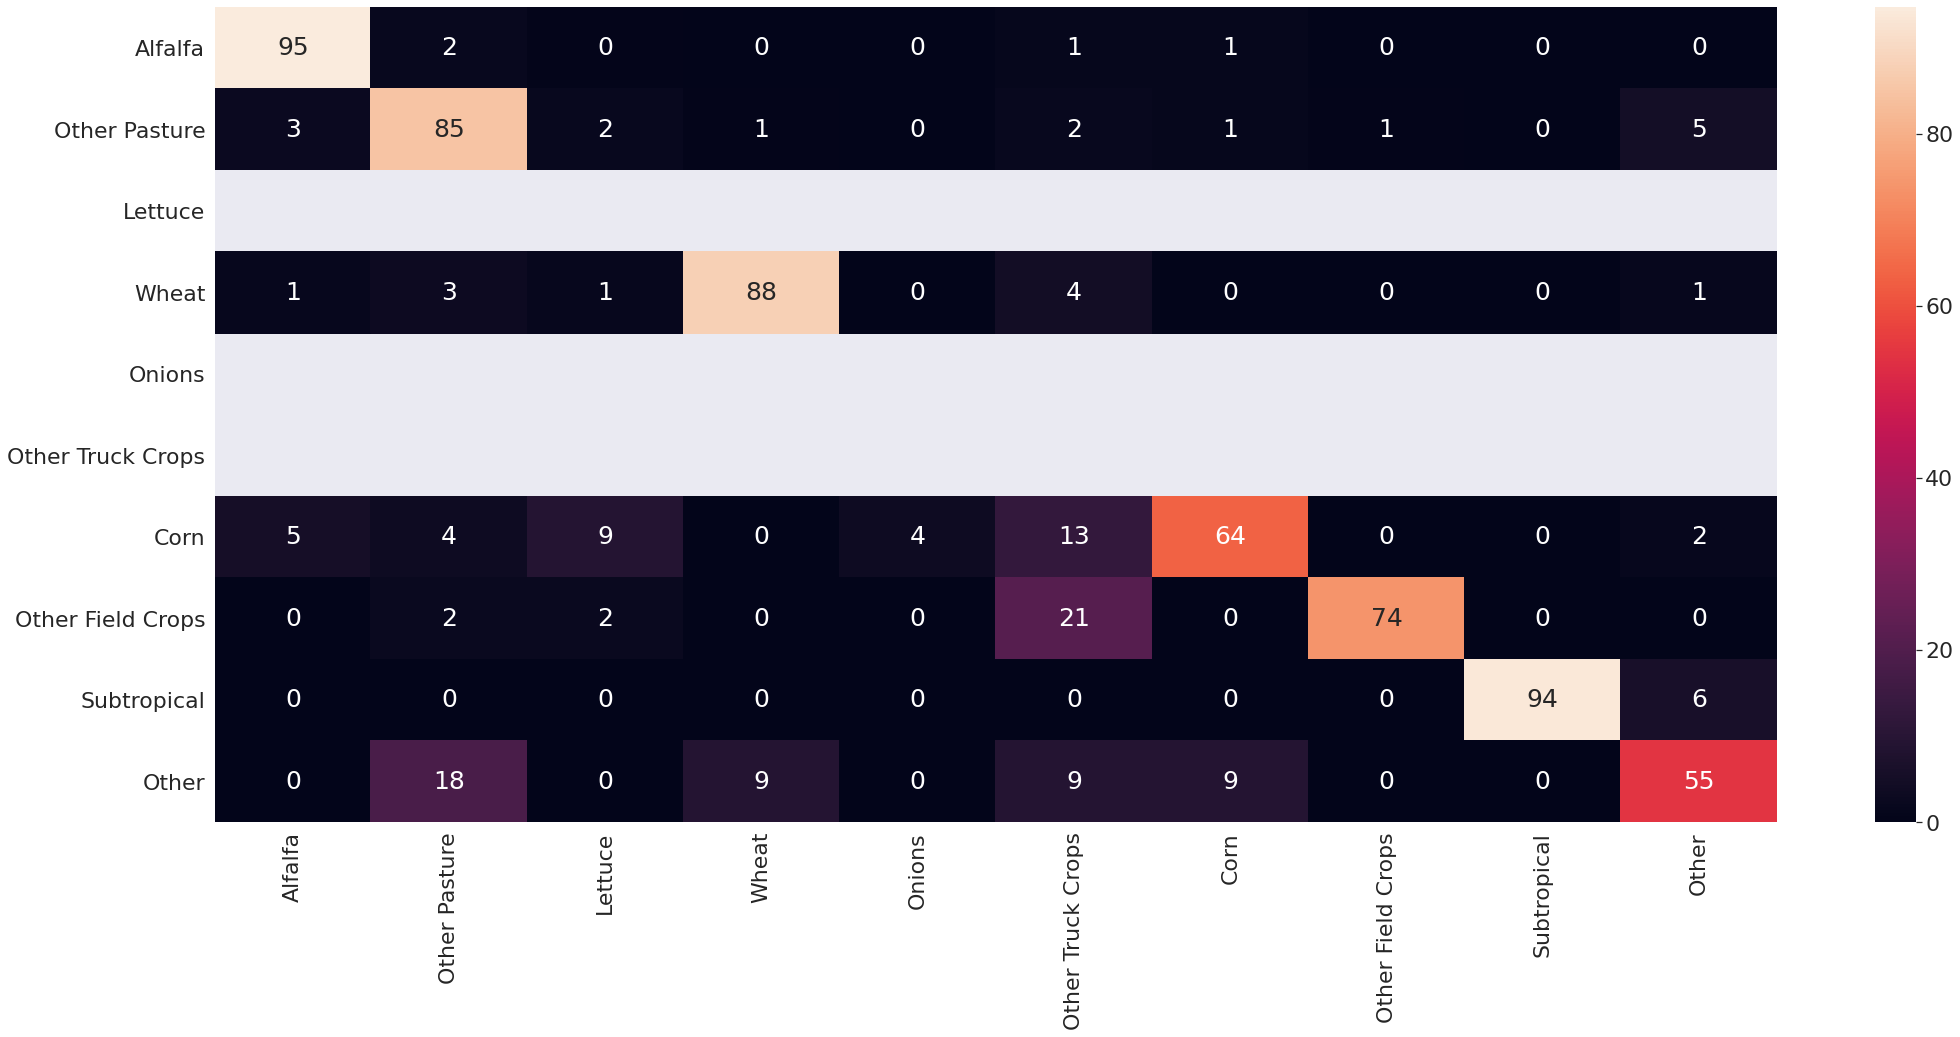

In [ ]:

plt.figure(figsize = (35,15))
sns.set(font_scale=2) 
sns.heatmap(cf1, annot=True, annot_kws={"size": 25},fmt = '.0f')